### Case Study 1

# Google QUEST Q&A Labeling
Improving automated understanding of complex question answer content.


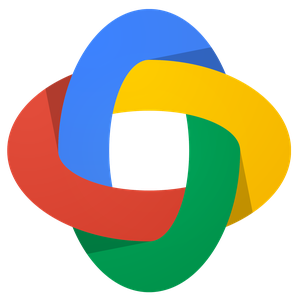

In [1]:
from io import BytesIO
import requests
from PIL import Image
response = requests.get("https://external-content.duckduckgo.com/iu/?u=http%3A%2F%2F1.bp.blogspot.com%2F-qKqxEyuXEQo%2FVD71mHi8sDI%2FAAAAAAAAPhg%2FVwDyvAlXDnY%2Fs1600%2Frgicontransparent.png&f=1&nofb=1")
img = Image.open(BytesIO(response.content))
img.resize((300,300), Image.ANTIALIAS)

## Workflow

#### 1. Problem Statement and source
#### 2. Business Constrain and Dataset Loading
#### 3. Machine learning Formulation and Evalution mtric
#### 4. Loading Dataset
#### 5. Exploratory Data Analyses
#### 6. Insights and Findings
#### 7. Preprocessing and Feature engineering 
#### 8. Modeling and Hyperparameter tuning 
#### 9. Results and Conclusion


#### Special Thanks to these Kaggle kernals and refers 

* https://www.kaggle.com/dimitreoliveira/google-quest-eda-and-use-baseline

* https://www.kaggle.com/codename007/start-from-here-quest-complete-eda-fe



In [2]:
# Ignore all your warnings
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

# Loading Libraries
import datetime
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import f1_score
import pylab 
import scipy.stats as stats
from scipy.stats import boxcox

import re
import pickle
from sklearn.model_selection import train_test_split

from tqdm import tqdm
import os
from wordcloud import WordCloud
from matplotlib_venn import venn2
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from textblob import TextBlob

# 1. Problem Statement
#### Source(kaggle): https://www.kaggle.com/c/google-quest-challenge/overview

## Problem Defination

Computers are really good at answering questions with single, verifiable answers. But, humans are often still better at answering questions about opinions, recommendations, or personal experiences.

Humans are better at addressing subjective questions that require a deeper, multidimensional understanding of context - something computers aren't trained to do well…yet.. Questions can take many forms - some have multi-sentence elaborations, others may be simple curiosity or a fully developed problem. They can have multiple intents, or seek advice and opinions. Some may be helpful and others interesting. Some are simple right or wrong.

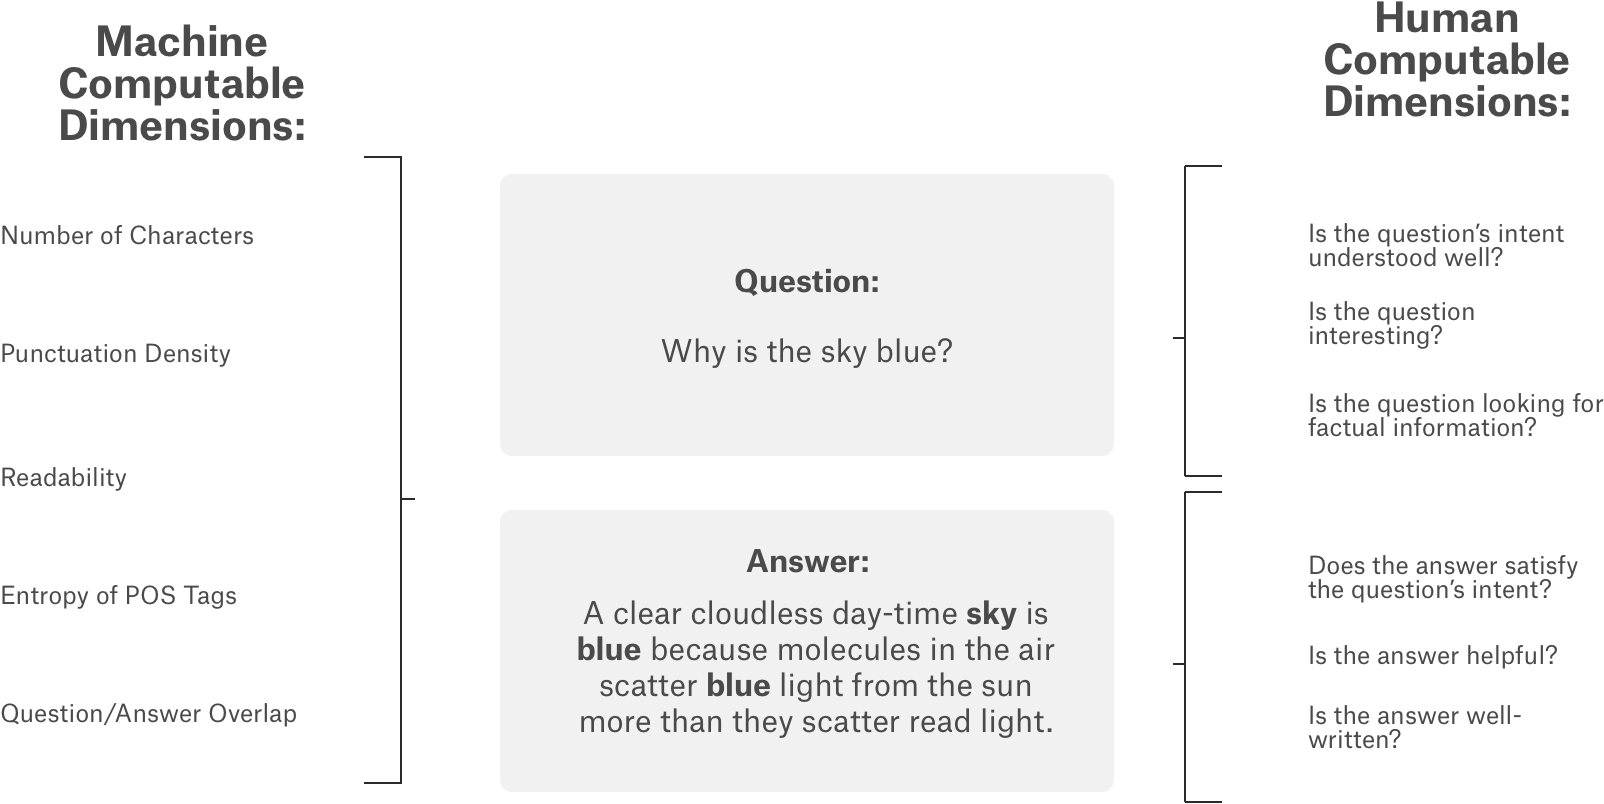

In [3]:
response = requests.get("https://storage.googleapis.com/kaggle-media/competitions/google-research/human_computable_dimensions_1.png")
Image.open(BytesIO(response.content))

Unfortunately, it’s hard to build better subjective question-answering algorithms because of a lack of data and predictive models. That’s why the CrowdSource team at Google Research, a group dedicated to advancing NLP and other types of ML science via crowdsourcing, has collected data on a number of these quality scoring aspects.

In this competition, you’re challenged to use this new dataset to build predictive algorithms for different subjective aspects of question-answering. The question-answer pairs were gathered from nearly 70 different websites, in a "common-sense" fashion. Our raters received minimal guidance and training, and relied largely on their subjective interpretation of the prompts. As such, each prompt was crafted in the most intuitive fashion so that raters could simply use their common-sense to complete the task. By lessening our dependency on complicated and opaque rating guidelines, we hope to increase the re-use value of this data set. What you see is what you get!

Demonstrating these subjective labels can be predicted reliably can shine a new light on this research area. Results from this competition will inform the way future intelligent Q&A systems will get built, hopefully contributing to them becoming more human-like.

## About Dataset

* The data for this competition includes questions and answers from various StackExchange properties. Your task is to predict target values of 30 labels for each question-answer pair.

* The list of 30 target labels are the same as the column names in the sample_submission.csv file. Target labels with the prefix question_ relate to the question_title and/or question_body features in the data. Target labels with the prefix answer_ relate to the answer feature.

* Each row contains a single question and a single answer to that question, along with additional features. The training data contains rows with some duplicated questions (but with different answers). The test data does not contain any duplicated questions.

* This is not a binary prediction challenge. Target labels are aggregated from multiple raters, and can have continuous values in the range [0,1]. Therefore, predictions must also be in that range.

* Since this is a synchronous re-run competition, you only have access to the Public test set. For planning purposes, the re-run test set is no larger than 10,000 rows, and less than 8 Mb uncompressed.

* Additional information about the labels and collection method will be provided by the competition sponsor in the forum.


#### File descriptions
* train.csv - the training data (target labels are the last 30 columns)
* test.csv - the test set (you must predict 30 labels for each test set row)
* sample_submission.csv - a sample submission file in the correct format; column names are the 30 target labels

# 2. Business Objective and Constrains

#### 1. Provide tremendous value in differentiating subjective aspects of question-answering (like humans)

#### 2. No Low Latency required 

#### 3. Model Interpretability is helpful

#### 4. Feature Importance is helpful



# 3. Machine Learning Formulation and Evaluation Metric


## 3.1. Multi Label Regression problem

It is clearly mentioned in Kaggle Competition page:  
"This is not a binary prediction challenge. Target labels are aggregated from multiple raters, and can have continuous values in the range [0,1]. Therefore, predictions must also be in that range."

#### Predict the continous value between range [0,1] for 30 target labels



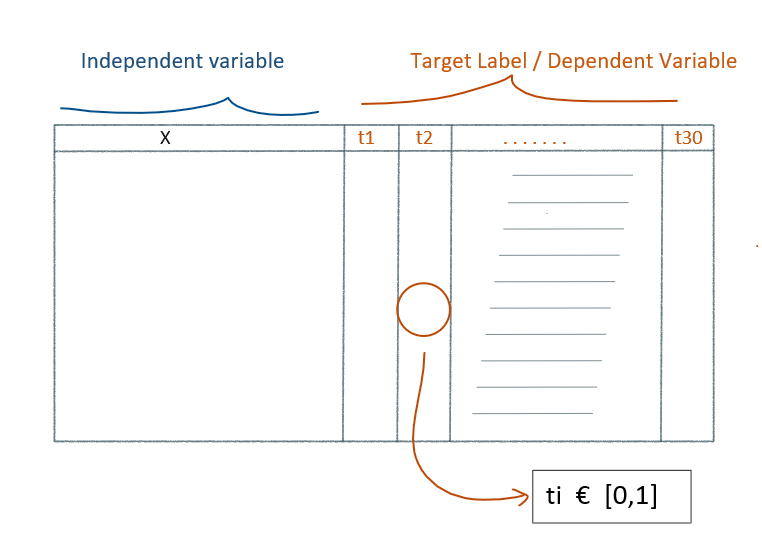

In [4]:
from IPython.display import Image
Image(filename='regression.png',width=500, height=500)

## 3.2 Evaluation Metric

###  'Mean column-wise Spearman's correlation coefficient'

 Submissions are evaluated on the mean column-wise Spearman's correlation coefficient.
 
 The Spearman's rank correlation is computed for each target column, and the mean of these values is calculated for the submission score

#### Defination:

"The Spearman's rank-order correlation is the nonparametric version of the Pearson product-moment correlation. Spearman's correlation coefficient, (ρ, also signified by rs) measures the strength and direction of association between two ranked variables."

#### But why Spearman's correlation coefficient?

Reason



# 4. Loading The Dataset

We have 3 csv files available
* 1. train.csv
* 2. test.csv
* 3. sample_submission.csv

#### 'train.csv' contain all the independent variable and 30 target labels on which we need to train the model.

#### 'test.csv' contain only independent variable on which we have to predict.

#### 'sample_submission.csv' contain the format of how to predict all the target values.

In [5]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
sample_submission = pd.read_csv("sample_submission.csv")

In [6]:
# train_df data
print(f"shape of train_df: {train_df.shape} \n{'='*50}")
train_df.head(2)

shape of train_df: (6079, 41) 


qa_id                                     question_title  \
0      0  What am I losing when using extension tubes in...   
1      1  What is the distinction between a city and a s...   

                                       question_body question_user_name  \
0  After playing around with macro photography on...               ysap   
1  I am trying to understand what kinds of places...      russellpierce   

                           question_user_page  \
0  https://photo.stackexchange.com/users/1024   
1    https://rpg.stackexchange.com/users/8774   

                                              answer answer_user_name  \
0  I just got extension tubes, so here's the skin...           rfusca   
1  It might be helpful to look into the definitio...     Erik Schmidt   

                             answer_user_page  \
0  https://photo.stackexchange.com/users/1917   
1    https://rpg.stackexchange.com/users/1871   

                                                 url   category  ...  \
0  http://photo.stackexchange.com/questions/9169/...  LIFE_ARTS  ...   
1  http://rpg.stackexchange.com/questions/47820/w...    CULTURE  ...   

  question_well_written  answer_helpful  answer_level_of_information  \
0              1.000000        1.000000                     0.666667   
1              0.888889        0.888889                     0.555556   

   answer_plausible  answer_relevance  answer_satisfaction  \
0          1.000000          1.000000             0.800000   
1          0.888889          0.888889             0.666667   

   answer_type_instructions  answer_type_procedure  \
0                       1.0                    0.0   
1                       0.0                    0.0   

   answer_type_reason_explanation  answer_well_written  
0                        0.000000             1.000000  
1                        0.666667             0.888889  

[2 rows x 41 columns]

In [7]:
# test_df data
print(f"shape of test_df: {test_df.shape} \n{'='*50}")
test_df.head(2)

shape of test_df: (476, 11) 


qa_id                                     question_title  \
0     39  Will leaving corpses lying around upset my pri...   
1     46         Url link to feature image in the portfolio   

                                       question_body question_user_name  \
0  I see questions/information online about how t...              Dylan   
1  I am new to Wordpress. i have issue with Featu...                Anu   

                                question_user_page  \
0     https://gaming.stackexchange.com/users/64471   
1  https://wordpress.stackexchange.com/users/72927   

                                              answer answer_user_name  \
0  There is no consequence for leaving corpses an...        Nelson868   
1  I think it is possible with custom fields.\n\n...            Irina   

                                  answer_user_page  \
0     https://gaming.stackexchange.com/users/97324   
1  https://wordpress.stackexchange.com/users/27233   

                                                 url    category  \
0  http://gaming.stackexchange.com/questions/1979...     CULTURE   
1  http://wordpress.stackexchange.com/questions/1...  TECHNOLOGY   

                          host  
0     gaming.stackexchange.com  
1  wordpress.stackexchange.com

### 4.1 Dependent variables or Target Labels

In [8]:
target_vars = sample_submission.columns[1:]
for idx,target in enumerate(target_vars):
    print(idx+1,":",target)

1 : question_asker_intent_understanding
2 : question_body_critical
3 : question_conversational
4 : question_expect_short_answer
5 : question_fact_seeking
6 : question_has_commonly_accepted_answer
7 : question_interestingness_others
8 : question_interestingness_self
9 : question_multi_intent
10 : question_not_really_a_question
11 : question_opinion_seeking
12 : question_type_choice
13 : question_type_compare
14 : question_type_consequence
15 : question_type_definition
16 : question_type_entity
17 : question_type_instructions
18 : question_type_procedure
19 : question_type_reason_explanation
20 : question_type_spelling
21 : question_well_written
22 : answer_helpful
23 : answer_level_of_information
24 : answer_plausible
25 : answer_relevance
26 : answer_satisfaction
27 : answer_type_instructions
28 : answer_type_procedure
29 : answer_type_reason_explanation
30 : answer_well_written


In [9]:
# sample of Target variable
train_df[target_vars].head()

question_asker_intent_understanding  question_body_critical  \
0                             1.000000                0.333333   
1                             1.000000                1.000000   
2                             0.888889                0.666667   
3                             0.888889                0.666667   
4                             1.000000                0.666667   

   question_conversational  question_expect_short_answer  \
0                 0.000000                           0.0   
1                 0.000000                           0.5   
2                 0.000000                           1.0   
3                 0.666667                           1.0   
4                 0.000000                           1.0   

   question_fact_seeking  question_has_commonly_accepted_answer  \
0                    0.0                                    0.0   
1                    1.0                                    1.0   
2                    1.0                                    1.0   
3                    1.0                                    1.0   
4                    1.0                                    1.0   

   question_interestingness_others  question_interestingness_self  \
0                         1.000000                       1.000000   
1                         0.444444                       0.444444   
2                         0.666667                       0.444444   
3                         0.444444                       0.444444   
4                         0.666667                       0.666667   

   question_multi_intent  question_not_really_a_question  ...  \
0               0.000000                             0.0  ...   
1               0.666667                             0.0  ...   
2               0.333333                             0.0  ...   
3               0.000000                             0.0  ...   
4               0.000000                             0.0  ...   

   question_well_written  answer_helpful  answer_level_of_information  \
0               1.000000        1.000000                     0.666667   
1               0.888889        0.888889                     0.555556   
2               0.777778        0.777778                     0.555556   
3               0.888889        0.833333                     0.333333   
4               1.000000        1.000000                     0.666667   

   answer_plausible  answer_relevance  answer_satisfaction  \
0          1.000000          1.000000             0.800000   
1          0.888889          0.888889             0.666667   
2          1.000000          1.000000             0.666667   
3          0.833333          1.000000             0.800000   
4          1.000000          1.000000             0.800000   

   answer_type_instructions  answer_type_procedure  \
0                       1.0               0.000000   
1                       0.0               0.000000   
2                       0.0               0.333333   
3                       0.0               0.000000   
4                       1.0               0.000000   

   answer_type_reason_explanation  answer_well_written  
0                        0.000000             1.000000  
1                        0.666667             0.888889  
2                        1.000000             0.888889  
3                        1.000000             1.000000  
4                        1.000000             1.000000  

[5 rows x 30 columns]

### 4.2 Independent variables

In [10]:
x_columns = [columns for columns in train_df.columns if columns not in sample_submission.columns[1:]]
for idx,x_var in enumerate(x_columns):
    print(idx+1,":",x_var)

1 : qa_id
2 : question_title
3 : question_body
4 : question_user_name
5 : question_user_page
6 : answer
7 : answer_user_name
8 : answer_user_page
9 : url
10 : category
11 : host


In [11]:
# sample of dependent variables
train_df[x_columns].head()

qa_id                                     question_title  \
0      0  What am I losing when using extension tubes in...   
1      1  What is the distinction between a city and a s...   
2      2  Maximum protusion length for through-hole comp...   
3      3              Can an affidavit be used in Beit Din?   
4      5       How do you make a binary image in Photoshop?   

                                       question_body question_user_name  \
0  After playing around with macro photography on...               ysap   
1  I am trying to understand what kinds of places...      russellpierce   
2  I'm working on a PCB that has through-hole com...          Joe Baker   
3  An affidavit, from what i understand, is basic...         Scimonster   
4  I am trying to make a binary image. I want mor...            leigero   

                                  question_user_page  \
0         https://photo.stackexchange.com/users/1024   
1           https://rpg.stackexchange.com/users/8774   
2  https://electronics.stackexchange.com/users/10157   
3       https://judaism.stackexchange.com/users/5151   
4  https://graphicdesign.stackexchange.com/users/...   

                                              answer answer_user_name  \
0  I just got extension tubes, so here's the skin...           rfusca   
1  It might be helpful to look into the definitio...     Erik Schmidt   
2  Do you even need grooves?  We make several pro...      Dwayne Reid   
3  Sending an "affidavit" it is a dispute between...    Y     e     z   
4  Check out Image Trace in Adobe Illustrator. \n...             q2ra   

                                    answer_user_page  \
0         https://photo.stackexchange.com/users/1917   
1           https://rpg.stackexchange.com/users/1871   
2  https://electronics.stackexchange.com/users/64754   
3       https://judaism.stackexchange.com/users/4794   
4  https://graphicdesign.stackexchange.com/users/...   

                                                 url   category  \
0  http://photo.stackexchange.com/questions/9169/...  LIFE_ARTS   
1  http://rpg.stackexchange.com/questions/47820/w...    CULTURE   
2  http://electronics.stackexchange.com/questions...    SCIENCE   
3  http://judaism.stackexchange.com/questions/551...    CULTURE   
4  http://graphicdesign.stackexchange.com/questio...  LIFE_ARTS   

                              host  
0          photo.stackexchange.com  
1            rpg.stackexchange.com  
2    electronics.stackexchange.com  
3        judaism.stackexchange.com  
4  graphicdesign.stackexchange.com

# 5. Exploratory Data Analyses

## 5.1. Overview of train_df

In [12]:
# train_df data
print(f"shape of train_df: {train_df.shape} \n{'='*50}")

shape of train_df: (6079, 41) 


In [13]:
# This includes both independent variables and target variables
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6079 entries, 0 to 6078
Data columns (total 41 columns):
qa_id                                    6079 non-null int64
question_title                           6079 non-null object
question_body                            6079 non-null object
question_user_name                       6079 non-null object
question_user_page                       6079 non-null object
answer                                   6079 non-null object
answer_user_name                         6079 non-null object
answer_user_page                         6079 non-null object
url                                      6079 non-null object
category                                 6079 non-null object
host                                     6079 non-null object
question_asker_intent_understanding      6079 non-null float64
question_body_critical                   6079 non-null float64
question_conversational                  6079 non-null float64
question_expect_short_a

#### Observations
* There is around 6k datapoints in training data
* There is no null values in any of the columns but there is some repeated questions present in data which is answered by different users ( clearly mentioned on Kaggle Competition page )

## 5.2. Sample Datapoint (train_df)

#### Sample

In [14]:
# sample
sample=train_df.iloc[0]
sample_question = sample[['qa_id', 'question_title', 'question_body']]
sample_answer = sample[['answer']]
sample_question_target_labels = sample[['question_asker_intent_understanding',
       'question_body_critical', 'question_conversational',
       'question_expect_short_answer', 'question_fact_seeking',
       'question_has_commonly_accepted_answer',
       'question_interestingness_others', 'question_interestingness_self',
       'question_multi_intent', 'question_not_really_a_question',
       'question_opinion_seeking', 'question_type_choice',
       'question_type_compare', 'question_type_consequence',
       'question_type_definition', 'question_type_entity',
       'question_type_instructions', 'question_type_procedure',
       'question_type_reason_explanation', 'question_type_spelling',
       'question_well_written']]
sample_answer_target_labels = sample[['answer_helpful',
       'answer_level_of_information', 'answer_plausible', 'answer_relevance',
       'answer_satisfaction', 'answer_type_instructions',
       'answer_type_procedure', 'answer_type_reason_explanation',
       'answer_well_written']]

#### Sample Question

In [15]:
for i in sample_question.index:
    print(i,":",sample_question[i],"\n")

qa_id : 0 

question_title : What am I losing when using extension tubes instead of a macro lens? 

question_body : After playing around with macro photography on-the-cheap (read: reversed lens, rev. lens mounted on a straight lens, passive extension tubes), I would like to get further with this. The problems with the techniques I used is that focus is manual and aperture control is problematic at best. This limited my setup to still subjects (read: dead insects) Now, as spring is approaching, I want to be able to shoot live insects. I believe that for this, autofocus and settable aperture will be of great help.

So, one obvious but expensive option is a macro lens (say, EF 100mm Macro) However, I am not really interested in yet another prime lens. An alternative is the electrical extension tubes.

Except for maximum focusing distance, what am I losing when using tubes (coupled with a fine lens, say EF70-200/2.8) instead of a macro lens?
 



#### Sample Answer

In [16]:
print(sample_answer[0])

I just got extension tubes, so here's the skinny.


  ...what am I losing when using tubes...?


A very considerable amount of light!  Increasing that distance from the end of the lens to the sensor can cut your light several stops.  Combined with the fact that you'll usually shoot stopped down - expect to need to increase your ISO considerably.

The fact the macro's are usually considered very very sharp, although I believe that 70-200mm 2.8 is supposed to be quite sharp.

The ultra low distortion typical of many macros.

I wouldn't worry too much about the bokeh since the DOF will still be quite limited.

Coupled on my 50mm, a full 60mm'ish extension tube results in a DOF of about a couple inches in front of the lens.  On my 70-300, its probably around 2-3 feet in front of the lens to about a foot in front of the lens.



#### Sample Question Target Labels

In [17]:
print(sample_question_target_labels)

question_asker_intent_understanding             1
question_body_critical                   0.333333
question_conversational                         0
question_expect_short_answer                    0
question_fact_seeking                           0
question_has_commonly_accepted_answer           0
question_interestingness_others                 1
question_interestingness_self                   1
question_multi_intent                           0
question_not_really_a_question                  0
question_opinion_seeking                        1
question_type_choice                            0
question_type_compare                           0
question_type_consequence                       0
question_type_definition                        0
question_type_entity                            0
question_type_instructions                      1
question_type_procedure                         0
question_type_reason_explanation                0
question_type_spelling                          0


#### Sample Answer Target Labels

In [18]:
print(sample_answer_target_labels)

answer_helpful                           1
answer_level_of_information       0.666667
answer_plausible                         1
answer_relevance                         1
answer_satisfaction                    0.8
answer_type_instructions                 1
answer_type_procedure                    0
answer_type_reason_explanation           0
answer_well_written                      1
Name: 0, dtype: object


## 5.3. EDA: Target Labels

In [19]:
target_vars = sample_submission.columns[1:]
for idx,target in enumerate(target_vars):
    print(idx+1,":",target)

1 : question_asker_intent_understanding
2 : question_body_critical
3 : question_conversational
4 : question_expect_short_answer
5 : question_fact_seeking
6 : question_has_commonly_accepted_answer
7 : question_interestingness_others
8 : question_interestingness_self
9 : question_multi_intent
10 : question_not_really_a_question
11 : question_opinion_seeking
12 : question_type_choice
13 : question_type_compare
14 : question_type_consequence
15 : question_type_definition
16 : question_type_entity
17 : question_type_instructions
18 : question_type_procedure
19 : question_type_reason_explanation
20 : question_type_spelling
21 : question_well_written
22 : answer_helpful
23 : answer_level_of_information
24 : answer_plausible
25 : answer_relevance
26 : answer_satisfaction
27 : answer_type_instructions
28 : answer_type_procedure
29 : answer_type_reason_explanation
30 : answer_well_written


* Each of the Target Labels name is self explanatory
* All the 30 Taget Labes has values between range [0,1]

### 5.3.1. Distribution of target labels

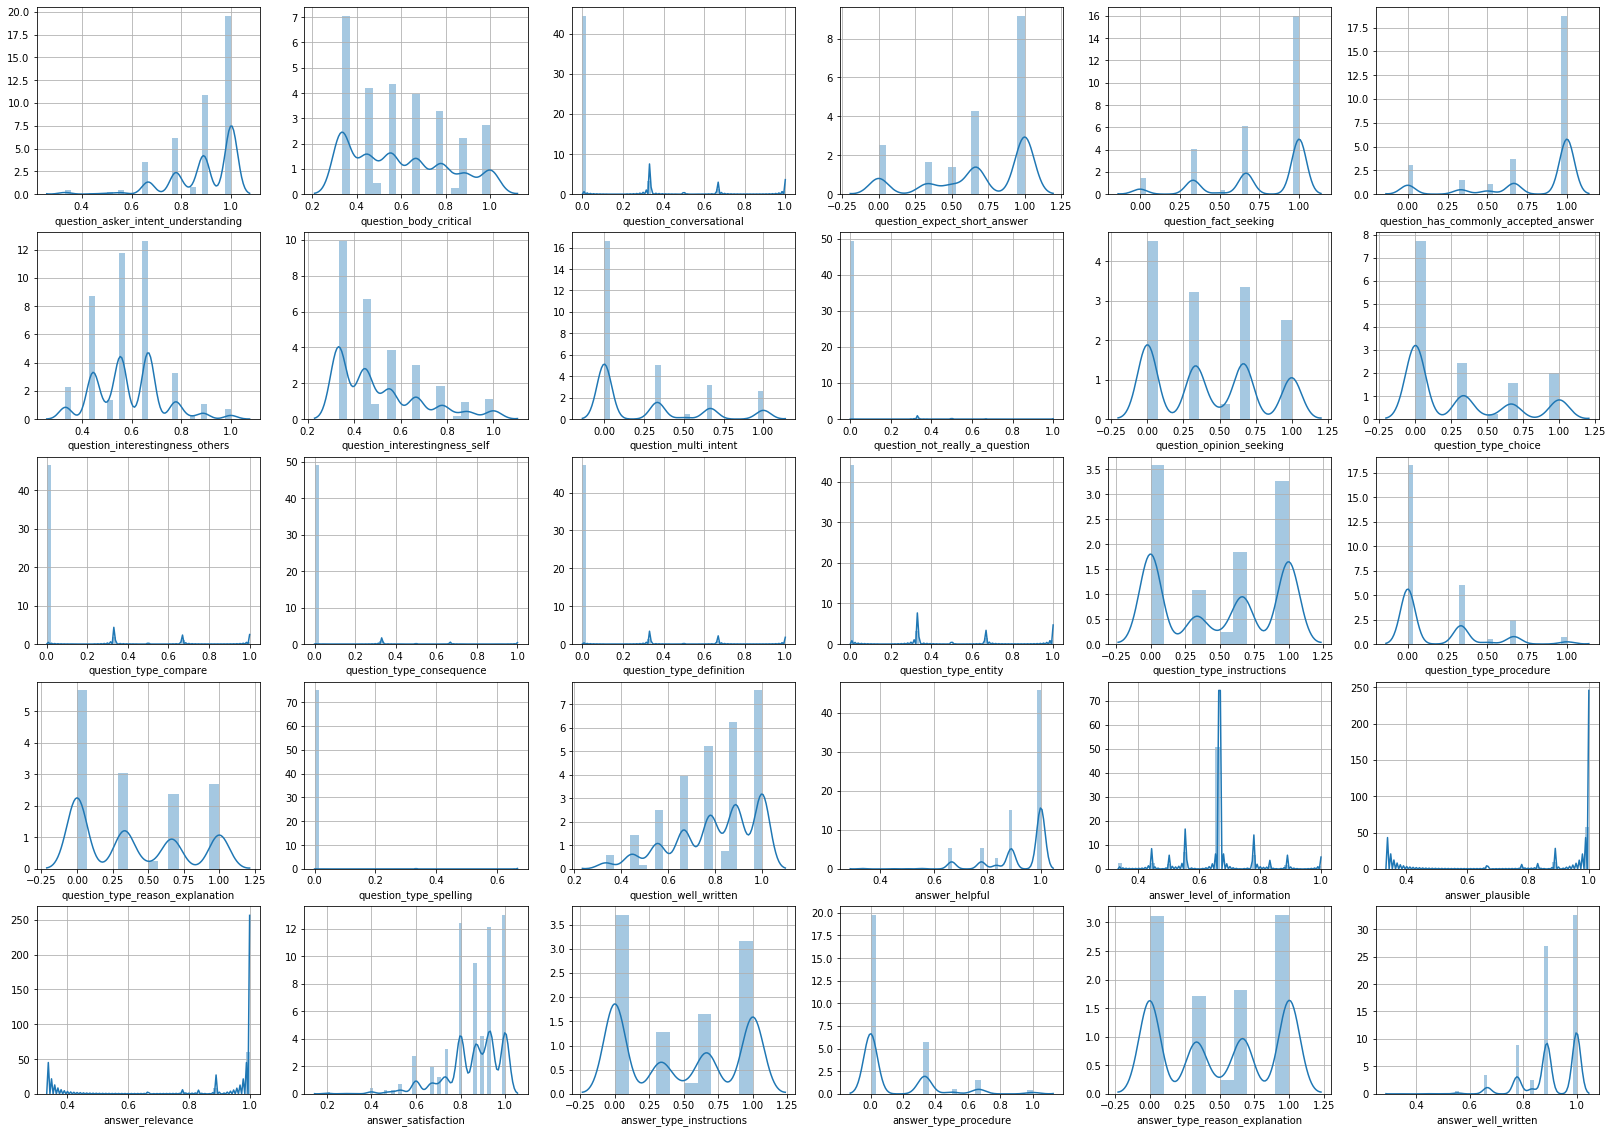

In [20]:
plt.figure(figsize=(28,20))
for idx,target in enumerate(target_vars): 
    sns.distplot(train_df[target],ax=plt.subplot(5,6,idx+1))
    plt.grid()
plt.show()

#### Observation:

1. Almost all taget labels are imbalanced and skewed but some are highly skewed like 'question_not_really' , 'question_type_spelling' etc. So we need to take special care for those labels.

2. Wee need to make sure not to overfit on highly skewed target labels.
    

### 5.3.2. Correlation between target labels

#### Note:

* keep this in mind that "Correlation is not necessary because of causation". 

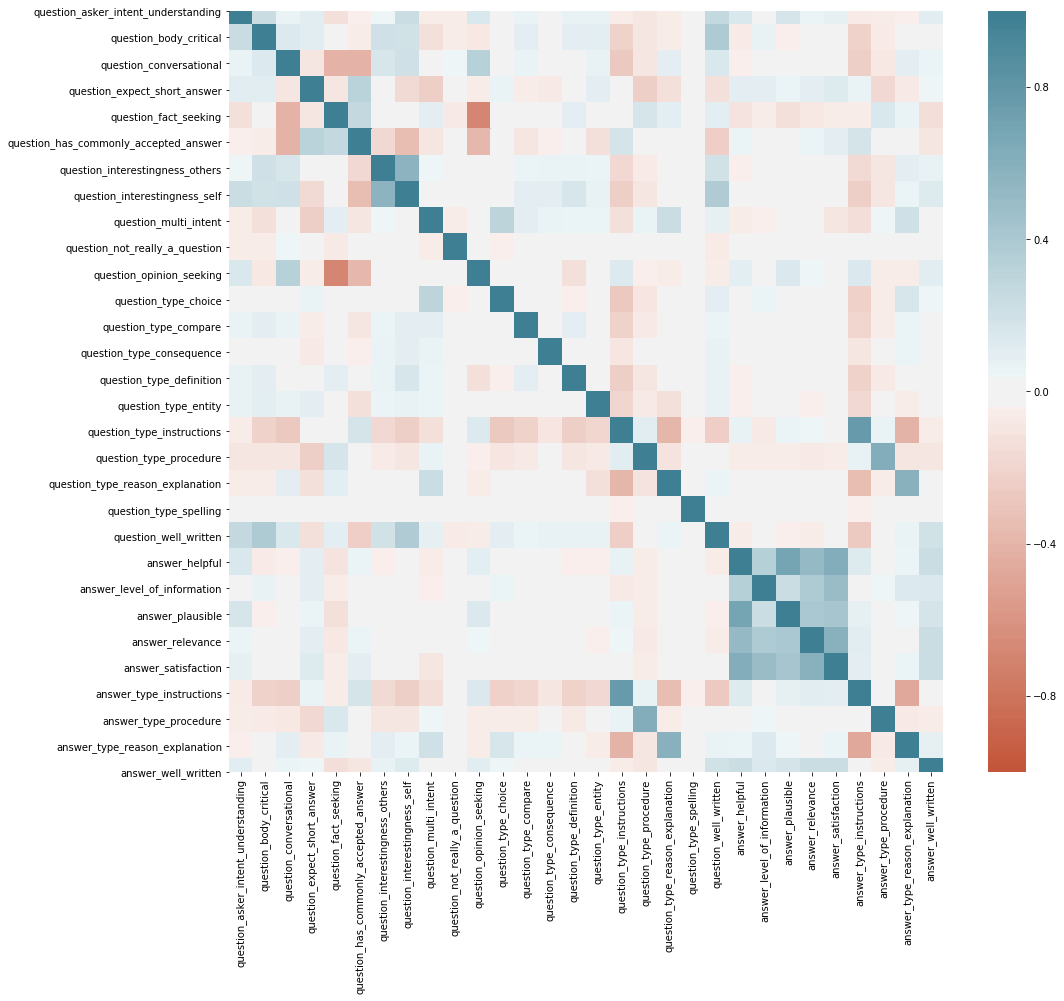

In [21]:
corr = train_df[target_vars].corr()

# plot the heatmap
plt.figure(figsize=(16,14))
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap=sns.diverging_palette(20, 220, n=200),
        vmin=-1, vmax=1, center=0,)
plt.show()

#### Observation

1. There are some obvious high positive correlation e.g.
    * answer_type_instructions is highly correlated to question_type_instructions.
    * answer_type_procedure is highly correlated to question_type_procedure.
    * answer_type_reason_explanation  is highly correlated to question_type_reason_explanation.
    * question_interestingness_self is highly co related with question_interestingness_others 
    
    
2. Some other high posive correlation 
    * answer_level_of_information is highly correlated to answer_helpful.
    * answer_plausable is highly correlated to answer_helpful.
    * answer_satisfaction is highly correlated to answer_helpful , answer_level_of_information , answer_plausable and answer_relavance.
    
    
3. There are also some high negative correlation is present
    * question_fact_seeking is negatively correlated question_opinion_seeking.
    * heatmap indicating light red color refers to all negatively correlated labels.
    

### 5.3.3 Plot of Target labels with high Correlation (either positive or negative)

****Distribtion Plots for postitive Correlation Target labels****


plot: 1 


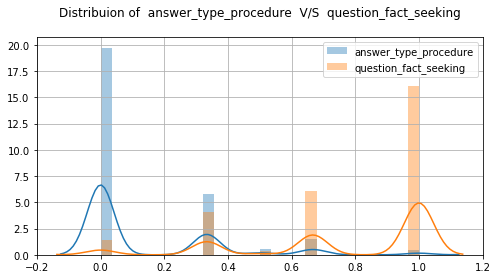

plot: 2 


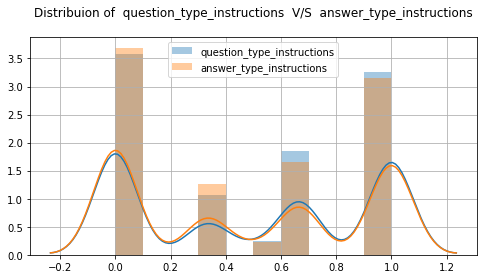

plot: 3 


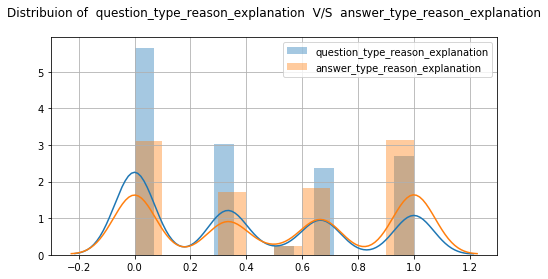

plot: 4 


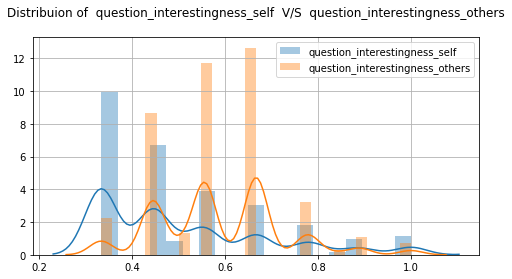

plot: 5 


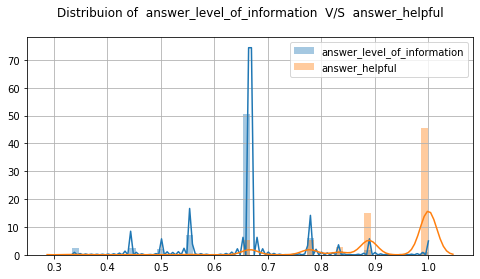

plot: 6 


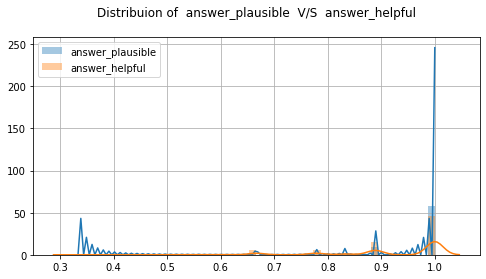

plot: 7 


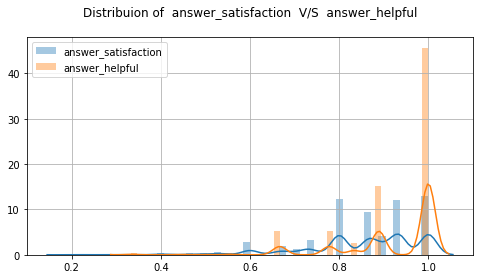



****Distribtion Plots for high Negative Correlation Target labels****

plot: 1 


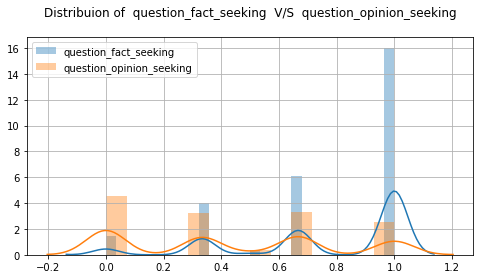

In [22]:
## Distribution plots for highly positive Correlated labels
high_pos_corr_feat = [['answer_type_procedure','question_fact_seeking'],
["question_type_instructions","answer_type_instructions"],
['question_type_reason_explanation','answer_type_reason_explanation'],
['question_interestingness_self','question_interestingness_others'],
['answer_level_of_information','answer_helpful'],
['answer_plausible','answer_helpful'],
['answer_satisfaction','answer_helpful']]

print("****Distribtion Plots for postitive Correlation Target labels****\n\n")
for idx, feat in enumerate(high_pos_corr_feat):
    print(f"plot: {idx+1} ")
    plt.figure(figsize=(8,4))
    sns.distplot(train_df[f'{feat[0]}'], label=f"{feat[0]}")
    sns.distplot(train_df[f'{feat[1]}'], label=f"{feat[1]}")
    plt.legend()
    plt.xlabel(None)
    plt.title(f"Distribuion of  {feat[0]}  V/S  {feat[1]}\n")
    plt.grid()
    plt.show()


## Distribution plots for highly negative Correlated labels
high_neg_corr_feat = [['question_fact_seeking','question_opinion_seeking']]

print("\n\n****Distribtion Plots for high Negative Correlation Target labels****\n")
for idx, feat in enumerate(high_neg_corr_feat):
    print(f"plot: {idx+1} ")
    plt.figure(figsize=(8,4))
    sns.distplot(train_df[f'{feat[0]}'], label=f"{feat[0]}")
    sns.distplot(train_df[f'{feat[1]}'], label=f"{feat[1]}")
    plt.legend()
    plt.xlabel(None)
    plt.title(f"Distribuion of  {feat[0]}  V/S  {feat[1]}\n")
    plt.grid()
    plt.show()


* we can see that few of the targets which have high positive correlation have very similar distributions and some are even overlaping.
* Same can be observed for targets which have high negative correlation.

## 5.4. EDA: Dependent Variable Questions_title

### 5.4.0. Utility Fuctions

In [23]:
# Utility function to plot lineplot and distplot using seaborn
def plot_sns(data,feature,color='lightblue',title=None,subtitle=None):
    
    """   
    Utility function to plot lineplot and distplot using seaborn
    
    plot_sns(data,feature,color='lightblue',title=None,subtitle=None):
    
    data = data 
    feature = coulum name
    color = color of plot
    title = Either 'length' or 'number' based on which to plot. Otherwise by default='None'
    subtitle = Either 'train_df' or 'test_df'. Otherwise by default='None'  
    
    """    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
    
    # line plot
    sns.lineplot(np.arange(len(data)),data,ax=ax1,color=color)    
    if title=='number':
        ax1.set(xlabel=f"Idx of {feature}", ylabel=f"Number of words in {feature}", title=f'Number of words in {feature} in {subtitle}\n')
    elif title=='length':
        ax1.set(xlabel=f"Idx of {feature}", ylabel=f"Length of {feature}", title=f'Length of {feature} in {subtitle}\n')   
    ax1.grid()

    # distribution plot
    sns.distplot(data,ax=ax2,color=color)
    if title=='number':
        ax2.set(xlabel=f"Idx of {feature}", ylabel=f"Number of words in {feature}", title=f'Number of words in {feature} in {subtitle}\n')
    elif title=='length':
        ax2.set(xlabel=f"Idx of {feature}", ylabel=f"Length of {feature}", title=f'Length of {feature} in {subtitle}\n')   
    ax2.grid()
    plt.show()

#=======================================================================================================================================================================================    
# Utility function to plot bar graph for both train and test using seaborn
def plot_bar(train_data,test_data,feature=None,x_label=None, y_label=None):
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

    # for train_df
    sns.barplot(train_data,np.arange(len(train_data)),ax=ax1)
    ax1.set(xlabel=f"{x_label}", ylabel=f"{y_label} {feature}", title='train_df\n')
    ax1.grid()
    
    # for test_df
    sns.barplot(test_data,np.arange(len(test_data)),ax=ax2)
    ax2.set(xlabel=f"{x_label}", ylabel=f"{y_label} {feature}", title='test_df\n')
    ax2.grid()
    plt.show()
    
#=======================================================================================================================================================================================  
# Utility function to plot requency of most popular words
def word_frequency_plot(dataframe, title=None):
    list_of_all_words = []
    for sent in dataframe:
        list_of_all_words.extend(sent.split())

    top_50_words = pd.Series(list_of_all_words).value_counts()[:50]
    top_50_words_prob_dist = top_50_words.values/sum(top_50_words.values)

    #  plot of frequency of polpular words in train
    plt.figure(figsize=(16,7))
    sns.barplot(top_50_words.index, top_50_words_prob_dist)
    plt.xlabel("words")
    plt.ylabel("frequency")
    plt.title(f"Frequency of most popular words {title}\n")
    plt.xticks(rotation=70)
    plt.grid()
    plt.show()

#=======================================================================================================================================================================================
# Utility function to check if feature or variable follows Normal distribution using Q-Q Plot   
def q_q_plot(train_data, test_data, feature_name=None):
    """
    # code refer: https://stackoverflow.com/a/13865874
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
    
    measurements = train_data
    stats.probplot(measurements, dist="norm", plot=ax1)
    ax1.set(title=f'train : Q-Q Plot for {feature_name} \n')

    measurements = test_data
    stats.probplot(measurements, dist="norm", plot=ax2)
    ax2.set(title=f'test : Q-Q Plot for {feature_name} \n')
    plt.show()
        
#=======================================================================================================================================================================================    
# Utility function for box plot
def box_plot(train_data, test_data, feature_name=None):
    
    # for train data
    plt.figure(figsize=(26,4))
    sns.violinplot(train_data,color='darkred')
    plt.title(f'Train : violinplot Plot for {feature_name} \n')
    plt.xlabel(f"{feature_name}")
    plt.ylabel(f"Distribution")   
    plt.grid()
    plt.show()
    
    # for test data
    plt.figure(figsize=(26,4))
    sns.violinplot(test_data,color='orangered')
    plt.title(f'Test : violinplot Plot for {feature_name} \n')
    plt.xlabel(f"{feature_name}")
    plt.ylabel(f"Distribution")   
    plt.grid()
    plt.show()

### 5.4.1. Number of repeated question_title in train and test

#### Which Question is most popular?
Which question has maximum number of answers?

In [24]:
#Counts of repeated question_title in train
pd.DataFrame(train_df['question_title'].value_counts())

question_title
What is the best introductory Bayesian statisti...              12
What does mathematics have to do with programming?              11
Important non-technical course for programmers?                 11
How to prevent the "Too awesome to use" syndrome                 9
How do I deal with a slow and undedicated colle...               7
...                                                            ...
custom form validation class for a module I am ...               1
Programming CC430F5137 using another microcontr...               1
Parallel circuit and Ohms law                                    1
Path Variable Not Working                                        1
How to select multiple non-sequential lines in Vim               1

[3583 rows x 1 columns]

In [25]:
#Counts of repeated question_title in test
pd.DataFrame(test_df['question_title'].value_counts())

question_title
How to watch rss feed for new entries from bash...               1
Add item to media library from blob or dataUrl                   1
What happens at the end of Impossible Mission II?                1
SQL - Check if a date is the first occurrence o...               1
remove and disable image link in functions.php                   1
...                                                            ...
HTC Droid Incredible 2 Imei Location                             1
Reporting and handling asynchronous process err...               1
The bottom of my black cheap pan has worn off a...               1
Field Calculator not showing some fields                         1
Is jquery datepicker easily capable of doing this?               1

[476 rows x 1 columns]

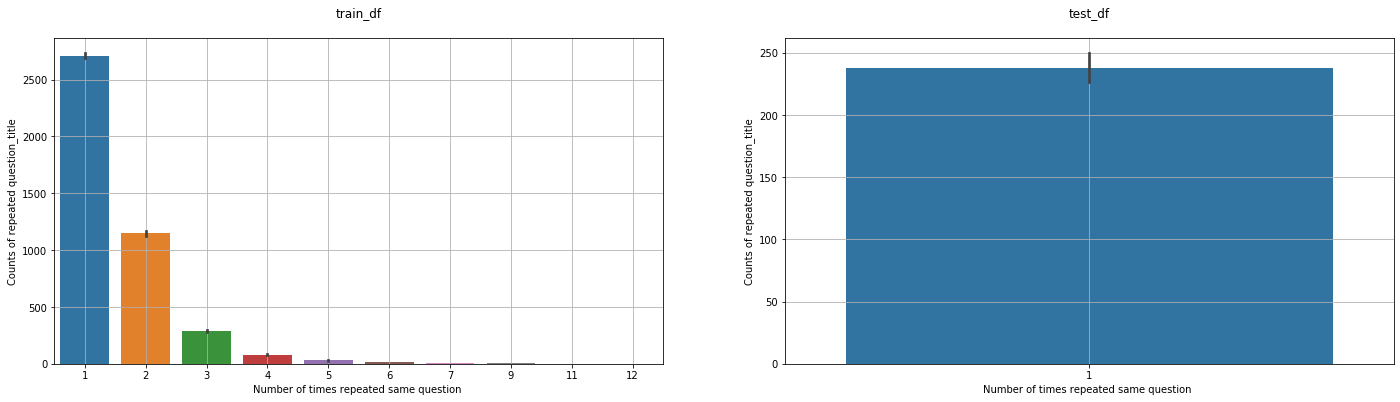

In [26]:
# Number of repeated question_title in train
n_repeated_question_title_train = train_df['question_title'].value_counts().values

# Number of repeated question_title in test
n_repeated_question_title_test = test_df['question_title'].value_counts().values

# plot for Number of repeated question_title in train and test
plot_bar(n_repeated_question_title_train, n_repeated_question_title_test,feature='question_title',x_label="Number of times repeated same question ",y_label="Counts of repeated")

* Many of the questions occured only 1 time but still very large numbers of question occured more than once in the train data.
* Maximum number of times a question occured repeatedly in train data is 12.
* Test data do not have any repeative occurance of questions.

### 5.4.2 Length of question_title in train and test 

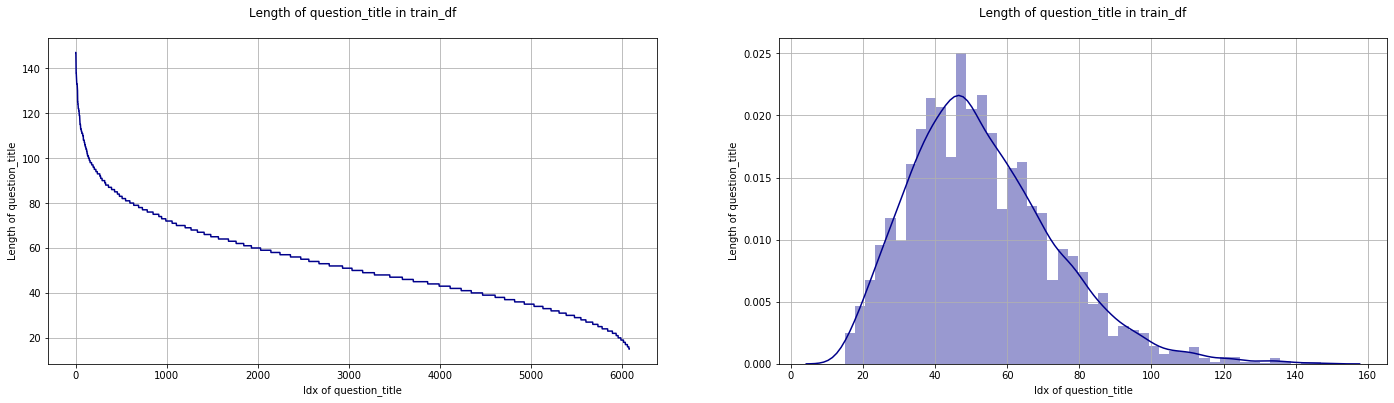

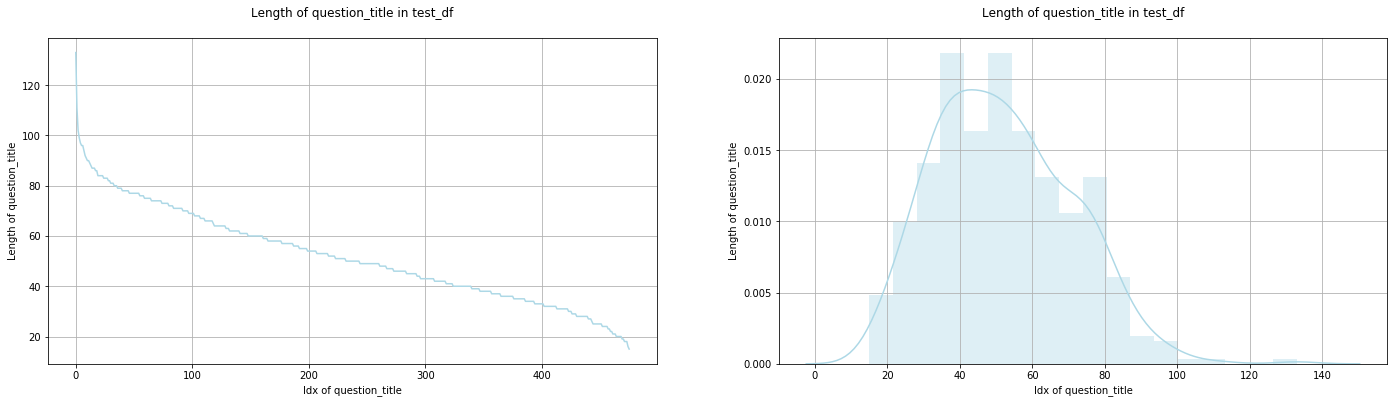

In [27]:
# Length of question_title in train
len_question_title_train = sorted(train_df['question_title'].apply(lambda x: len(x)),reverse=True)

# Length of question_title in test
len_question_title_test = sorted(test_df['question_title'].apply(lambda x: len(x)),reverse=True)

# plot for train_df
plot_sns(len_question_title_train,"question_title",color='darkblue',title='length',subtitle='train_df')

# plot for test_df
plot_sns(len_question_title_test,"question_title",color='lightblue',title='length',subtitle='test_df')

#### 5.4.2.1 Box plot of Length of question_title in train and test

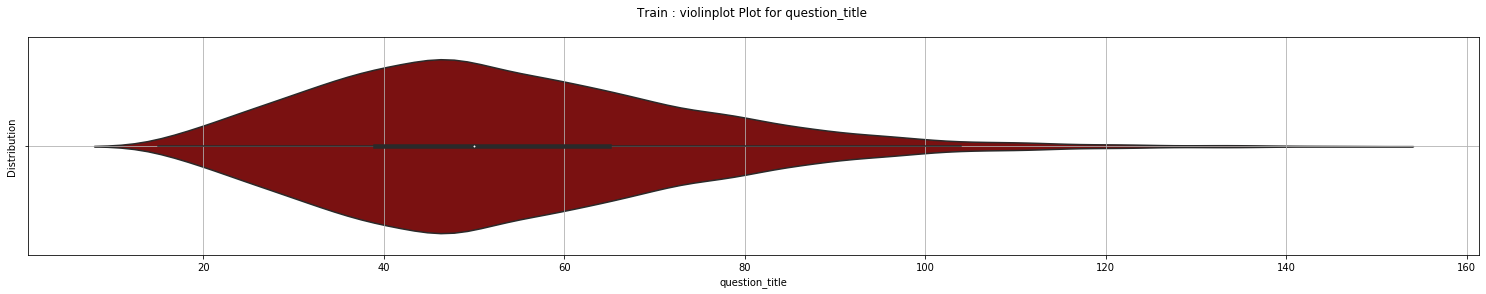

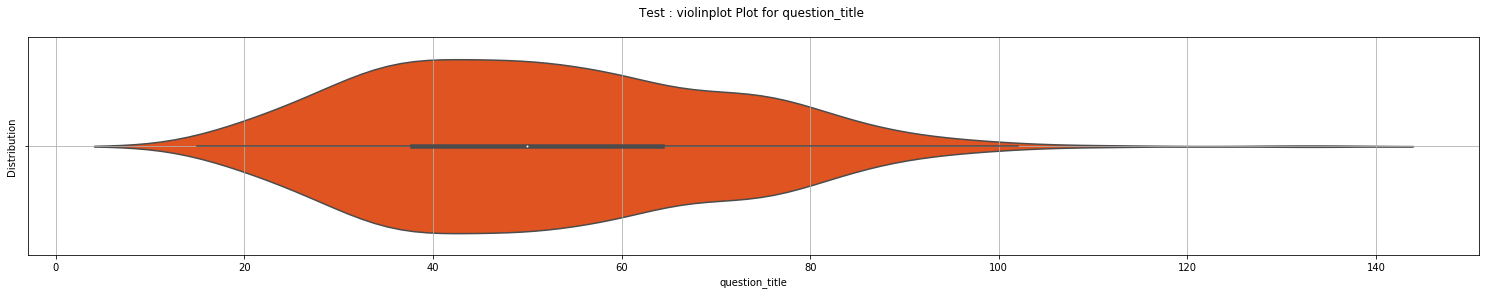

In [28]:
# Box plot of Length of question_title in train and test
box_plot(len_question_title_train, len_question_title_test, "question_title")

* The length of most of question_title in train and test lies between ~ (20,100) 
* Very few question_title has very large length.
* It also looks like the length of question_title follows Normal distribution with slight skeweness toward the right . Let's find it out using Q-Q plot.

#### 5.4.2.2.  Checking weather len_question_title follows normal distribution using Q-Q plot

If len_question_title follows Normal or Gaussian distribution , We can make use of these features in Logistic Regression like model which is the generalisation of gaussian Naive Bayes for better results

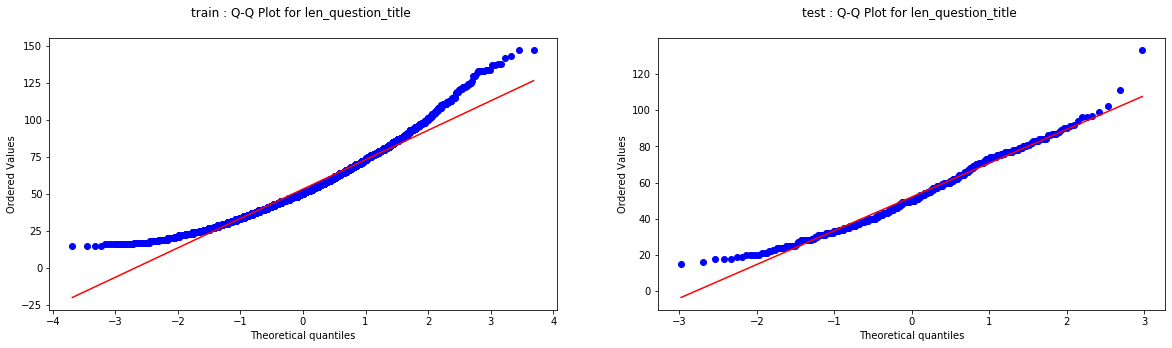

In [29]:
# Checking weather len_question_title follows normal distribution using Q-Q plot
q_q_plot(len_question_title_train, len_question_title_test, "len_question_title")

#### Observation
* No, Length of question_title does not follows normal distribution.

### 5.4.3 Number of words in question_title in train and test 

In [30]:
# number of words in question_title in train
n_words_in_question_title_train = sorted(train_df['question_title'].apply(lambda x: len(x.split(" "))),reverse=True)

# number of words in question_title in test
n_words_in_question_title_test = sorted(test_df['question_title'].apply(lambda x: len(x.split(" "))),reverse=True)

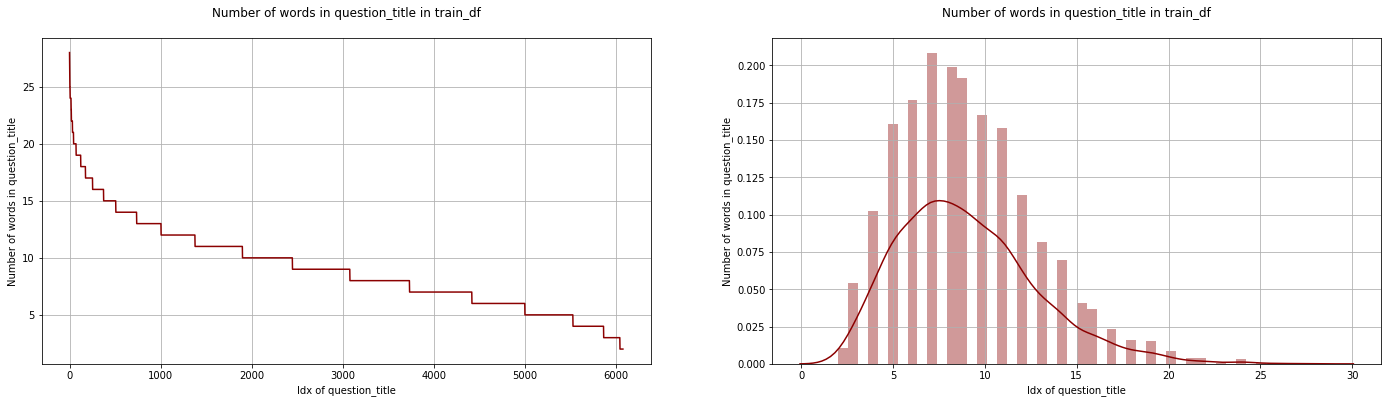

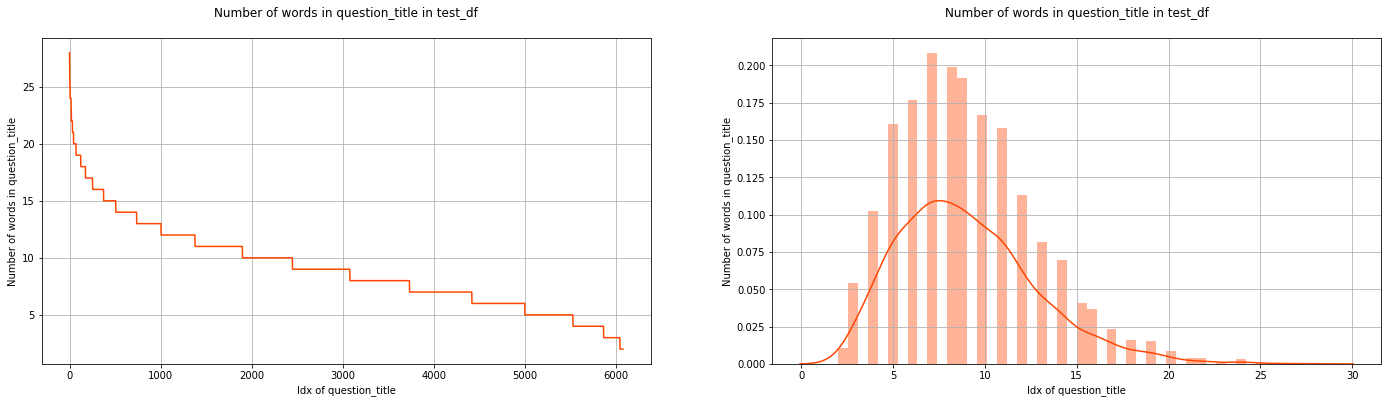

In [31]:
# plot for train_df
plot_sns(n_words_in_question_title_train,"question_title",color='darkred',title='number',subtitle='train_df')

# plot for test_df
plot_sns(n_words_in_question_title_train,"question_title",color='orangered',title='number',subtitle='test_df')

#### 5.4.3.1 Box plot of number of words in question_title in train and test

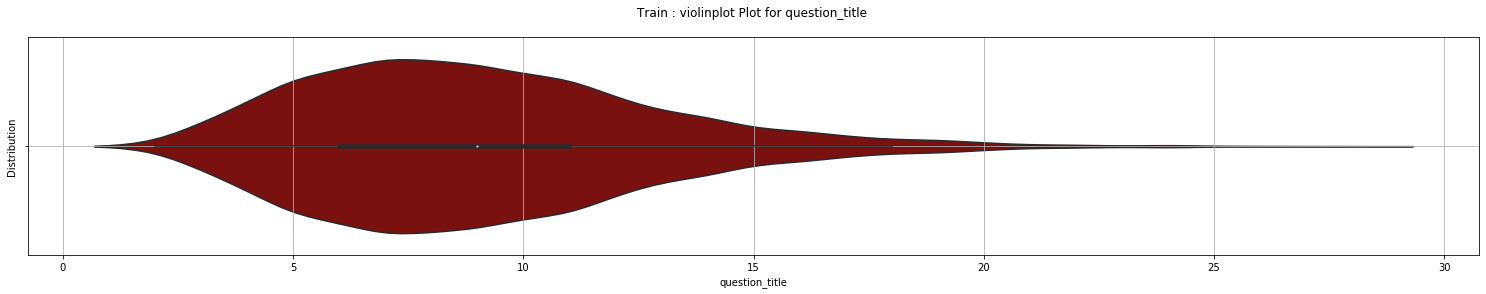

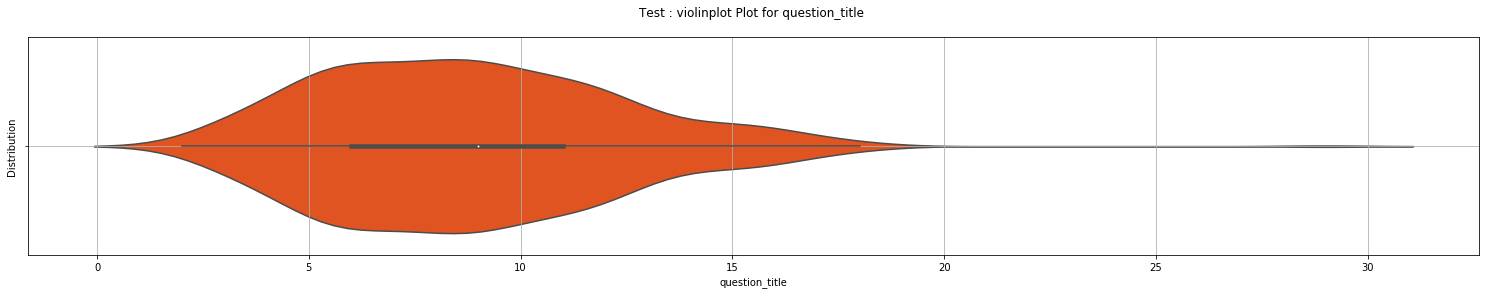

In [32]:
# Box plot of Length of question_title in train and test
box_plot(n_words_in_question_title_train, n_words_in_question_title_test, "question_title")

* Number of words in most of the question_title in train and test lies between ~ (2,20) words 
* Very few question_title has number of words greater than 20 making the plot skewed toward the right.
* It also looks like the number of words in question_title follows Normal distribution with slight skew toward the right. Let's find it out using Q-Q plot.

#### 5.4.3.2 Checking weather n_words_in_question_title follows normal distribution or not using Q-Q plot

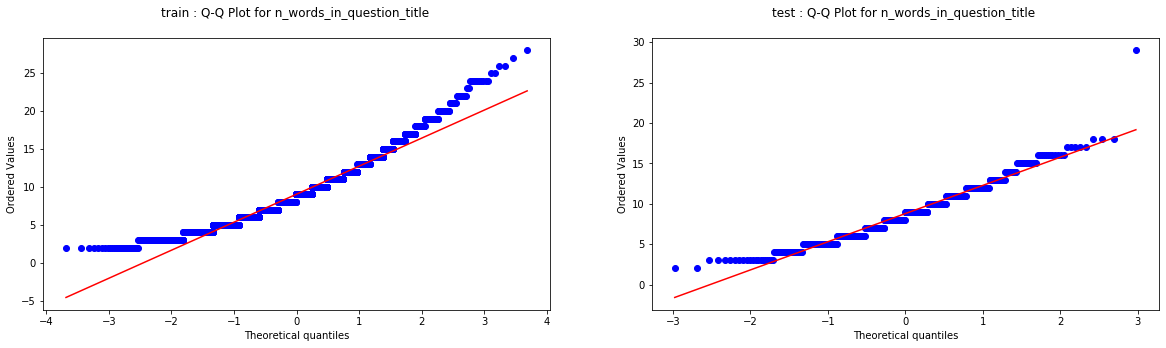

In [33]:
# Checking weather  n_words_in_question_title follows normal distribution using Q-Q plot
q_q_plot(n_words_in_question_title_train, n_words_in_question_title_test, "n_words_in_question_title")

* Number of words in question title does not follows normal distribution.

### 5.4.4 WordCloud of question_title in train and test 

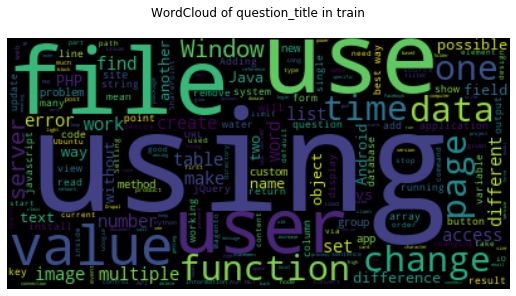

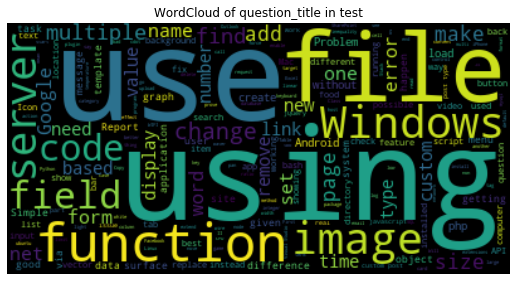

In [34]:
# refer: https://www.datacamp.com/community/tutorials/wordcloud-python

# For train_df
text_train = " ".join(word for word in train_df['question_title'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text_train)

# Display the generated image:
plt.figure(figsize=(9,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordCloud of question_title in train\n")
plt.axis("off")
plt.show()

#===================================================================

# For test_df
text_test = " ".join(word for word in test_df['question_title'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text_test)

# Display the generated image:
plt.figure(figsize=(9,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordCloud of question_title in test")
plt.axis("off")
plt.show()

* Ploting wordclouds of words without preprocessing roughly shows that there is huge similarity in words of question_title in both train and test data.
* Also most of the keywords looks alike they are in the contex of programing. So while doing preprocessing, we need to keep this in mind that we do not remove programing syntax from question_title thinking as unnecessary word.

### 5.4.5 Frequency of most popular words in train and test

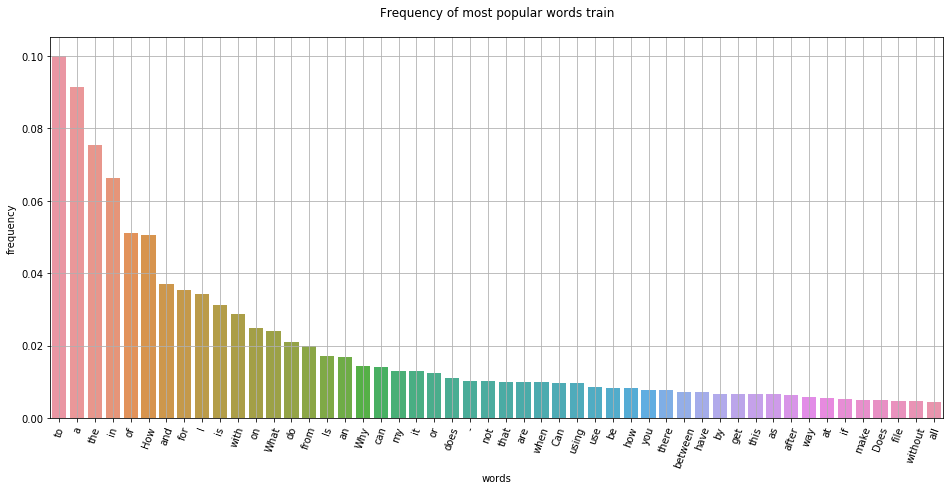

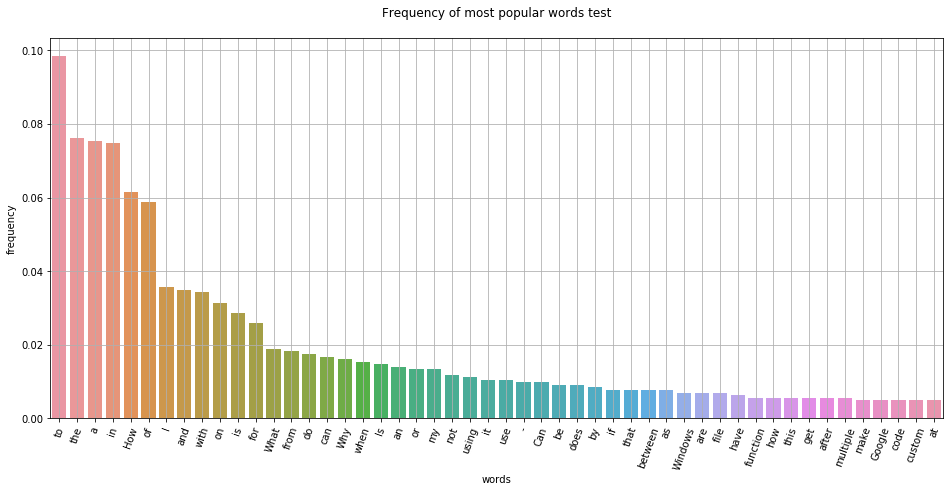

In [35]:
# Frequency of most popular 50 words in train_df
word_frequency_plot(train_df['question_title'], title='train')

# Frequency of most popular words in test_df
word_frequency_plot(test_df['question_title'], title='test')

* As I have not removed punctuations from question_title, most frequent words are punctuations. So we need to plot this graph again after removing punctuations from question_title for accurate word frequency plot.

###  5.4.6 Common question_title in both train and test

refer: https://www.kaggle.com/codename007/start-from-here-quest-complete-eda-fe

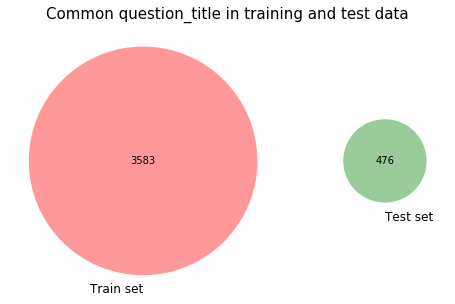

In [36]:
plt.figure(figsize=(9,5))
venn2([set(train_df['question_title'].unique()), set(test_df['question_title'].unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common question_title in training and test data", fontsize=15)
plt.show()


* There is no common question which is occured in both train and test.

## 5.5 EDA: Dependent variable question_body

### 5.5.1 Number of repeated question_body  in train and test

In [37]:
#Counts of repeated questions in train
train_df['question_body'].value_counts().values

array([12, 11, 11, ...,  1,  1,  1], dtype=int64)

In [38]:
#Counts of repeated questions in test
test_df['question_body'].value_counts().values

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

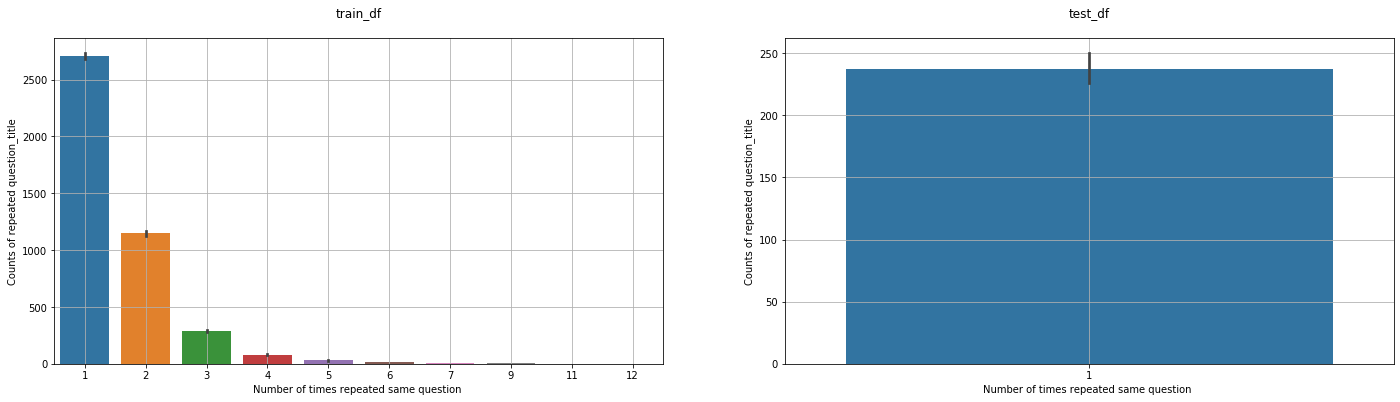

In [39]:
# Number of repeated question_body in train
n_repeated_question_body_train = train_df['question_body'].value_counts().values

# Number of repeated question_body in test
n_repeated_question_body_test = test_df['question_body'].value_counts().values

# plot for Number of repeated question_body in train and test
plot_bar(n_repeated_question_body_train, n_repeated_question_body_test,feature='question_title',x_label="Number of times repeated same question ",y_label="Counts of repeated")


* Obviously the plot for repeated question_body and repeated question_title are same. 
* This also indicates there is no repeated question having different question_title but same question_body or viceversa.

### 5.5.2 Length of question_body in train and test 

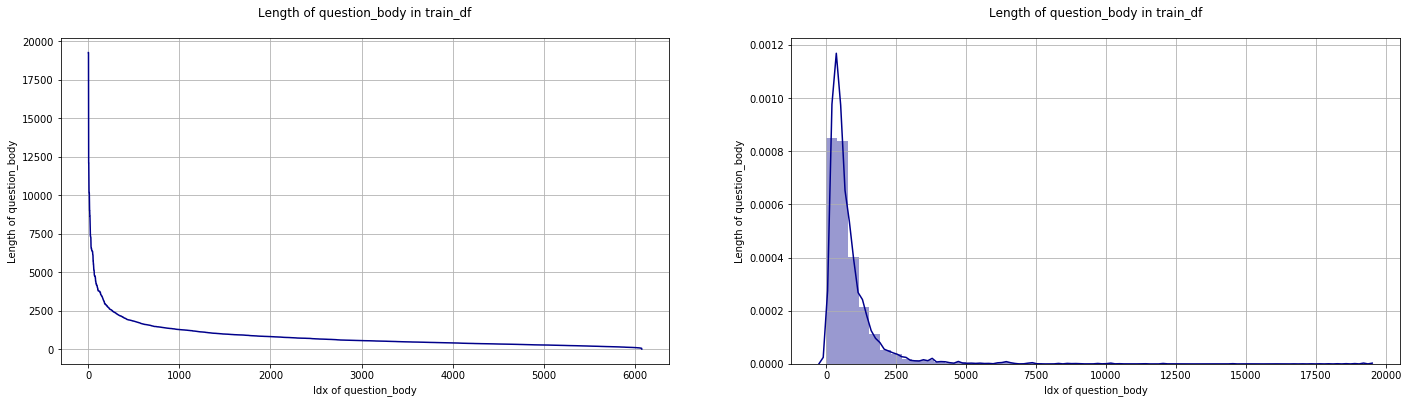

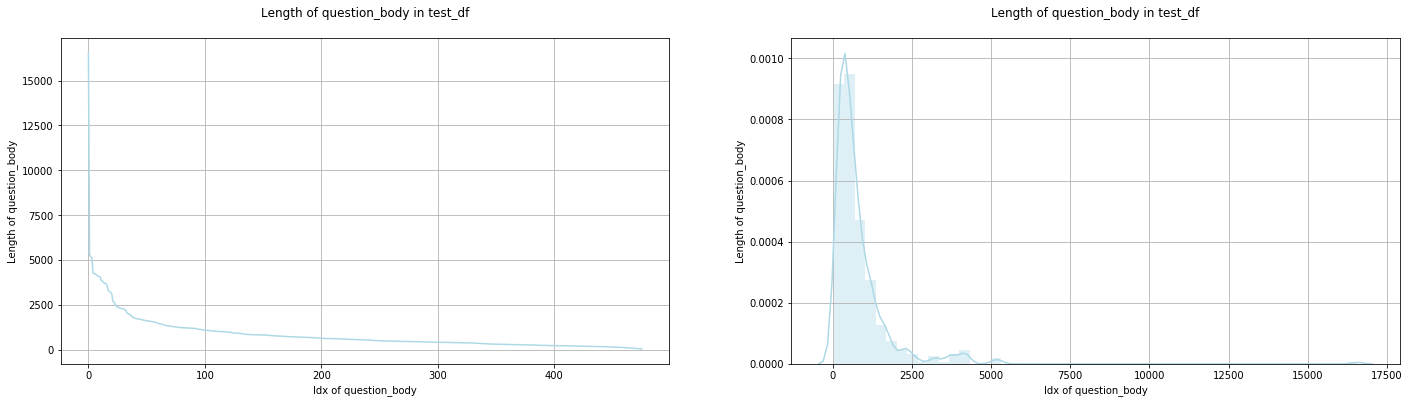

In [40]:
# Length of question_title in train
len_question_body_train = sorted(train_df['question_body'].apply(lambda x: len(x)),reverse=True)

# Length of question_title in test
len_question_body_test = sorted(test_df['question_body'].apply(lambda x: len(x)),reverse=True)

# plot for train_df
plot_sns(len_question_body_train,"question_body",color='darkblue',title='length',subtitle='train_df')

# plot for test_df
plot_sns(len_question_body_test,"question_body",color='lightblue',title='length',subtitle='test_df')


#### 5.5.2.1 Box plot of length of question_body

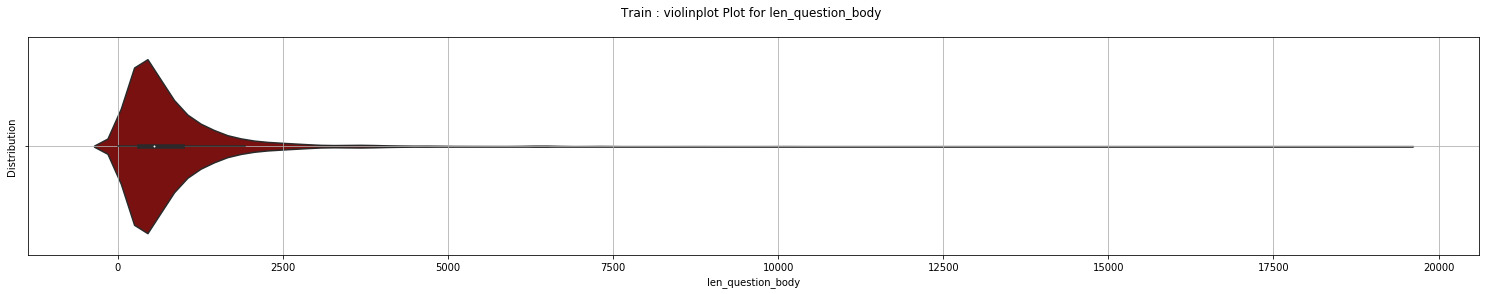

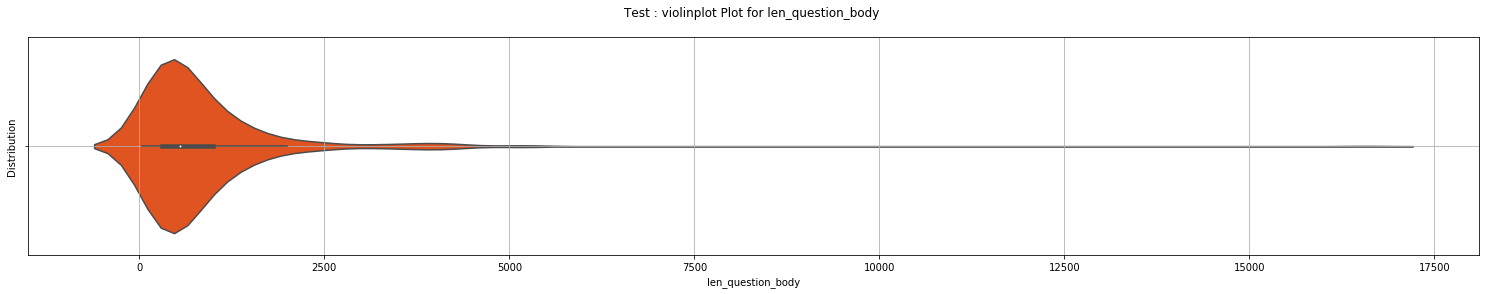

In [41]:
# Box plot of length of question_body
box_plot(len_question_body_train, len_question_body_test, "len_question_body" )

* The length of most of question_body in train and test is less than 2000 
* the distribution length of question_body is highly skewed towards right indicates that there are few question_body which has very large length( > 2000) .
* It looks like length of question_body follows log normal distribution. If yes, we can transform it to nomal distribution using Box-Cox transform and apply linear model on top of transformed feature for better result. 

#### 5.5.2.2 Box Cox transform of length of question_body and Q-Q plot of transformed feature

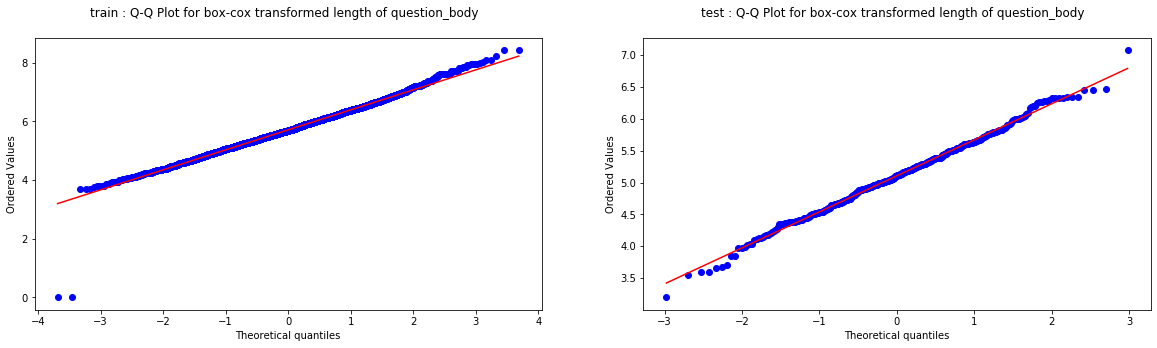

In [42]:
box_cox_len_question_body_train = boxcox(len_question_body_train)[0]
box_cox_len_question_body_test =  boxcox(len_question_body_test)[0]

train_df['box_cox_len_question_body'] = box_cox_len_question_body_train
test_df['box_cox_len_question_body'] = box_cox_len_question_body_test

# Checking weather box cox transformed len_question_body_box_cox follows normal distribution or not using Q-Q plot
q_q_plot(box_cox_len_question_body_train, box_cox_len_question_body_test, "box-cox transformed length of question_body ")

* Yes, It kinda look that Box Cox transfromed feature of len_question_body_box_cox_train roughly follows normal distribution


### 5.5.3 Number of words in question_body in train and test 

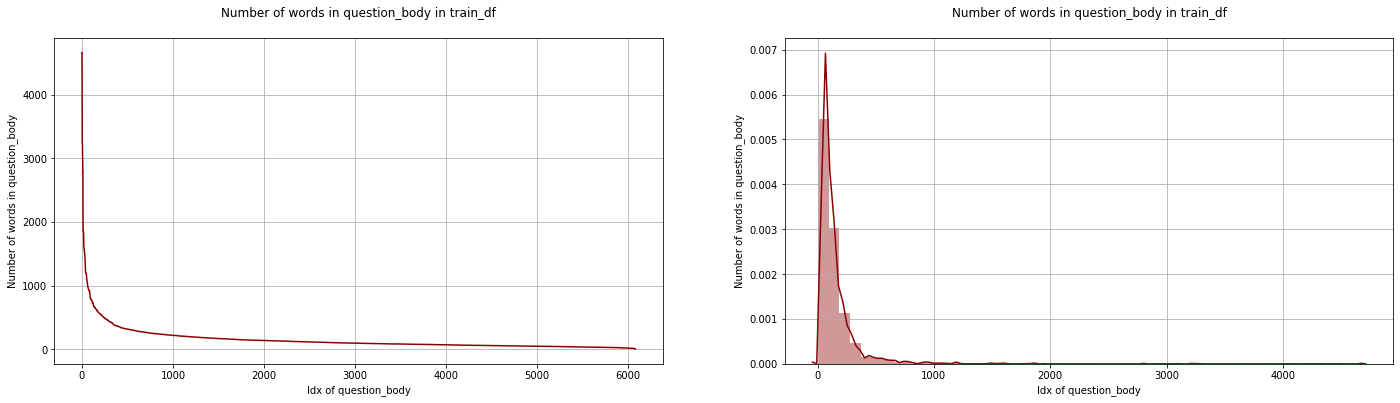

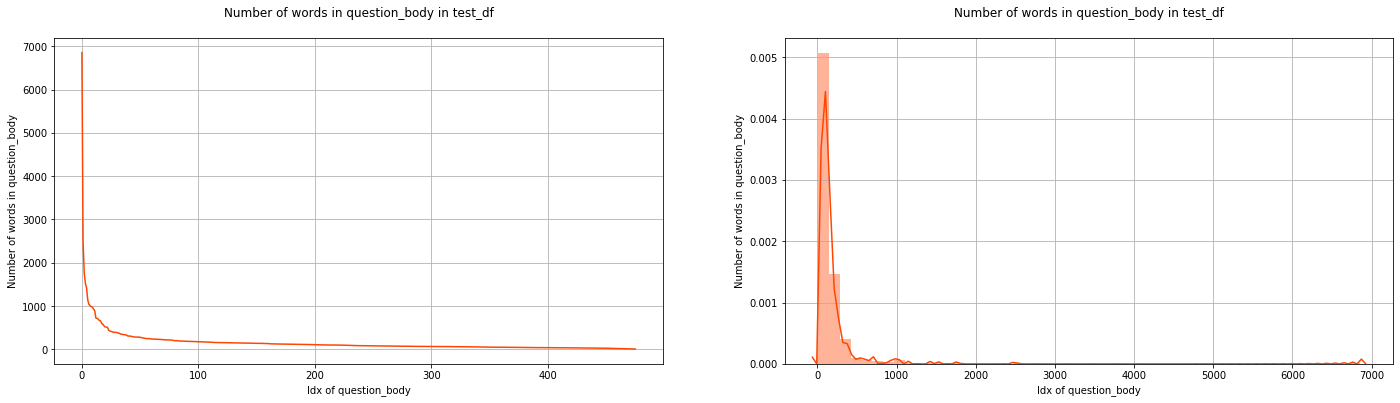

In [43]:
# number of words in question_title in train
n_words_in_question_body_train = sorted(train_df['question_body'].apply(lambda x: len(x.split(" "))),reverse=True)

# number of words in question_title in test
n_words_in_question_body_test = sorted(test_df['question_body'].apply(lambda x: len(x.split(" "))),reverse=True)

# plot for train_df
plot_sns(n_words_in_question_body_train,"question_body",color='darkred',title='number',subtitle='train_df')

# plot for test_df
plot_sns(n_words_in_question_body_test,"question_body",color='orangered',title='number',subtitle='test_df')

#### 5.5.3.1. Box plot of number of words in question_body

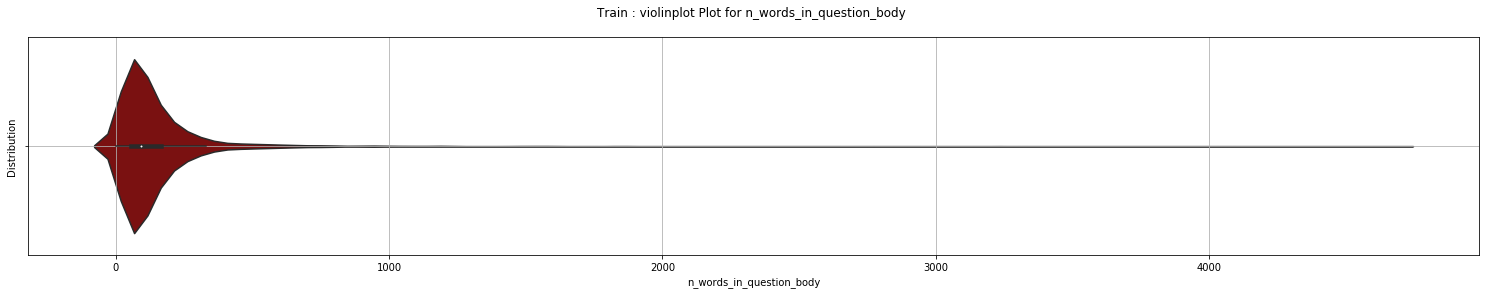

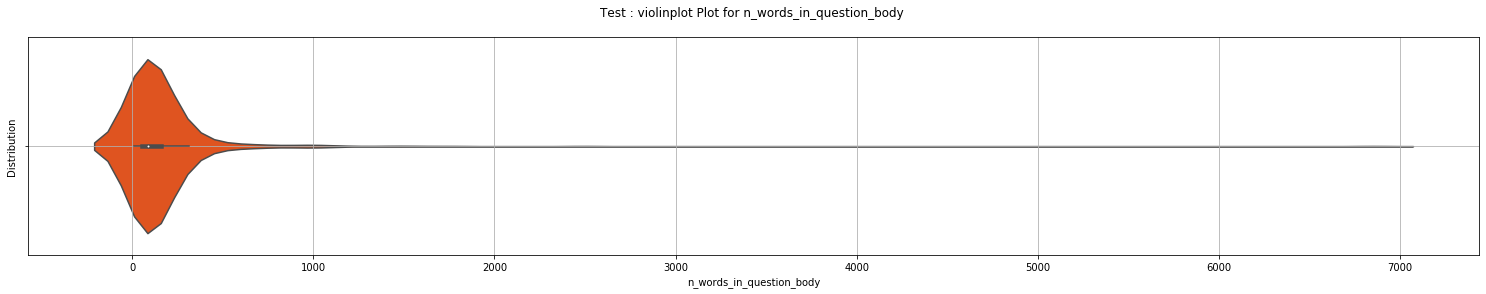

In [44]:
# Box plot of length of question_body
box_plot(n_words_in_question_body_train, n_words_in_question_body_test, "n_words_in_question_body" )

Observation: 

* The number of words in question_body in train and test is less than 500 
* the distribution number of words in question_body is highly skewed towards right indicates that there are few question_body which has very high number of words in question_body( greater than 500 and upto 7000 words). This could be because of some questions are from programming contex and the syntax of words maybe counted as indiviaudal word.
* It also looks like number of words in question_body follows log normal distribution. If yes, we can transform it to nomal distribution using Box-Cox transform and apply linear model on top of transformed feature for better result. 

#### 5.5.3.2 Box Cox transform of number of words in question_body and Q-Q plot of transformed feature

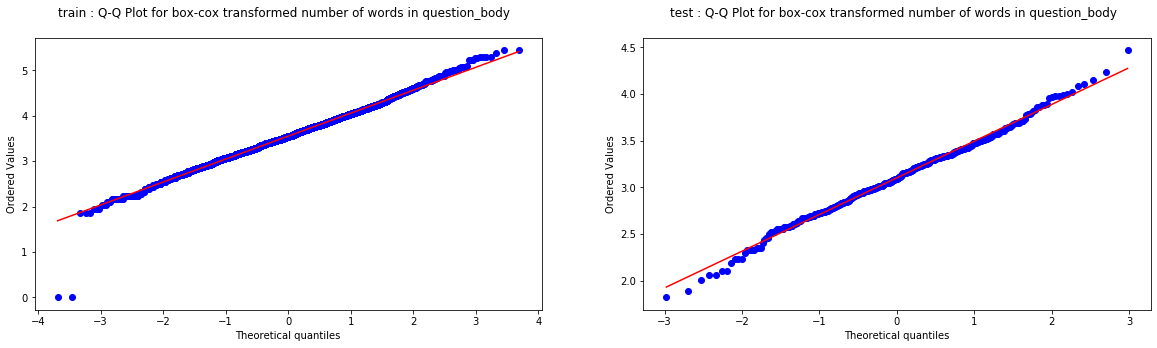

In [45]:
box_cox_n_words_in_question_body_train = boxcox(n_words_in_question_body_train)[0]
box_cox_n_words_in_question_body_test =  boxcox(n_words_in_question_body_test)[0]

# Saving box_cox_n_words_in_question_body as feature
train_df['box_cox_n_words_in_question_body'] = box_cox_n_words_in_question_body_train 
test_df['box_cox_n_words_in_question_body'] = box_cox_n_words_in_question_body_test

# Checking weather box cox transformed len_question_body_box_cox follows normal distribution or not using Q-Q plot
q_q_plot(box_cox_n_words_in_question_body_train, box_cox_n_words_in_question_body_test, "box-cox transformed number of words in question_body ")

* Yes, It kinda look that Box Cox transfromed feature of  number of words in question_body roughly follows normal distribution


### 5.5.4 WordCloud of question_body in train and test 

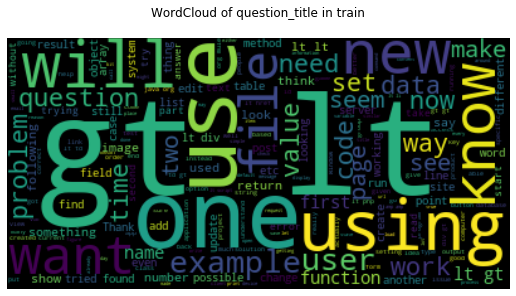

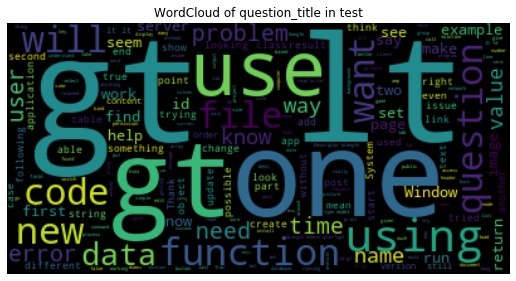

In [46]:
# refer: https://www.datacamp.com/community/tutorials/wordcloud-python

# For train_df
text_train = " ".join(word for word in train_df['question_body'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text_train)

# Display the generated image:
plt.figure(figsize=(9,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordCloud of question_title in train\n")
plt.axis("off")
plt.show()

#===================================================================

# For test_df
text_test = " ".join(word for word in test_df['question_body'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text_test)

# Display the generated image:
plt.figure(figsize=(9,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordCloud of question_title in test")
plt.axis("off")
plt.show()

* Wordclouds of words in question_body without preprocessing roughly shows that there is huge similarity in words of question_body in both train and test data.

* Just like keywords in question_title, here also  most of the keywords are in the contex of programing. So while doing preprocessing, we need to keep this in mind that we do not remove programing syntax from question_body.

### 5.5.5 Frequency of most popular worlds in question_body of train and test

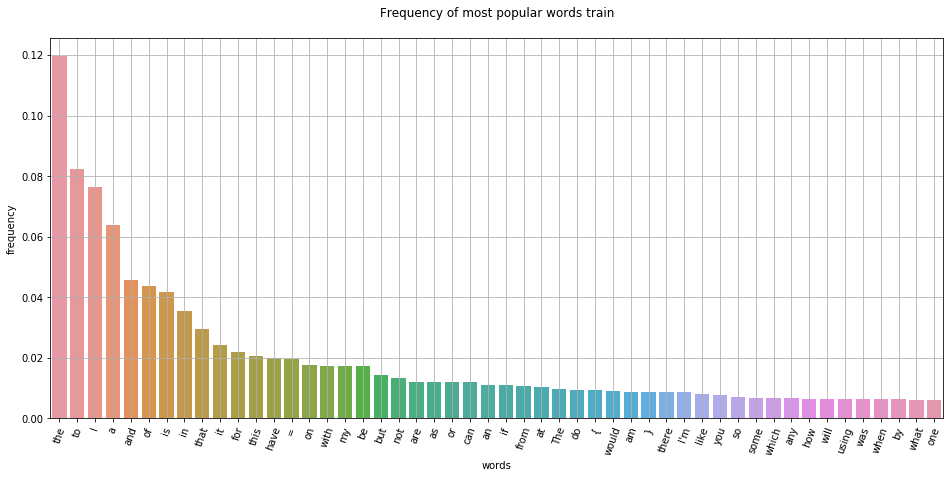

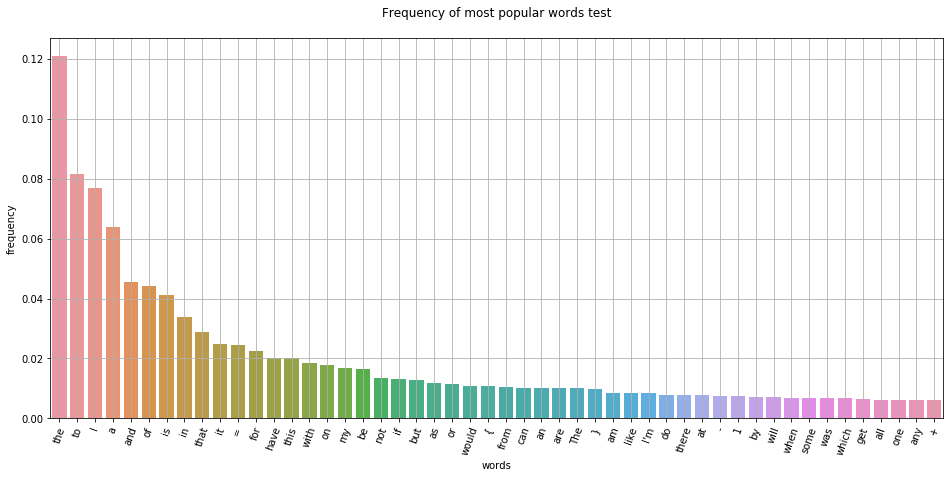

In [47]:
# Frequency of most popular worlds in question_body of train
word_frequency_plot(train_df['question_body'], title='train')

# Frequency of most popular worlds in question_body of test_df
word_frequency_plot(test_df['question_body'], title='test')

* As punctuations are not removed from question_body, most frequent words are either punctuations or programming syntax. So we need to plot this graph again after removing punctuations for accurate word frequency plot.

## 5.6 EDA : question_user_name feature

### 5.6.1 Distribution of question_user_name and number of question asked by user in train and test

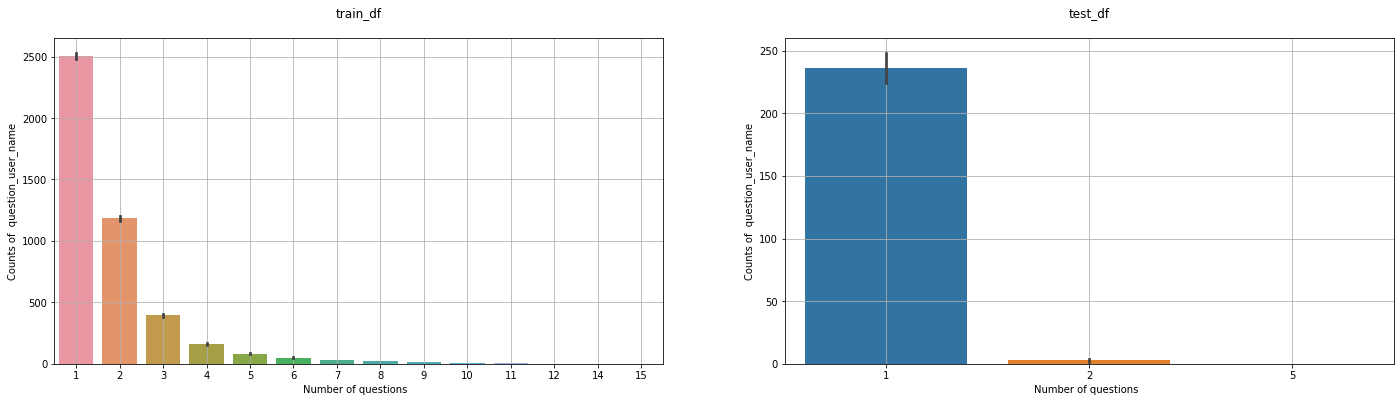

In [48]:
# for train_df
n_count_question_user_name_train=train_df['question_user_name'].value_counts().values

# for test_df
n_count_question_user_name_test=test_df['question_user_name'].value_counts().values

# plot for Distribution of counts question_user_name in train and test
plot_bar(n_count_question_user_name_train, n_count_question_user_name_test,feature='question_user_name',x_label="Number of questions  ",y_label="Counts of ")

### 5.6.2 Which user has asked most number of unique question based on question_title?

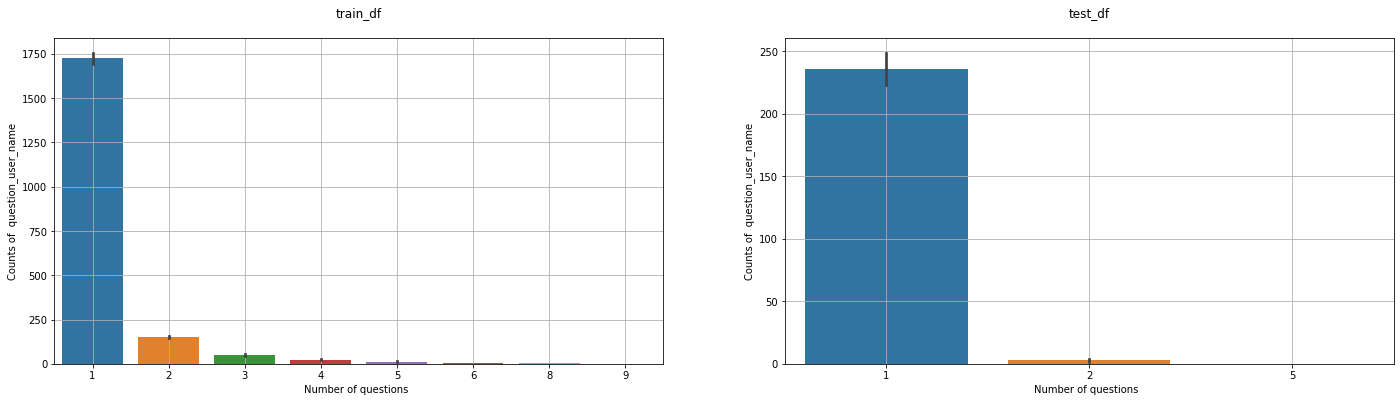

In [49]:
# for train_df
n_user_unique_question_train = train_df.drop_duplicates(subset=['question_title'])['question_user_name'].value_counts()

# for test_df
n_user_unique_question_test = test_df.drop_duplicates(subset=['question_title'])['question_user_name'].value_counts()

# plot for Which user has most number of unique question based on question_title?
plot_bar(n_user_unique_question_train.values, n_user_unique_question_test.values,feature='question_user_name',x_label="Number of questions  ",y_label="Counts of ")

* Most users has asked only one question in both train and test dataset.
* Few users has asked more than 1 questions (upto 9) in the train and (upto 5) in te test

#### Top 10 user who has asked most number of unique question

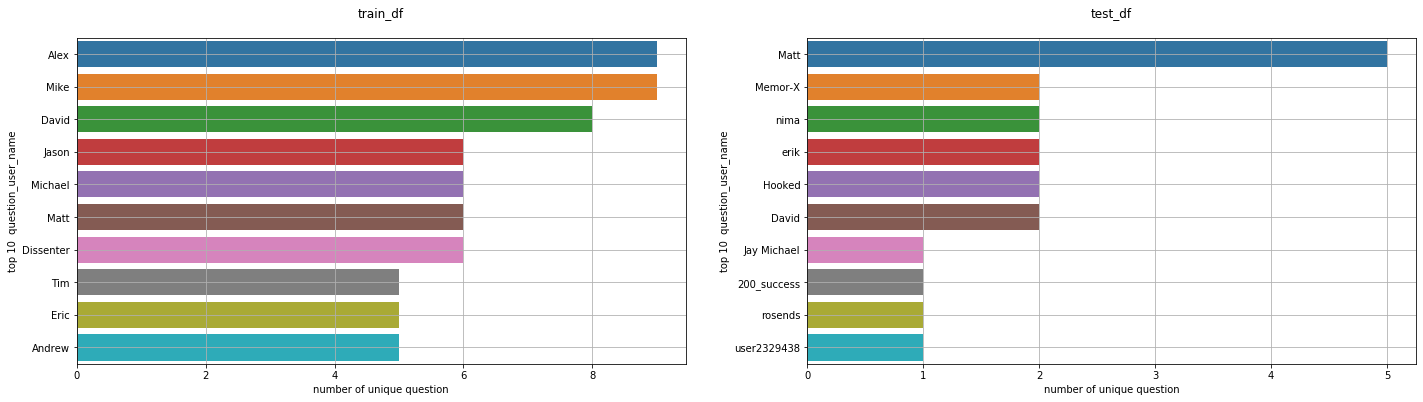

In [50]:
# Top 10 user who has asked most number of unique question
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

sns.barplot(n_user_unique_question_train[:10].values,n_user_unique_question_train[:10].index,ax=ax1)
ax1.set(xlabel = "number of unique question", ylabel=f"top 10  question_user_name", title='train_df\n')
ax1.grid()


sns.barplot(n_user_unique_question_test[:10].values,n_user_unique_question_test[:10].index , ax=ax2)
ax2.set(xlabel = "number of unique question", ylabel=f"top 10  question_user_name", title='test_df\n')
ax2.grid()
plt.show()

#### Description of number of unique question asked by user (train)

In [51]:
n_user_unique_question_train.describe()

count    3215.000000
mean        1.114463
std         0.511801
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         9.000000
Name: question_user_name, dtype: float64

#### Description of number of unique question asked by user (test)

In [52]:
n_user_unique_question_test.describe()

count    467.000000
mean       1.019272
std        0.211405
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        5.000000
Name: question_user_name, dtype: float64

## 5.6.3 Common unique question_user_name in train and test (Venn Diagram)

refer: https://www.kaggle.com/codename007/start-from-here-quest-complete-eda-fe

* A Venn diagram uses overlapping circles or other shapes to illustrate the logical relationships between two or more sets of items. Often, they serve to graphically organize things, highlighting how the items are similar and different.

#### Unique number of question_user_name

In [53]:
print(f"Unique number of question_user_name in Train : {len(train_df['question_user_name'].unique())}")
print(f"Unique number of question_user_name in Test : {len(test_df['question_user_name'].unique())}")

Unique number of question_user_name in Train : 3215
Unique number of question_user_name in Test : 467


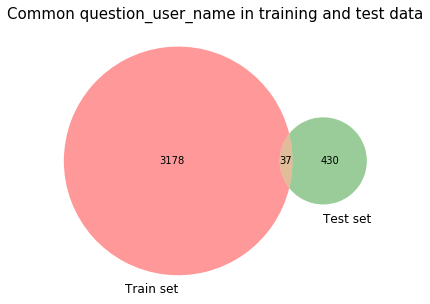

In [54]:
# Venn plot of  Common unique question_user_name in train and test
# refer: https://www.kaggle.com/codename007/start-from-here-quest-complete-eda-fe

plt.figure(figsize=(9,5))

venn2([set(train_df.question_user_name.unique()), set(test_df.question_user_name.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common question_user_name in training and test data", fontsize=15)
plt.show()

* There are 37  question_user_name who is present in both train and test data

## 5.6.4. User behaviour on question_title
* How many number of words user usually ask in question_title? 
* What is the minimum number of words in question_title asked by each user?
* Similary "max_title_len" , "mean_title_len" , "median_title_len" ?

#### For train_df

In [55]:
# Finding the unique question users asked unique questions based on question_title
unique_question_user_with_unique_questions = pd.DataFrame(train_df.groupby(['question_user_name',"question_title"])["question_title"].unique())
unique_question_user_with_unique_questions.reset_index(level=1,drop=True,inplace=True)
unique_question_user_with_unique_questions.reset_index(inplace=True)

# Find the number of words in each question_title asked by unique question_user
number_of_words = unique_question_user_with_unique_questions['question_title'].apply(lambda x : len(x[0].split()))
unique_question_user_with_unique_questions["number_of_words"] = number_of_words

# Apply aggrigation function( ) to find "sum","min","max","mean","median" of question_title asked by each unique question_user
unique_question_user_with_unique_questions_title_agg_train = unique_question_user_with_unique_questions.groupby('question_user_name')['number_of_words'].agg(["sum","min","max","mean","median"])
unique_question_user_with_unique_questions_title_agg_train = unique_question_user_with_unique_questions_title_agg_train.reset_index(level=0)

# Renaming column names
unique_question_user_with_unique_questions_title_agg_train.rename({'sum': 'sum_title_len', 'min': 'min_title_len', 'max': 'max_title_len', 'mean': 'mean_title_len', 'median': "median_title_len"}, axis=1, inplace=True)

# merging to train dataframe
train_df = pd.merge(left=train_df ,right=unique_question_user_with_unique_questions_title_agg_train ,how='inner',on="question_user_name")

#### for test_df


In [56]:
# Finding the unique question users asked unique questions based on question_title
unique_question_user_with_unique_questions = pd.DataFrame(test_df.groupby(['question_user_name',"question_title"])["question_title"].unique())
unique_question_user_with_unique_questions.reset_index(level=1,drop=True,inplace=True)
unique_question_user_with_unique_questions.reset_index(inplace=True)

# Find the number of words in each question_title asked by unique question_user
number_of_words = unique_question_user_with_unique_questions['question_title'].apply(lambda x : len(x[0].split()))
unique_question_user_with_unique_questions["number_of_words"] = number_of_words

# Apply aggrigation function( ) to find "sum","min","max","mean","median" of question_title asked by each unique question_user
unique_question_user_with_unique_questions_title_agg_test = unique_question_user_with_unique_questions.groupby('question_user_name')['number_of_words'].agg(["sum","min","max","mean","median"])
unique_question_user_with_unique_questions_title_agg_test = unique_question_user_with_unique_questions_title_agg_test.reset_index(level=0)

# Renaming column names
unique_question_user_with_unique_questions_title_agg_test.rename({'sum': 'sum_title_len', 'min': 'min_title_len', 'max': 'max_title_len', 'mean': 'mean_title_len', 'median': "median_title_len"}, axis=1, inplace=True)

# merging to test dataframe
test_df = pd.merge(left=test_df ,right=unique_question_user_with_unique_questions_title_agg_test ,how='inner',on="question_user_name")

#### Ploting user behaviour based on queston_titile


1: Plot for sum_title_len


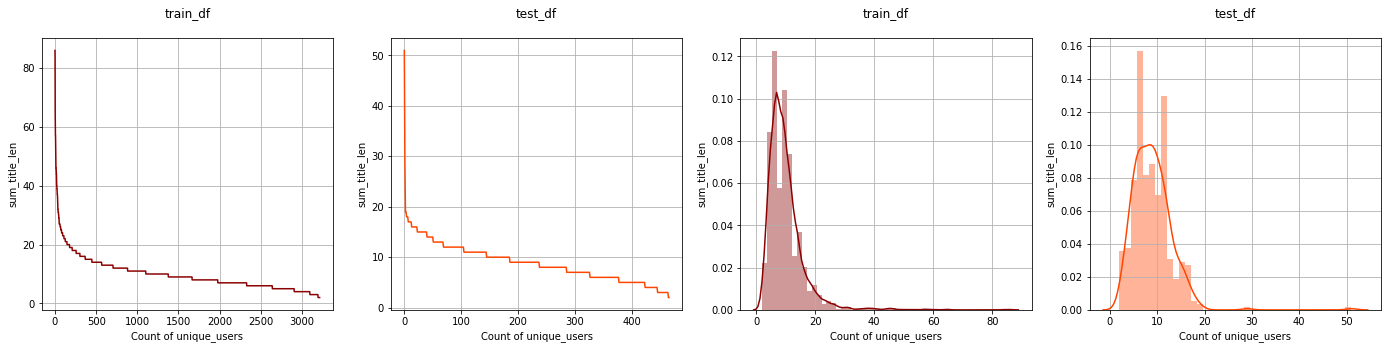


2: Plot for min_title_len


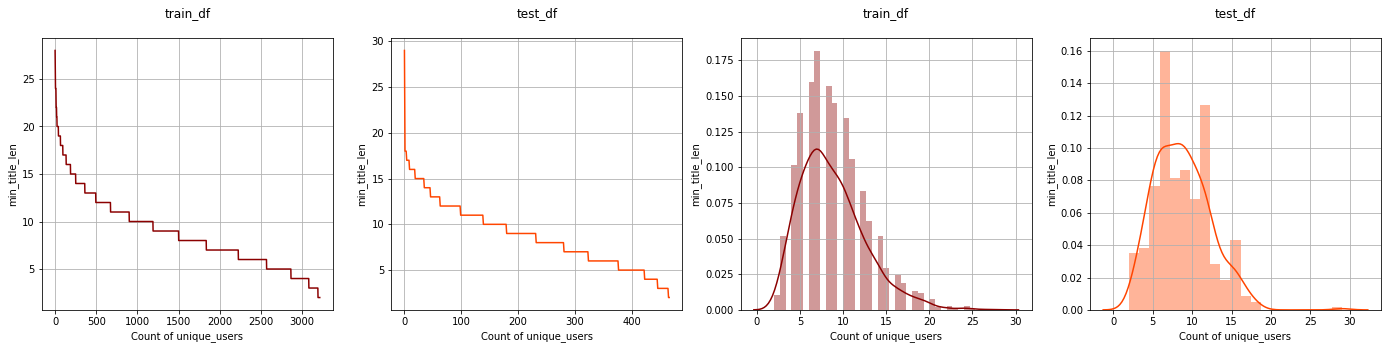


3: Plot for max_title_len


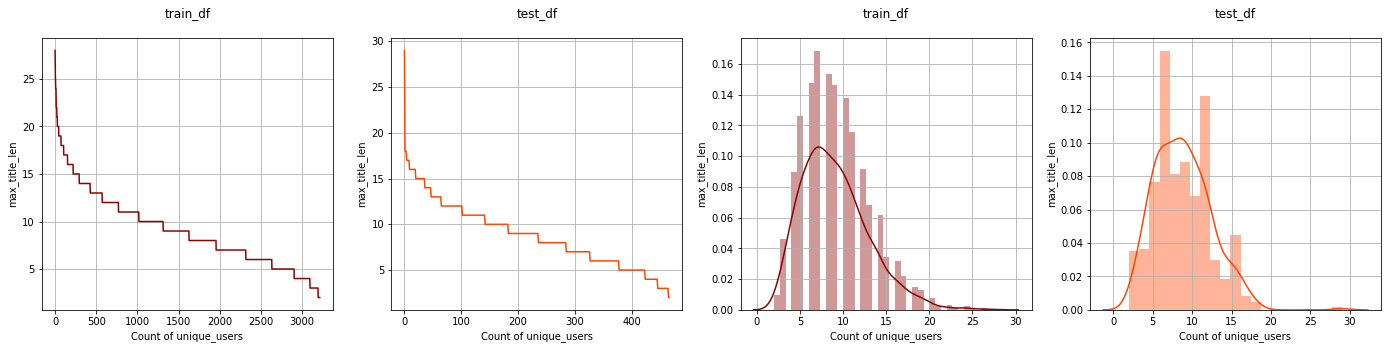


4: Plot for mean_title_len


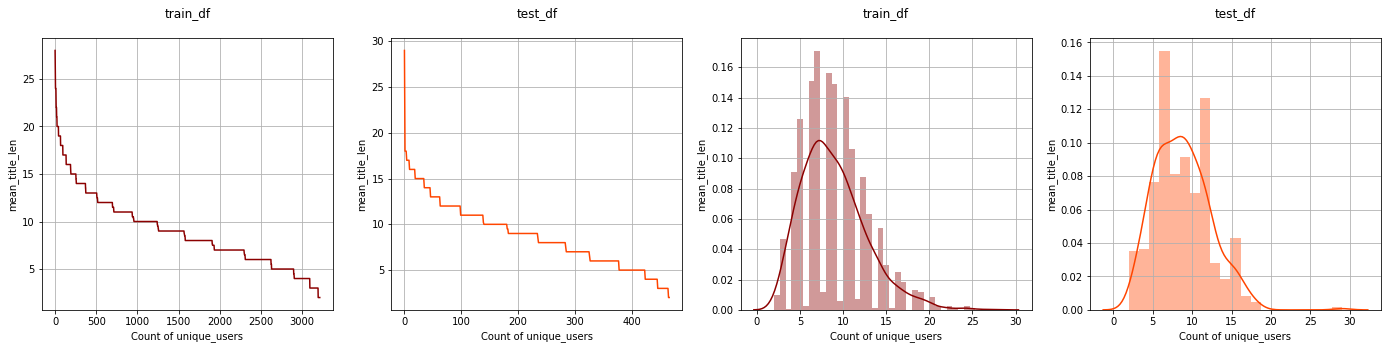


5: Plot for median_title_len


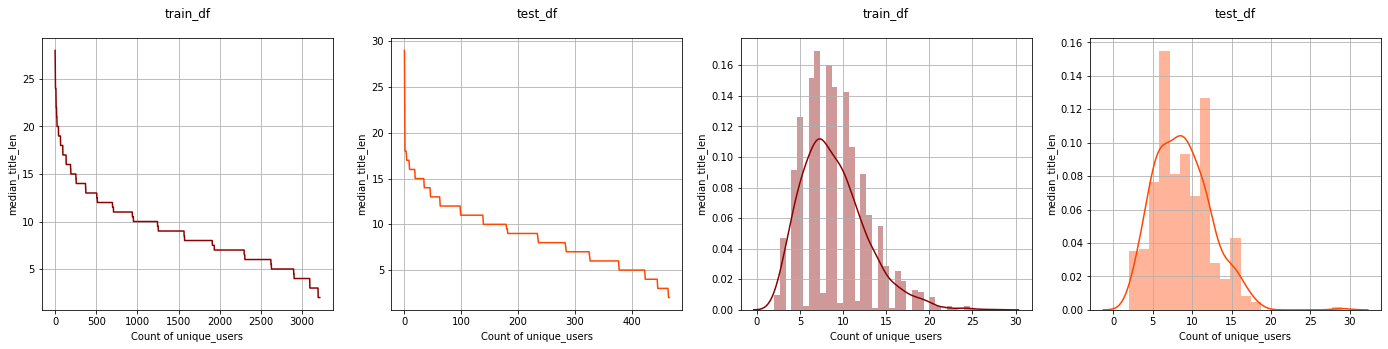

In [57]:
# Ploting user behaviour
user_behaviour_column_on_queston_titile = ['sum_title_len', 'min_title_len', 'max_title_len', 'mean_title_len','median_title_len']

for idx,column in enumerate(user_behaviour_column_on_queston_titile):
    
    train_set = unique_question_user_with_unique_questions_title_agg_train.sort_values(by= column ,ascending=False)[column]
    test_set = unique_question_user_with_unique_questions_title_agg_test.sort_values(by= column ,ascending=False)[column]
    
    print(f"\n{idx+1}: Plot for {column}")
    
    # Ploting lineplot for trainset
    f, (ax1, ax2 , ax3 , ax4 ) = plt.subplots(1, 4, figsize=(24,5))
    
    sns.lineplot(np.arange(len(train_set)), train_set,ax=ax1, color = "darkred")
    ax1.set(xlabel = "Count of unique_users", ylabel=f"{column}", title='train_df\n')
    ax1.grid()

    # Ploting lineplot for testset
    sns.lineplot(np.arange(len(test_set)), test_set,ax=ax2 ,color = "orangered")
    ax2.set(xlabel = "Count of unique_users", ylabel=f"{column}", title='test_df\n')
    ax2.grid()
    
    # Ploting distplot for trainset
    sns.distplot(train_set,ax=ax3, color = "darkred")
    ax3.set(xlabel = "Count of unique_users", ylabel=f"{column}", title='train_df\n')
    ax3.grid()

    # Ploting distplot for testset
    sns.distplot( test_set, ax=ax4 ,color = "orangered")
    ax4.set(xlabel = "Count of unique_users", ylabel=f"{column}", title='test_df\n')
    ax4.grid()
    plt.show()

* All of the plots are either sligtly or heavely skewed toward right 
* All these plots shows explicit behaviour of question_user_name on question_title and some of the plots even looks alike pareto distribution(80-20 rule), e.g. `Plot for sum_title_len`.
* Sum of user behaviour on queston_titile plots also looks like they follows log normal distribution.
* Let's Transfrom those features and check weather transformed feature follows Noraml distribution using Q-Q Plot.  

#### 5.6.4.1  Q-Q Plot of Box Cox transformed user_behaviour_column_on_queston_titile features


1: Q-Q Plot for box cox transformed feature of sum_title_len



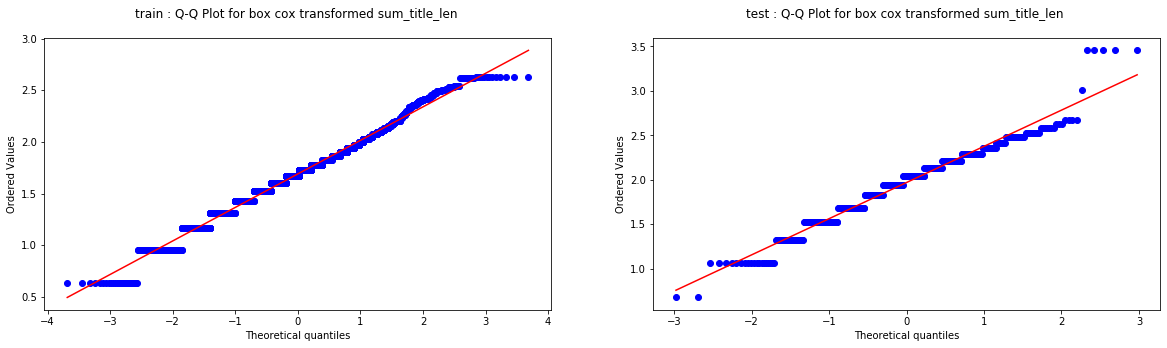


2: Q-Q Plot for box cox transformed feature of min_title_len



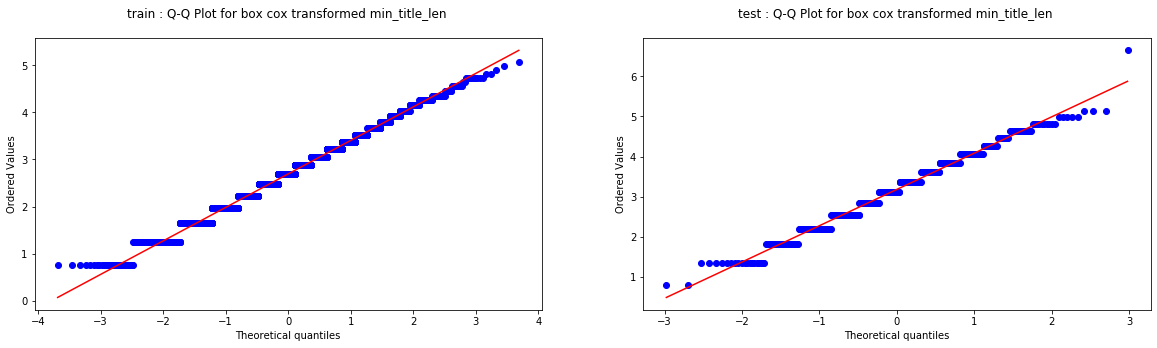


3: Q-Q Plot for box cox transformed feature of max_title_len



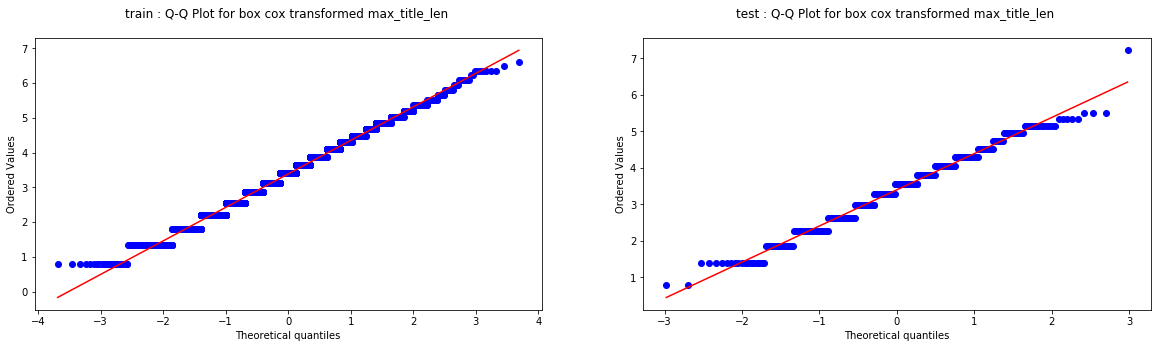


4: Q-Q Plot for box cox transformed feature of mean_title_len



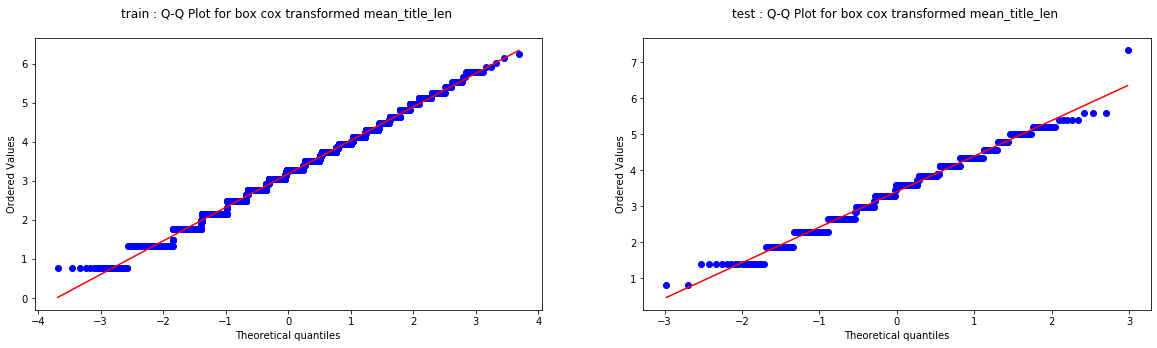


5: Q-Q Plot for box cox transformed feature of median_title_len



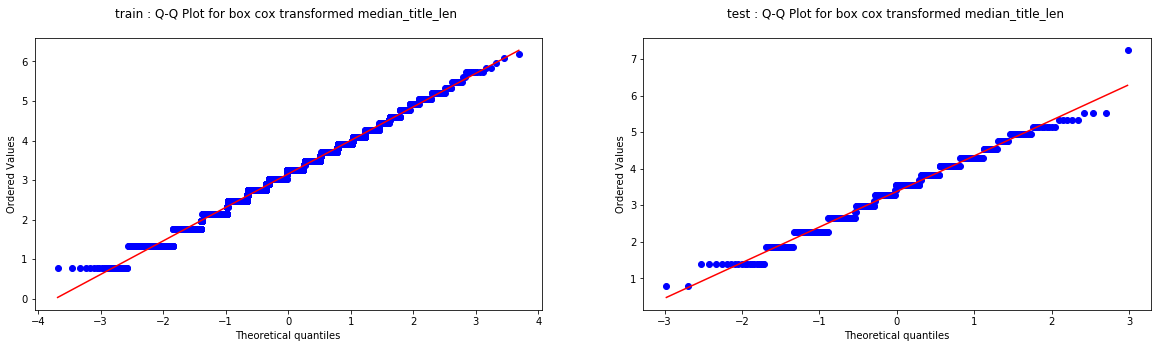

In [58]:
# Q-Q Plot of Box Cox transformed user_behaviour_column_on_queston_titile features
for idx,column_name in enumerate(user_behaviour_column_on_queston_titile):
    
    # Box Cox Transform
    boxcox_transformed_feature_train = boxcox(train_df[column_name])[0]
    boxcox_transformed_feature_test = boxcox(test_df[column_name])[0]
    
    # Saving the transformed user_behaviour_column_on_queston_titile column in dataframe
    train_df[f"boxcox_transformed_{column_name}"] = boxcox_transformed_feature_train
    test_df[f"boxcox_transformed_{column_name}"] = boxcox_transformed_feature_test
    
    print(f"\n{idx+1}: Q-Q Plot for box cox transformed feature of {column_name}\n")
    
    # Q-Q Plot of transformed Feature
    q_q_plot(boxcox_transformed_feature_train, boxcox_transformed_feature_test, f"box cox transformed {column_name}")
    

* Looking At above plots, It is not clear exactly that transformed features follows normal distribution or not.
* Let's just keep box cox transformed features and test these features importance while modeling

## 5.6.5. Question User behaviour on question_body
* How many number of words user usually ask in question_body? 
* What is the minimum number of words in question_title asked by each user?
* Similary "max_title_len" , "mean_title_len" , "median_title_len" ?

#### For train_df

In [59]:
# Finding the unique question users asked unique questions based on question_title
unique_question_user_with_unique_questions = pd.DataFrame(train_df.groupby(['question_user_name',"question_title"])["question_body"].unique())
unique_question_user_with_unique_questions.reset_index(level=1,drop=True,inplace=True)
unique_question_user_with_unique_questions.reset_index(inplace=True)

# Find the number of words in each question_title asked by unique question_user
number_of_words = unique_question_user_with_unique_questions['question_body'].apply(lambda x : len(x[0].split()))
unique_question_user_with_unique_questions["number_of_words"] = number_of_words

# Apply aggrigation function( ) to find "sum","min","max","mean","median" of question_title asked by each unique question_user
unique_question_user_with_unique_questions_body_agg_train = unique_question_user_with_unique_questions.groupby('question_user_name')['number_of_words'].agg(["sum","min","max","mean","median"])
unique_question_user_with_unique_questions_body_agg_train = unique_question_user_with_unique_questions_body_agg_train.reset_index(level=0)

# Renaming column names
unique_question_user_with_unique_questions_body_agg_train.rename({'sum': 'sum_body_len', 'min': 'min_body_len', 'max': 'max_body_len', 'mean': 'mean_body_len', 'median': "median_body_len"}, axis=1, inplace=True)

# merging to train dataframe
train_df = pd.merge(left=train_df ,right=unique_question_user_with_unique_questions_body_agg_train ,how='inner',on="question_user_name")

#### for test_df

In [60]:
# Finding the unique question users asked unique questions based on question_title
unique_question_user_with_unique_questions = pd.DataFrame(test_df.groupby(['question_user_name',"question_title"])["question_body"].unique())
unique_question_user_with_unique_questions.reset_index(level=1,drop=True,inplace=True)
unique_question_user_with_unique_questions.reset_index(inplace=True)

# Find the number of words in each question_title asked by unique question_user
number_of_words = unique_question_user_with_unique_questions['question_body'].apply(lambda x : len(x[0].split()))
unique_question_user_with_unique_questions["number_of_words"] = number_of_words

# Apply aggrigation function( ) to find "sum","min","max","mean","median" of question_title asked by each unique question_user
unique_question_user_with_unique_questions_body_agg_test = unique_question_user_with_unique_questions.groupby('question_user_name')['number_of_words'].agg(["sum","min","max","mean","median"])
unique_question_user_with_unique_questions_body_agg_test = unique_question_user_with_unique_questions_body_agg_test.reset_index(level=0)

# Renaming column names
unique_question_user_with_unique_questions_body_agg_test.rename({'sum': 'sum_body_len', 'min': 'min_body_len', 'max': 'max_body_len', 'mean': 'mean_body_len', 'median': "median_body_len"}, axis=1, inplace=True)

# merging to test dataframe
test_df = pd.merge(left=test_df ,right=unique_question_user_with_unique_questions_body_agg_test ,how='inner',on="question_user_name")

In [61]:
unique_question_user_with_unique_questions_body_agg_test

question_user_name  sum_body_len  min_body_len  max_body_len  \
0            0xC0000022L           102           102           102   
1               19greg96            90            90            90   
2            200_success            38            38            38   
3           Abe Miessler            46            46            46   
4    Abishek R Srikaanth            31            31            31   
..                   ...           ...           ...           ...   
462                 waka            31            31            31   
463               wfmn17           154           154           154   
464            wonderich           199           199           199   
465             wordfool            84            84            84   
466           yitznewton            24            24            24   

     mean_body_len  median_body_len  
0            102.0            102.0  
1             90.0             90.0  
2             38.0             38.0  
3             46.0             46.0  
4             31.0             31.0  
..             ...              ...  
462           31.0             31.0  
463          154.0            154.0  
464          199.0            199.0  
465           84.0             84.0  
466           24.0             24.0  

[467 rows x 6 columns]

#### Ploting user behaviour based on queston_body


1: Plot for sum_body_len


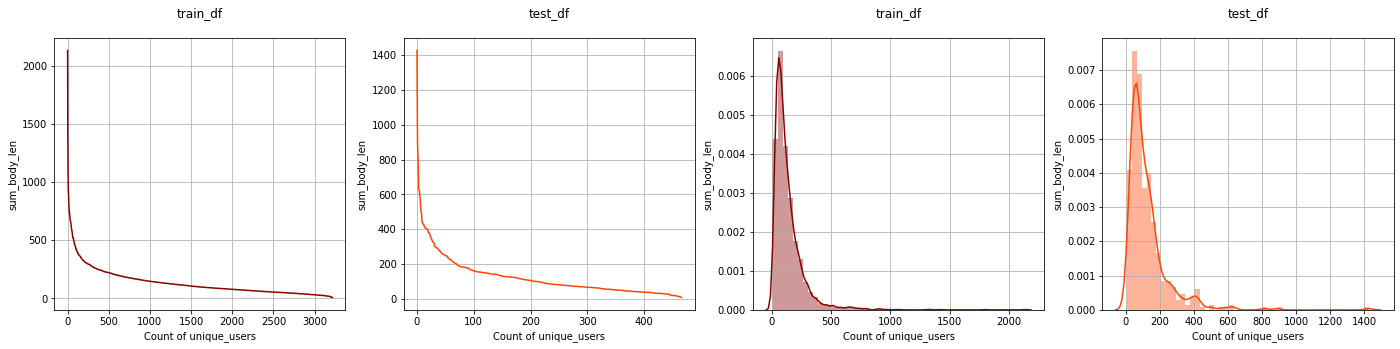


2: Plot for min_body_len


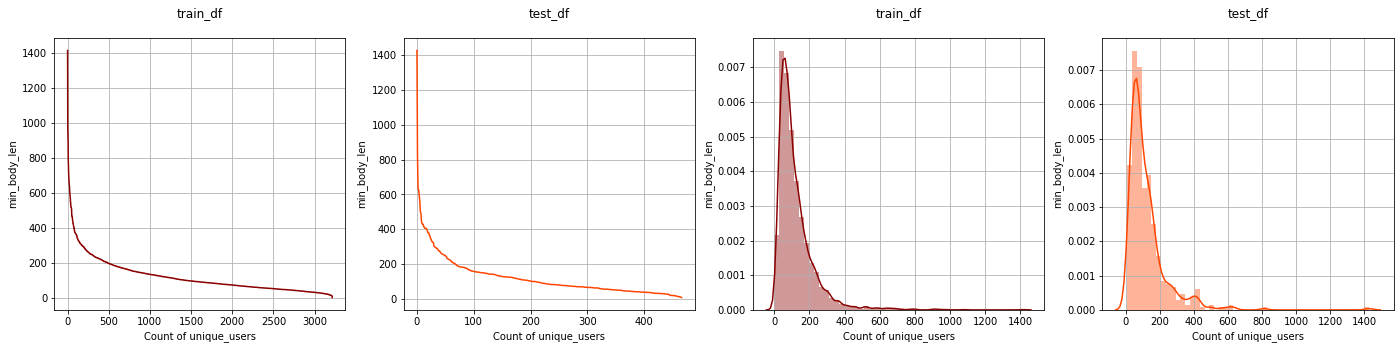


3: Plot for max_body_len


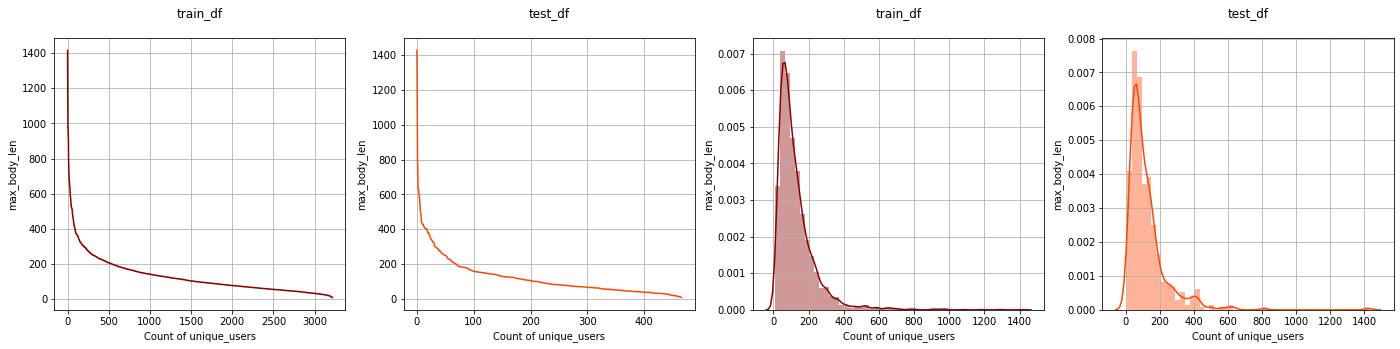


4: Plot for mean_body_len


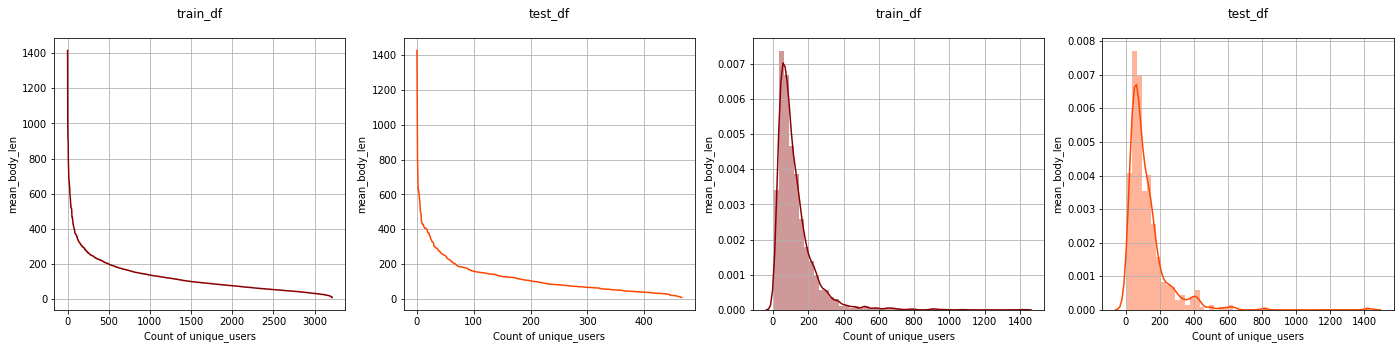


5: Plot for median_body_len


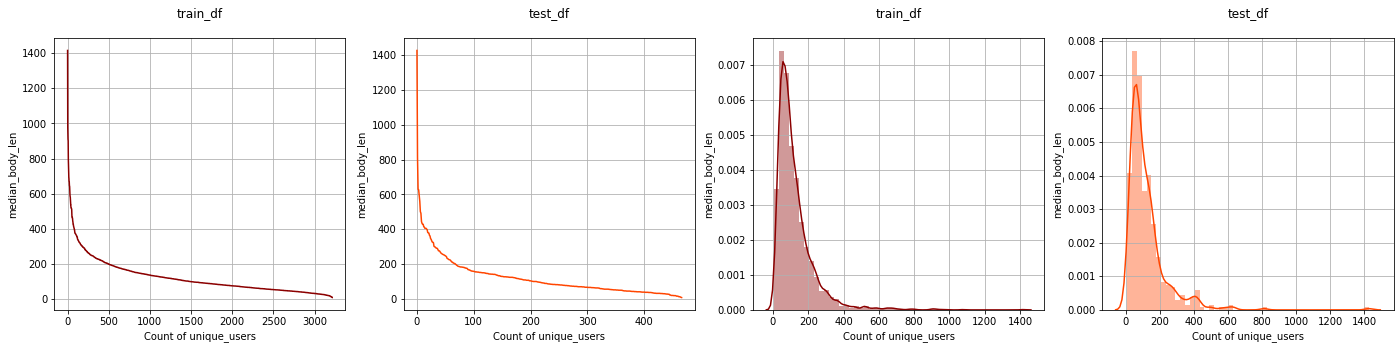

In [62]:
# Ploting user behaviour
user_behaviour_column_on_queston_body = ['sum_body_len', 'min_body_len', 'max_body_len', 'mean_body_len','median_body_len']

for idx,column in enumerate(user_behaviour_column_on_queston_body):
    
    train_set = unique_question_user_with_unique_questions_body_agg_train.sort_values(by= column ,ascending=False)[column]
    test_set = unique_question_user_with_unique_questions_body_agg_test.sort_values(by= column ,ascending=False)[column]
    
    print(f"\n{idx+1}: Plot for {column}")
    
    # Ploting lineplot for trainset
    f, (ax1, ax2 , ax3 , ax4 ) = plt.subplots(1, 4, figsize=(24,5))
    
    sns.lineplot(np.arange(len(train_set)), train_set,ax=ax1, color = "darkred")
    ax1.set(xlabel = "Count of unique_users", ylabel=f"{column}", title='train_df\n')
    ax1.grid()

    # Ploting lineplot for testset
    sns.lineplot(np.arange(len(test_set)), test_set,ax=ax2 ,color = "orangered")
    ax2.set(xlabel = "Count of unique_users", ylabel=f"{column}", title='test_df\n')
    ax2.grid()
    
    # Ploting distplot for trainset
    sns.distplot(train_set,ax=ax3, color = "darkred")
    ax3.set(xlabel = "Count of unique_users", ylabel=f"{column}", title='train_df\n')
    ax3.grid()

    # Ploting distplot for testset
    sns.distplot( test_set, ax=ax4 ,color = "orangered")
    ax4.set(xlabel = "Count of unique_users", ylabel=f"{column}", title='test_df\n')
    ax4.grid()
    plt.show()

* All the plots of users behaviour on queston_body are heavely skewed toward right.
* Transfrom these log normal alike features using box cox and check weather transformed features follows Noraml distribution or not using Q-Q plot

Feature name: sum_body_len
1: Q-Q Plot for box cox transformed feature of sum_body_len



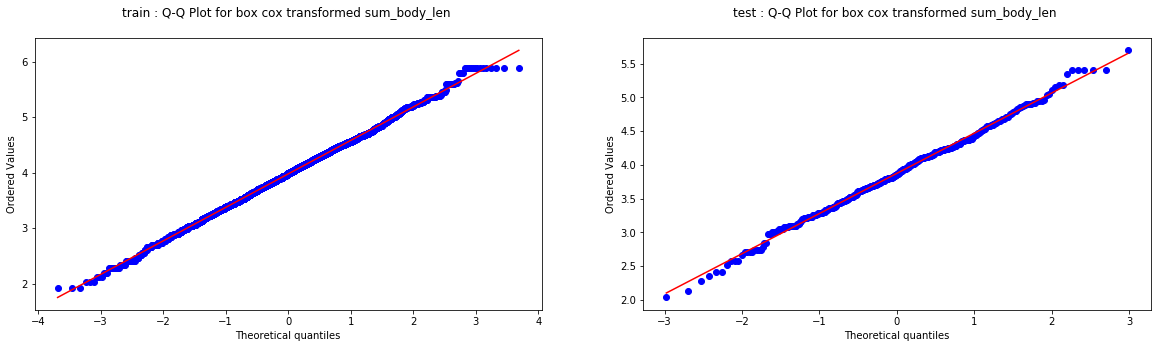

Feature name: min_body_len
2: Box Cox Transformation can not be applied on feature 'min_body_len' because all the values of data must be positive for transformation


Feature name: max_body_len
3: Q-Q Plot for box cox transformed feature of max_body_len



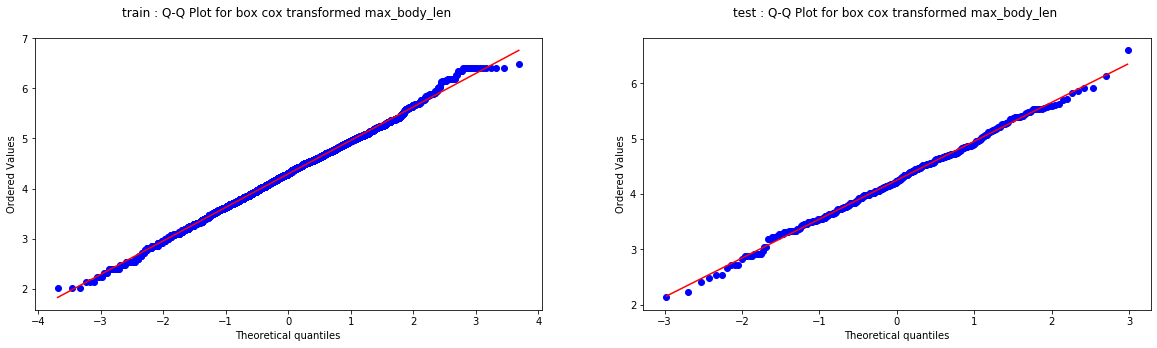

Feature name: mean_body_len
4: Q-Q Plot for box cox transformed feature of mean_body_len



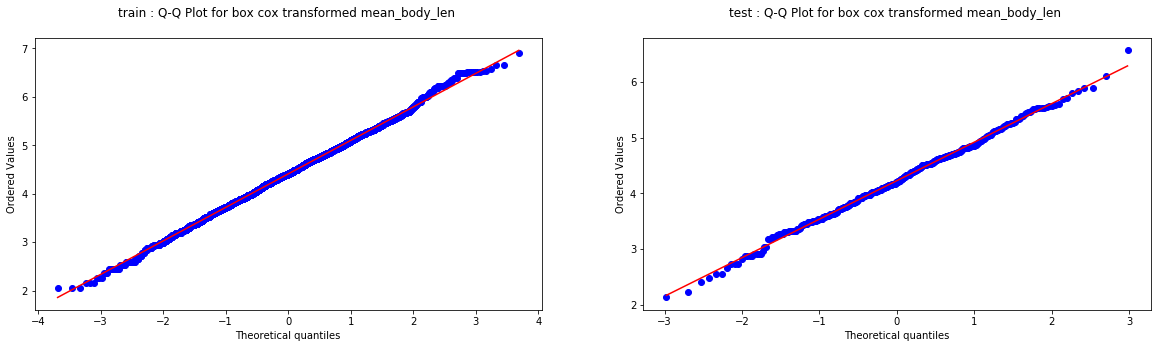

Feature name: median_body_len
5: Q-Q Plot for box cox transformed feature of median_body_len



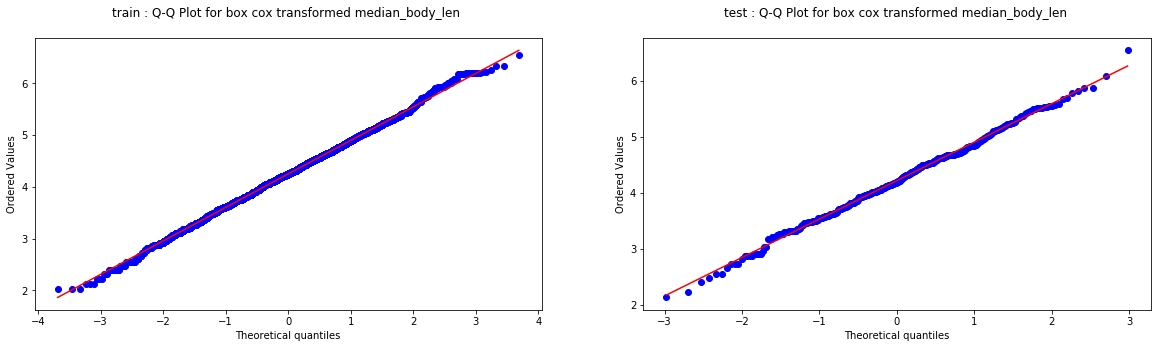

In [63]:
# Q-Q Plot of Box Cox transformed user_behaviour_column_on_queston_body features
for idx,column_name in enumerate(user_behaviour_column_on_queston_body):
    
    print(f"Feature name: {column_name}")
    
    # Continues the loop if box cox fails to transform
    if sum(train_df[f'{column_name}']<1)>0:
        print(f"{idx+1}: Box Cox Transformation can not be applied on feature '{column_name}' because all the values of data must be positive for transformation\n\n")
        continue

    # Box Cox Transform
    boxcox_transformed_feature_train = boxcox(train_df[column_name])[0]
    boxcox_transformed_feature_test = boxcox(test_df[column_name])[0]
    
             
    # Saving the transformed user_behaviour_column_on_queston_body column in dataframe
    train_df[f"boxcox_transformed_{column_name}"] = boxcox_transformed_feature_train
    test_df[f"boxcox_transformed_{column_name}"] = boxcox_transformed_feature_test
    
    print(f"{idx+1}: Q-Q Plot for box cox transformed feature of {column_name}\n")
    
    # Q-Q Plot of transformed Feature
    q_q_plot(boxcox_transformed_feature_train, boxcox_transformed_feature_test, f"box cox transformed {column_name}")
    

* Most of these Q-Q Plots do looks alike tey follows normal distribution. So just keep these transformed feature

## 5.7. EDA : answer Feature

### 5.7.1. Any same or repeated answer in train and test

In [64]:
n_repeated_answer_train = sum(train_df['answer'].value_counts().values>1)
n_repeated_answer_test = sum(test_df['answer'].value_counts().values>1)

print(f"Number of repeated answer in train: {n_repeated_answer_train}")
print(f"Number of repeated answer in test: {n_repeated_answer_test}")

Number of repeated answer in train: 0
Number of repeated answer in test: 0


### 5.7.2. Length of answer in train and test 

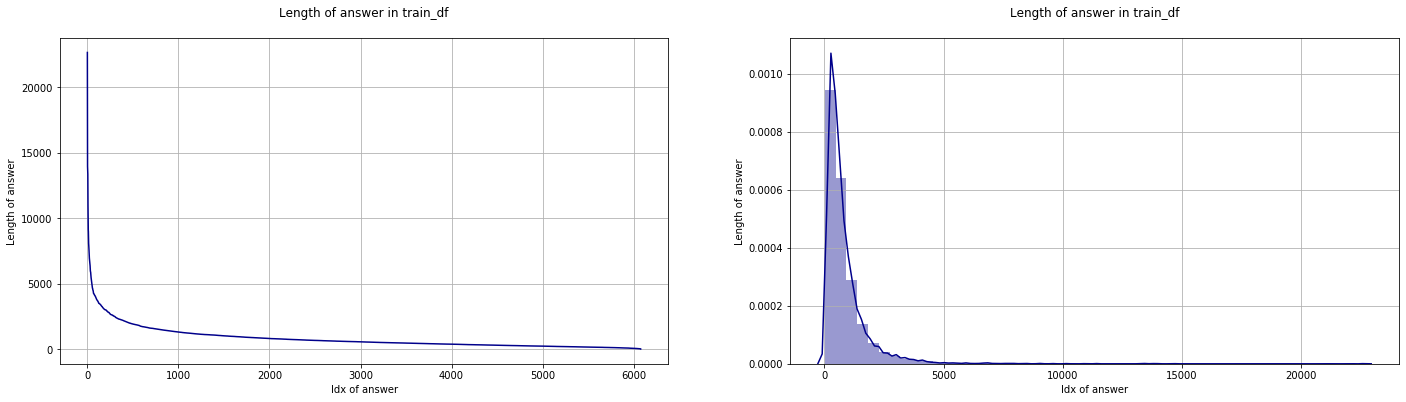

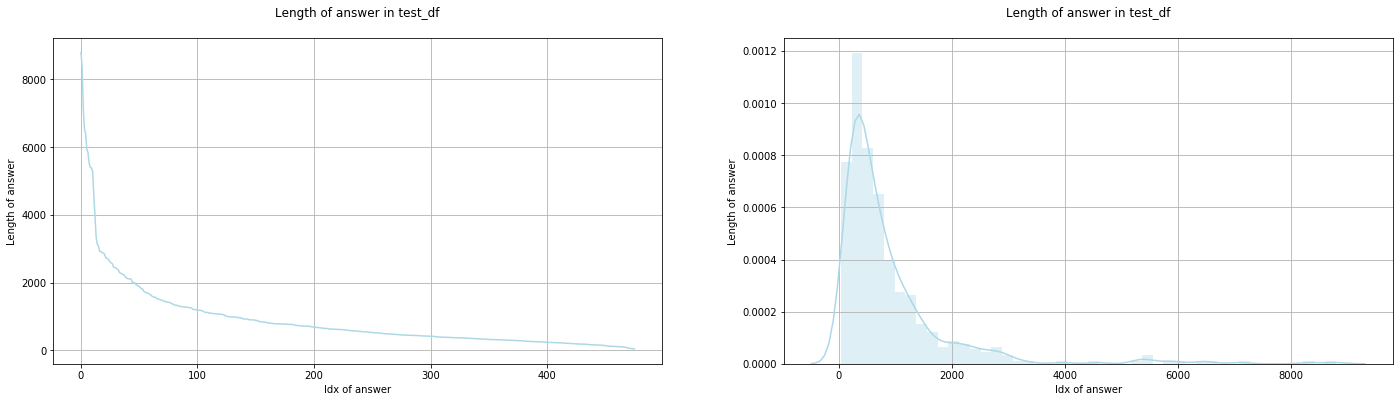

In [65]:
# Length of answer in train
len_answer_train = sorted(train_df['answer'].apply(lambda x: len(x)),reverse=True)

# Length of answer in test
len_answer_test = sorted(test_df['answer'].apply(lambda x: len(x)),reverse=True)

# plot for train_df
plot_sns(len_answer_train,"answer",color='darkblue',title='length',subtitle='train_df')

# plot for test_df
plot_sns(len_answer_test,"answer",color='lightblue',title='length',subtitle='test_df')


#### 5.7.2.1 Box plot of length of answers

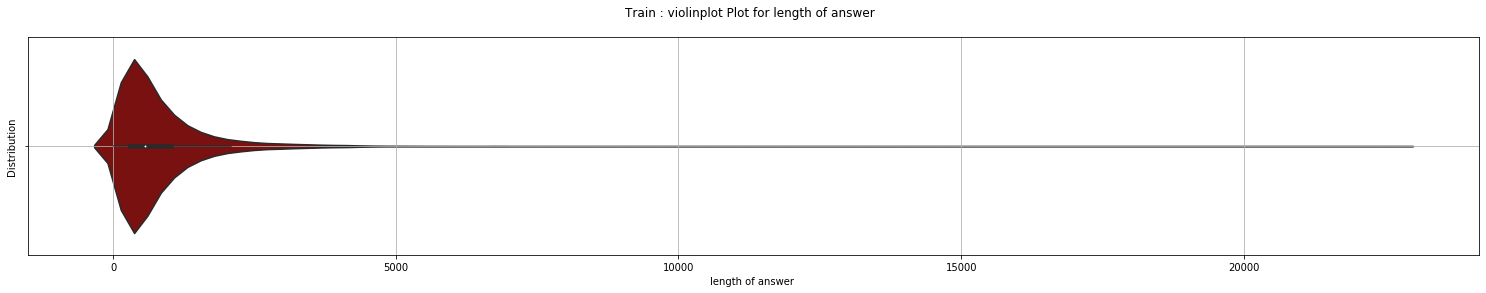

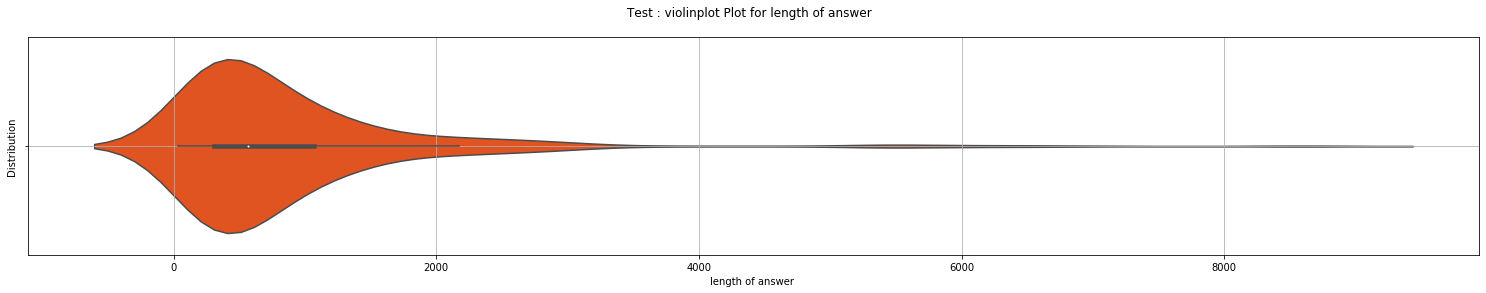

In [66]:
# Box plot of length of question_body
box_plot(len_answer_train, len_answer_test, "length of answer " )

* The length of most of answer in train and test is less than 2000 
* the distribution length of answer is highly skewed towards right indicates that there are few answer which has very large length( > 2000) . This could be becuase of reason that programming contex question has also the answer in coding format and having large set of syntax.
* It looks like length of answer follows log normal distribution. If yes, we can transform it to nomal distribution using Box-Cox transform and apply linear model on top of transformed feature for better result.  Let's Find it out.

#### 5.7.2.2 Box Cox transform of length of answer and Q-Q plot of transformed feature

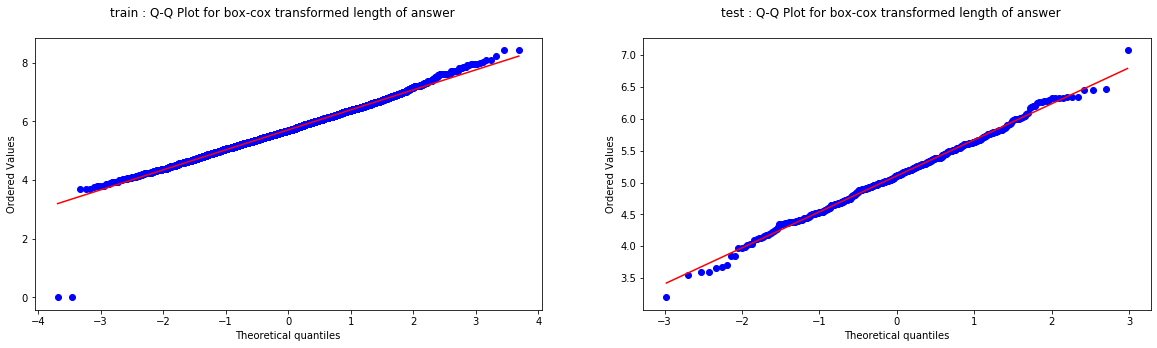

In [67]:
box_cox_len_answer_train = boxcox(len_answer_train)[0]
box_cox_len_answer_test =  boxcox(len_answer_test)[0]

train_df['box_cox_len_answer'] = box_cox_len_answer_train
test_df['box_cox_len_answer'] = box_cox_len_answer_test

# Checking weather box cox transformed len_question_body_box_cox follows normal distribution or not using Q-Q plot
q_q_plot(box_cox_len_question_body_train, box_cox_len_question_body_test, "box-cox transformed length of answer  ")

* Yes, It looks that Box Cox transfromed feature of len_answer follows normal distribution


### 5.7.3. Number of words in answer in train and test 

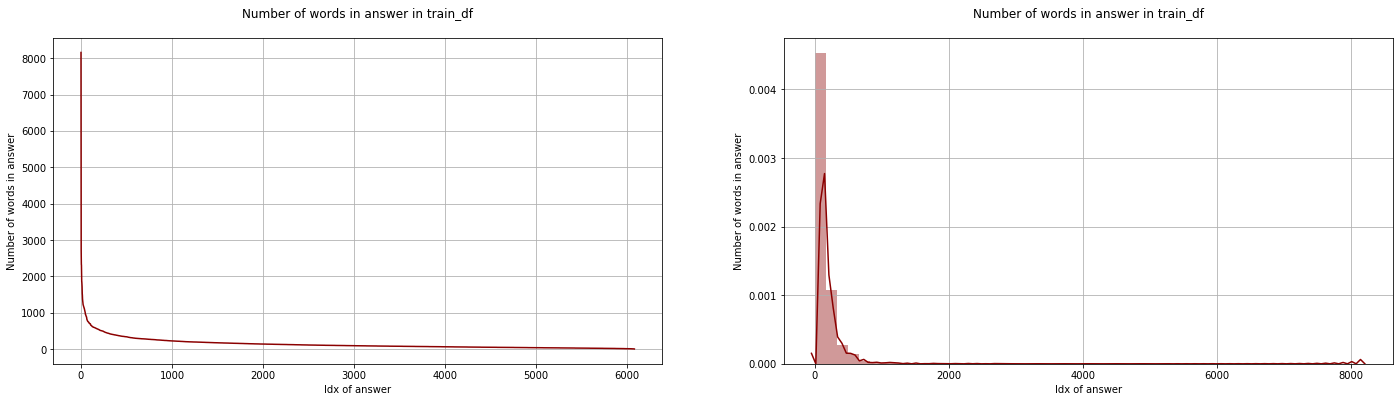

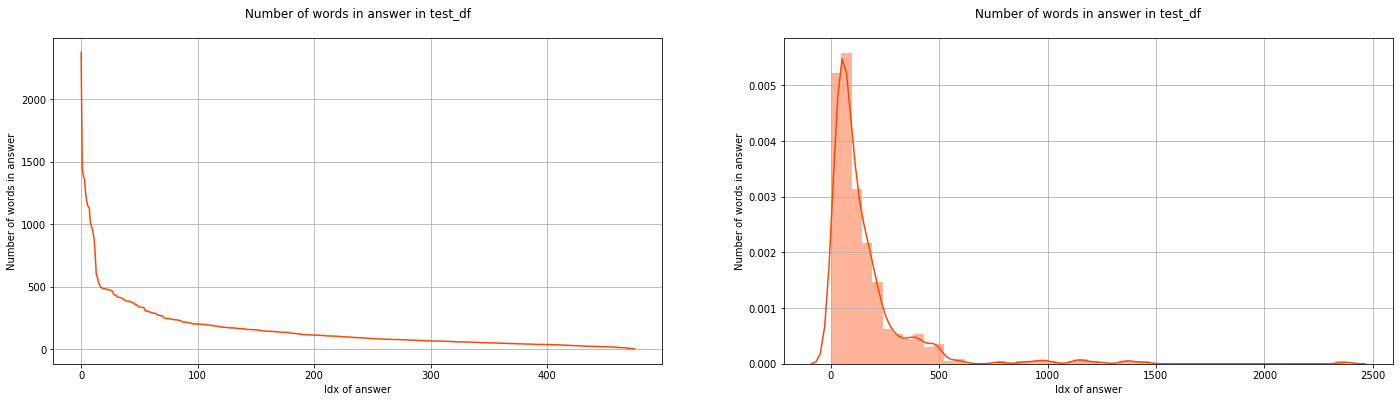

In [68]:
# number of words in answer in train
n_words_in_answer_train = sorted(train_df['answer'].apply(lambda x: len(x.split(" "))),reverse=True)

# number of words in answer in test
n_words_in_answer_test = sorted(test_df['answer'].apply(lambda x: len(x.split(" "))),reverse=True)

# plot for train_df
plot_sns(n_words_in_answer_train,"answer",color='darkred',title='number',subtitle='train_df')

# plot for test_df
plot_sns(n_words_in_answer_test,"answer",color='orangered',title='number',subtitle='test_df')


#### 5.7.3.1. Box plot of number of words in question_body

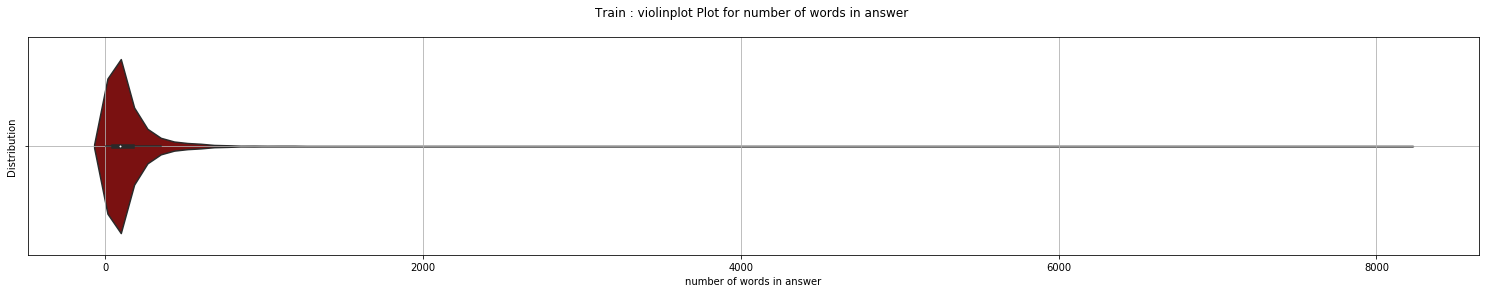

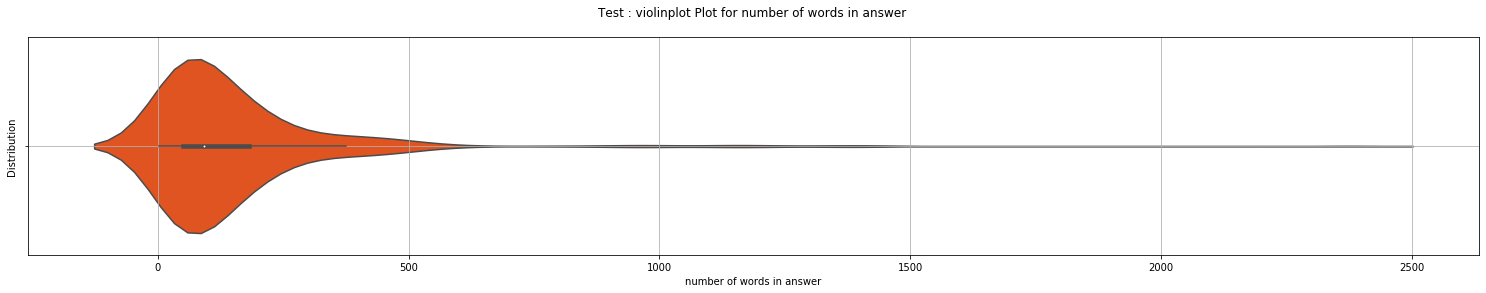

In [69]:
# Box plot of length of question_body
box_plot(n_words_in_answer_train, n_words_in_answer_test, "number of words in answer" )

* The number of words in answer in train and test is less than 400 

* the distribution number of words in answer is highly skewed towards right indicates that there are few question_body which has very high number of words in answer greater than 400 and upto 8000 words in train and upto 2500 in test.

* This could be because of some questions are from programming contex and the syntax of words maybe counted as indiviaudal word.

* It also looks like number of words in question_body follows log normal distribution. If yes, we can transform it to nomal distribution using Box-Cox transform and apply linear model on top of transformed feature for better result. 

#### 5.7.3.2 Box Cox transform of number of words in answer and Q-Q plot of transformed feature

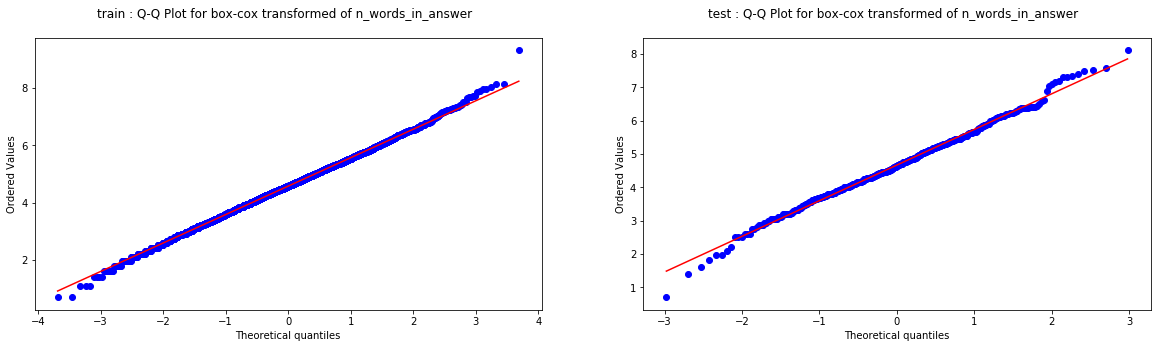

In [70]:
box_cox_n_words_in_answer_train = boxcox(n_words_in_answer_train)[0]
box_cox_n_words_in_answer_test =  boxcox(n_words_in_answer_test)[0]

train_df['box_cox_n_words_in_answer'] = box_cox_n_words_in_answer_train
test_df['box_cox_n_words_in_answer'] = box_cox_n_words_in_answer_test

# Checking weather box cox transformed len_question_body_box_cox follows normal distribution or not using Q-Q plot
q_q_plot(box_cox_n_words_in_answer_train, box_cox_n_words_in_answer_test, "box-cox transformed of n_words_in_answer ")

* It looks like box-cox transformed of n_words_in_answer follows normal distribution. So keep this feature and test this feature importance while modeling  

### 5.7.4. WordCloud of answer in train and test 

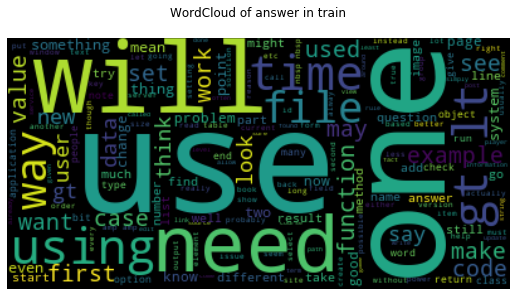

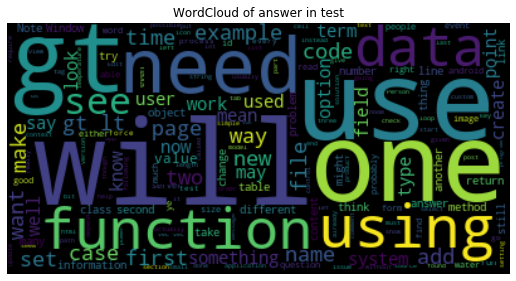

In [71]:
# refer: https://www.datacamp.com/community/tutorials/wordcloud-python

# For train_df
text_train = " ".join(word for word in train_df['answer'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text_train)

# Display the generated image:
plt.figure(figsize=(9,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordCloud of answer in train\n")
plt.axis("off")
plt.show()

#===================================================================

# For test_df
text_test = " ".join(word for word in test_df['answer'])

# Create and generate a word cloud image:
wordcloud = WordCloud().generate(text_test)

# Display the generated image:
plt.figure(figsize=(9,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("WordCloud of answer in test")
plt.axis("off")
plt.show()

* Wordclouds of words in answer without preprocessing roughly shows that there is huge similarity in words of question_body in both train and test data.

* Just like keywords in question_body, here also  most of the keywords are in the contex of programing. So while doing preprocessing, we need to keep this in mind that we do not remove programing syntax from answer.

### 5.7.5. Frequency of most popular worlds in answer of train and test

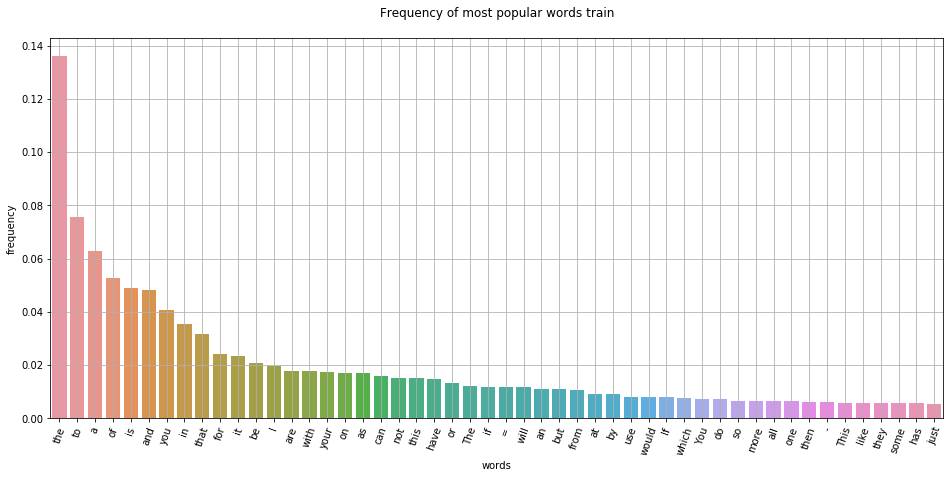

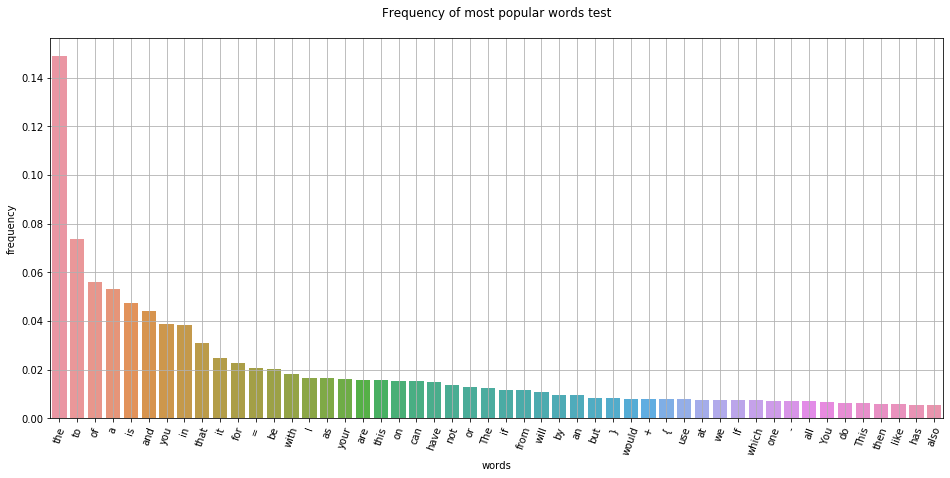

In [72]:
# Frequency of most popular worlds in answer of train
word_frequency_plot(train_df['answer'], title='train')

# Frequency of most popular worlds in answer of test_df
word_frequency_plot(test_df['answer'], title='test')

* As punctuations are not removed from anser, most frequent words are either punctuations or programming syntax. So we need to plot this graph again after removing punctuations for accurate word frequency plot.

## 5.8. EDA : answer_user_name feature

### 5.8.1. Distribution of answer_user and number of answer answerd by user in train and test

#### 5.8.1.1. Number of unique answer_user in train and test

In [73]:
# Number of unique answer_user in train and test
print(f'Number of unique answer_user in train: {len(train_df["answer_user_name"].unique())}')
print(f'Number of unique answer_user in test: {len(test_df["answer_user_name"].unique())}')

Number of unique answer_user in train: 4114
Number of unique answer_user in test: 363


#### 5.8.1.2. Common answer_user in both train and test

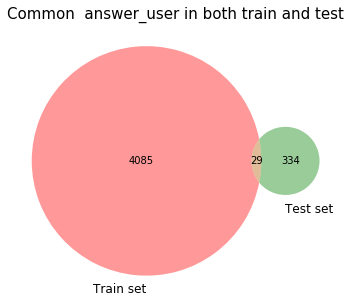

In [74]:
plt.figure(figsize=(9,5))
venn2([set(train_df.answer_user_name.unique()), set(test_df.answer_user_name.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common  answer_user in both train and test", fontsize=15)
plt.show()

* There are 29 answer_user_name which is common in both train and test.

#### 5.8.1.3. Number of answer given by users

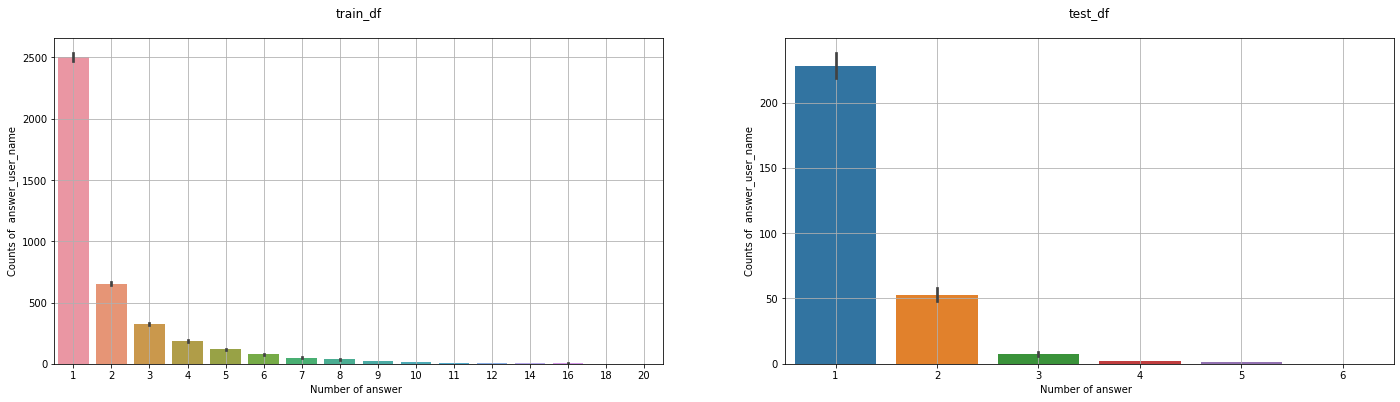

In [75]:
# for train_df
n_count_answer_user_name_train=train_df['answer_user_name'].value_counts().values

# for test_df
n_count_answer_user_name_test=test_df['answer_user_name'].value_counts().values

# plot for Distribution of counts answer_user_name in train and test
plot_bar(n_count_answer_user_name_train, n_count_answer_user_name_test,feature='answer_user_name',x_label="Number of answer  ",y_label="Counts of ")

### 5.8.2. Number of users who has answered most number of unique question?

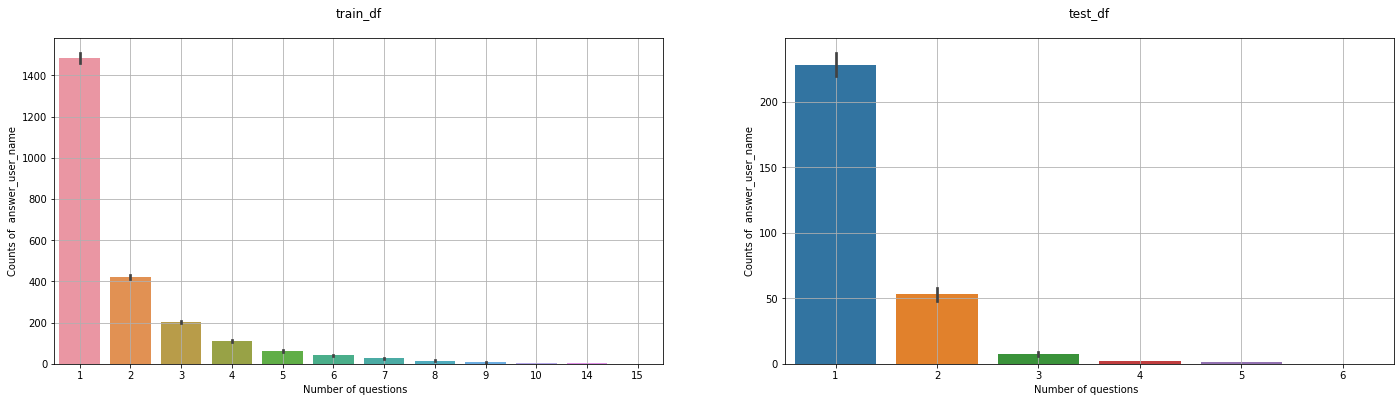

In [76]:
# for train_df
n_user_unique_answer_train = train_df.drop_duplicates(subset=['question_title'])['answer_user_name'].value_counts()

# for test_df
n_user_unique_answer_test = test_df.drop_duplicates(subset=['question_title'])['answer_user_name'].value_counts()

# plot of Which user has answered most number of unique question based on question_title?
plot_bar(n_user_unique_answer_train.values, n_user_unique_answer_test.values,feature='answer_user_name',x_label="Number of questions  ",y_label="Counts of ")

* This plot and above this plot indicates that there are few users in dataset who has answered the same question more than once but answer is different.

* Just like we have seen in question_users, here also mostly answer_users has answerd only on question.
 
* And very few answer_users has answerd large number of questions upto 15 in train data and upto 6 in test data .

#### Lets find out those users  who has answered the same question more than once but having different answer (train_df)?

In [77]:
# Users who has answered the same question more than once but differently
user_answered_same_ques_twice = pd.DataFrame(train_df.groupby(['question_title','answer_user_name'])['answer_user_name'].agg(['count'])).sort_values(by='count',ascending=False)
user_answered_same_ques_twice = user_answered_same_ques_twice.reset_index(level=1)
user_answered_same_ques_twice.head(20)

answer_user_name  \
question_title                                                              
Usage of "might" and "would" to indicate doubt                        Dan   
Solving a two point boundary problem for a piec...    Dr. Wolfgang Hintze   
Good travel games for two players, especially f...       Gordon Gustafson   
What is the cardinality of the family of unlabe...           Samuel Vidal   
Native Browser Automation using Appium 1.2.0.1 ...                Vignesh   
How to specify the multicolumn width in table h...             Jilong Yin   
What is the real reason for the Joker's scars?                user1238523   
Identify my Motobécane racing bike                                    Geo   
Would Esther really have kept silent?                         Shmuel Brin   
CASTING attributes for Ordering on a Doctrine2 ...                A4 Page   
If $f : [-a,a] \rightarrow \mathbb{IR}$ is Scot...  Dominic van der Zypen   
android tableLayout column color issue                    Romain Pellerin   
Shared memory: shmget fails: No space left on d...                ramruma   
display tag and c choose tag                                         Alex   
put an html (scripted) menu in a separate file                      Tules   
CakePHP displayField usage                                    PawelMysior   
Can a number have both a periodic an a non-peri...            John Bentin   
Facebook API: is it possible to get a user's pu...                  Seema   
Serial connection between Raspberry Pi and Roomba                   Ian H   
Seperation of drawing and logic in games                        kosmoknot   

                                                    count  
question_title                                             
Usage of "might" and "would" to indicate doubt          2  
Solving a two point boundary problem for a piec...      2  
Good travel games for two players, especially f...      2  
What is the cardinality of the family of unlabe...      2  
Native Browser Automation using Appium 1.2.0.1 ...      2  
How to specify the multicolumn width in table h...      2  
What is the real reason for the Joker's scars?          2  
Identify my Motobécane racing bike                      2  
Would Esther really have kept silent?                   2  
CASTING attributes for Ordering on a Doctrine2 ...      2  
If $f : [-a,a] \rightarrow \mathbb{IR}$ is Scot...      2  
android tableLayout column color issue                  2  
Shared memory: shmget fails: No space left on d...      2  
display tag and c choose tag                            2  
put an html (scripted) menu in a separate file          2  
CakePHP displayField usage                              2  
Can a number have both a periodic an a non-peri...      2  
Facebook API: is it possible to get a user's pu...      2  
Serial connection between Raspberry Pi and Roomba       1  
Seperation of drawing and logic in games                1

#### 5.8.2.2. Number of unique users who has answerd the same question more than once?

In [78]:
print(f' Number of unique users who has answerd the same question more than once: {sum(user_answered_same_ques_twice["count"]>1)} out of {len(train_df["answer_user_name"].unique())}\
 ({round(sum(user_answered_same_ques_twice["count"]>1) / len(train_df["answer_user_name"].unique()),4)})%')

 Number of unique users who has answerd the same question more than once: 18 out of 4114 (0.0044)%


#### 5.8.2.3. Top 10 user who has answered most number of unique question

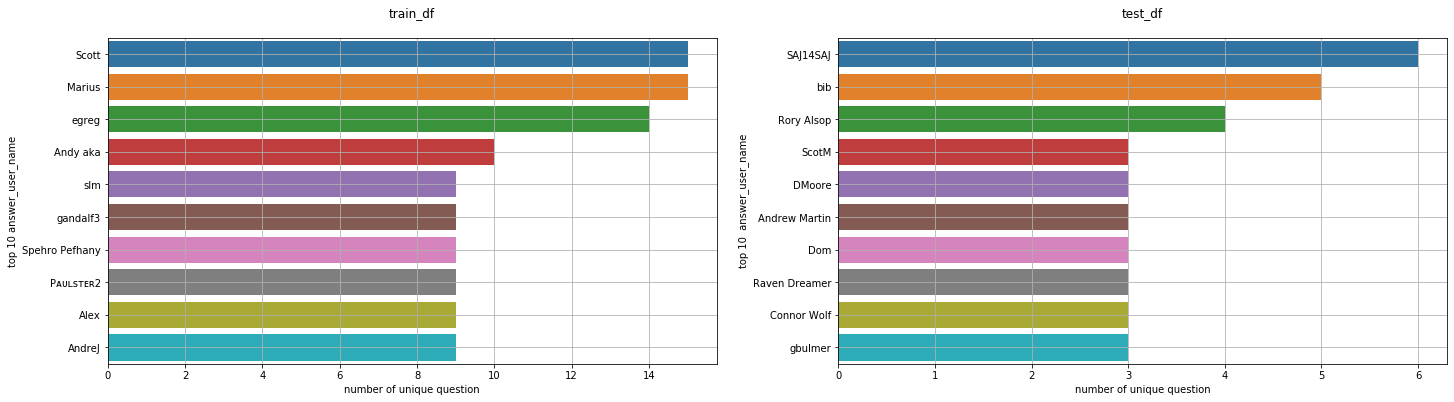

In [79]:
# Top 10 user who has asked most number of unique question
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))

sns.barplot(n_user_unique_answer_train[:10].values,n_user_unique_answer_train[:10].index,ax=ax1)
ax1.set(xlabel = "number of unique question", ylabel=f"top 10 answer_user_name", title='train_df\n')
ax1.grid()


sns.barplot(n_user_unique_answer_test[:10].values,n_user_unique_answer_test[:10].index , ax=ax2)
ax2.set(xlabel = "number of unique question", ylabel=f"top 10  answer_user_name", title='test_df\n')
ax2.grid()
plt.show()

#### 4.8.2.4. Description of number of unique question asked by user (train)

In [80]:
n_user_unique_answer_train.describe()

count    2390.000000
mean        1.499163
std         1.231901
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max        15.000000
Name: answer_user_name, dtype: float64

#### 4.8.2.5. Description of number of unique question asked by user (test)

In [81]:
n_user_unique_answer_test.describe()

count    363.000000
mean       1.311295
std        0.612539
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        6.000000
Name: answer_user_name, dtype: float64

#### Observation

* 


## 5.8.4 answer_user behaviour based on answer body
* How many number of words user usually answered in an answer? 
* What is the minimum number of words in answer answered by each user?
* Similary "max_title_len" , "mean_title_len" , "median_title_len" ?

#### For train_df

In [82]:
# Find the number of words in each answer 
temp = train_df[['answer_user_name','answer']]
number_of_words = temp['answer'].apply(lambda x : len(x[0].split()))
temp["number_of_words"] = number_of_words

# Apply aggrigation function( ) to find "sum","min","max","mean","median" of answer answered by each unique answer_user
answer_user_agg_behaviour_train = temp.groupby('answer_user_name')['number_of_words'].agg(["sum","min","max","mean","median"])
answer_user_agg_behaviour_train = answer_user_agg_behaviour_train.reset_index(level=0)

# Renaming column names
answer_user_agg_behaviour_train.rename({'sum': 'sum_answer_len', 'min': 'min_answer_len', 'max': 'max_answer_len', 'mean': 'mean_answer_len', 'median': "median_answer_len"}, axis=1, inplace=True)

# merging to train dataframe
train_df = pd.merge(left=train_df ,right=answer_user_agg_behaviour_train ,how='inner',on="answer_user_name")

#### for test_df


In [83]:
# Find the number of words in each answer 
temp = test_df[['answer_user_name','answer']]
number_of_words = temp['answer'].apply(lambda x : len(x[0].split()))
temp["number_of_words"] = number_of_words

# Apply aggrigation function( ) to find "sum","min","max","mean","median" of answer answered by each unique answer_user
answer_user_agg_behaviour_test = temp.groupby('answer_user_name')['number_of_words'].agg(["sum","min","max","mean","median"])
answer_user_agg_behaviour_test = answer_user_agg_behaviour_test.reset_index(level=0)

# Renaming column names
answer_user_agg_behaviour_test.rename({'sum': 'sum_answer_len', 'min': 'min_answer_len', 'max': 'max_answer_len', 'mean': 'mean_answer_len', 'median': "median_answer_len"}, axis=1, inplace=True)

# merging to train dataframe
test_df = pd.merge(left=test_df ,right=answer_user_agg_behaviour_test ,how='inner',on="answer_user_name")

#### Ploting answer_user behaviour based on answer


1: Plot for sum_answer_len


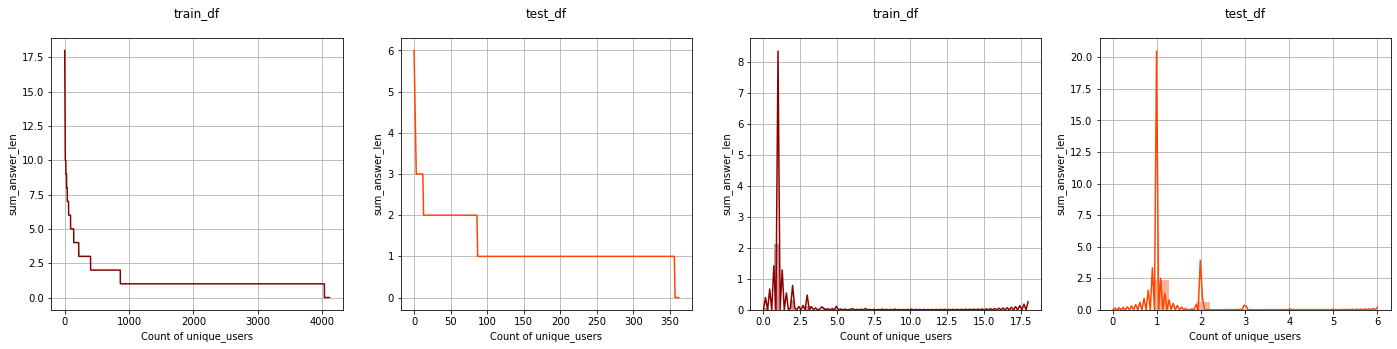


2: Plot for sum_answer_len


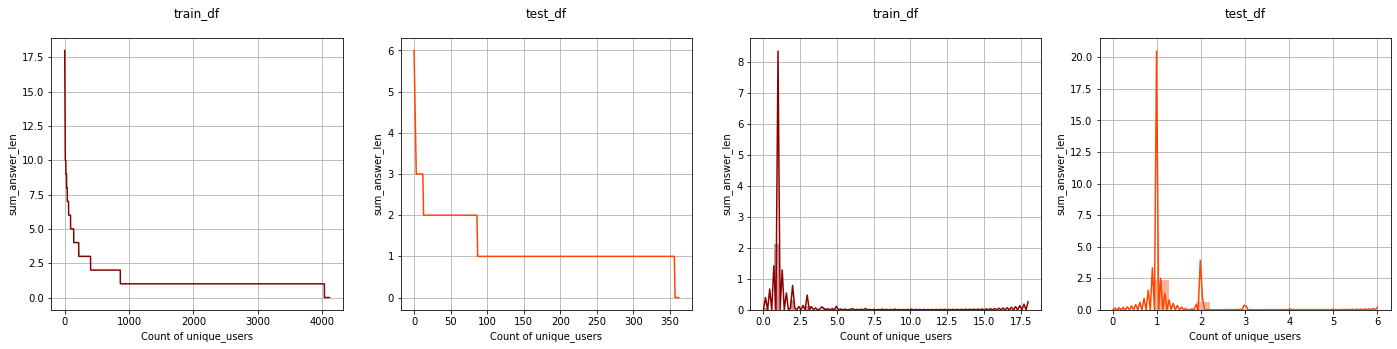


3: Plot for min_answer_len


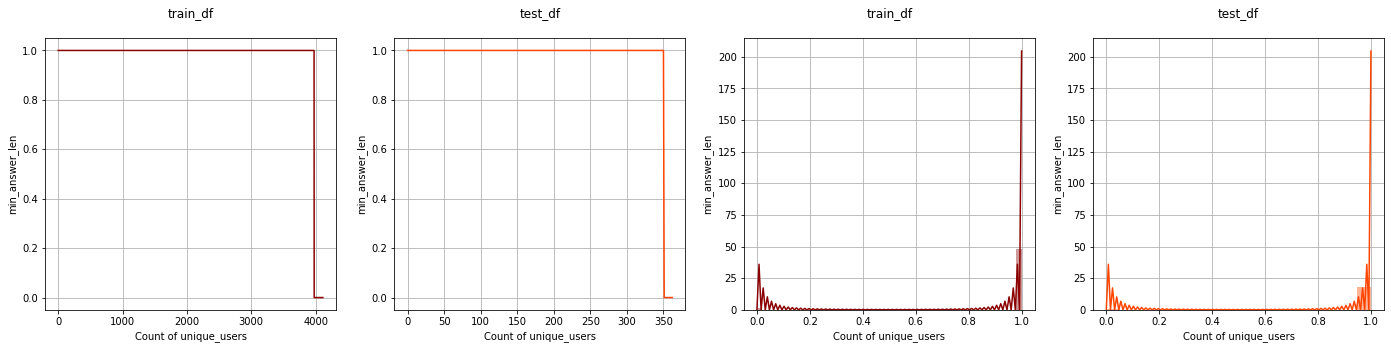


4: Plot for mean_answer_len


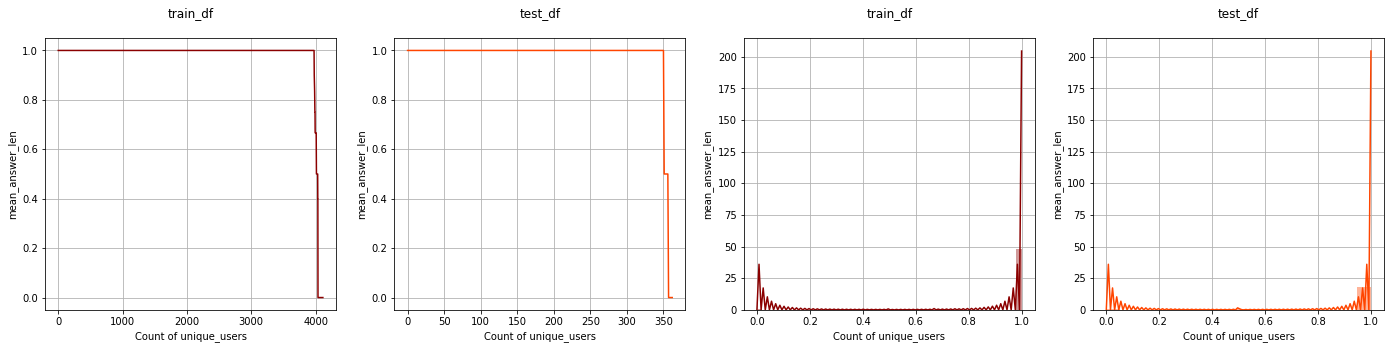


5: Plot for median_answer_len


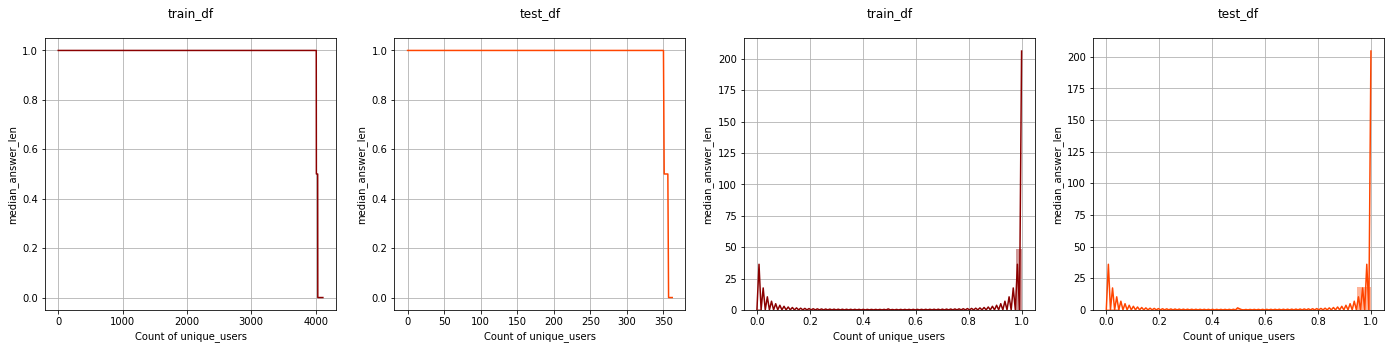

In [84]:
# Ploting user behaviour
user_behaviour_column_on_answer = ['sum_answer_len', 'sum_answer_len', 'min_answer_len', 'mean_answer_len','median_answer_len']

for idx,column in enumerate(user_behaviour_column_on_answer):
    
    train_set = answer_user_agg_behaviour_train.sort_values(by= column ,ascending=False)[column]
    test_set = answer_user_agg_behaviour_test.sort_values(by= column ,ascending=False)[column]
    
    print(f"\n{idx+1}: Plot for {column}")
    
    # Ploting lineplot for trainset
    f, (ax1, ax2 , ax3 , ax4 ) = plt.subplots(1, 4, figsize=(24,5))
    
    sns.lineplot(np.arange(len(train_set)), train_set,ax=ax1, color = "darkred")
    ax1.set(xlabel = "Count of unique_users", ylabel=f"{column}", title='train_df\n')
    ax1.grid()

    # Ploting lineplot for testset
    sns.lineplot(np.arange(len(test_set)), test_set,ax=ax2 ,color = "orangered")
    ax2.set(xlabel = "Count of unique_users", ylabel=f"{column}", title='test_df\n')
    ax2.grid()
    
    # Ploting distplot for trainset
    sns.distplot(train_set,ax=ax3, color = "darkred")
    ax3.set(xlabel = "Count of unique_users", ylabel=f"{column}", title='train_df\n')
    ax3.grid()

    # Ploting distplot for testset
    sns.distplot( test_set, ax=ax4 ,color = "orangered")
    ax4.set(xlabel = "Count of unique_users", ylabel=f"{column}", title='test_df\n')
    ax4.grid()
    plt.show()

* Few of the plots of users behaviour on answer are heavely skewed toward right.
* Top two plots also very similar to log normal distribution
* Transfrom these log normal alike features using box cox and check weather transformed features follows Noraml distribution or not using Q-Q plot

In [85]:
# Q-Q Plot of Box Cox transformed user_behaviour_column_on_answer features
for idx,column_name in enumerate(user_behaviour_column_on_answer[:2]):
    
    print(f"Feature name: {column_name}")
    
    # Continues the loop if box cox fails to transform
    if sum(train_df[f'{column_name}']<1)>0:
        print(f"{idx+1}: Box Cox Transformation can not be applied on feature '{column_name}' because all the values of data must be positive for transformation\n\n")
        continue

    # Box Cox Transform
    boxcox_transformed_feature_train = boxcox(train_df[column_name])[0]
    boxcox_transformed_feature_test = boxcox(test_df[column_name])[0]
    
             
    # Saving the transformed user_behaviour_column_on_answer column in dataframe
    train_df[f"boxcox_transformed_{column_name}"] = boxcox_transformed_feature_train
    test_df[f"boxcox_transformed_{column_name}"] = boxcox_transformed_feature_test
    
    print(f"{idx+1}: Q-Q Plot for box cox transformed feature of {column_name}\n")
    
    # Q-Q Plot of transformed Feature
    q_q_plot(boxcox_transformed_feature_train, boxcox_transformed_feature_test, f"box cox transformed {column_name}")
    

Feature name: sum_answer_len
1: Box Cox Transformation can not be applied on feature 'sum_answer_len' because all the values of data must be positive for transformation


Feature name: sum_answer_len
2: Box Cox Transformation can not be applied on feature 'sum_answer_len' because all the values of data must be positive for transformation




* Guess we cannot tranform these user behaviour features using box cox thus we cannot plot Q-Q plot. Therefore cannot use these transformed featues

## 5.8.8. Common users who has asked the question and answered by himself in train_df and test_df

#### Common users who has asked question and answered by himself in train_df

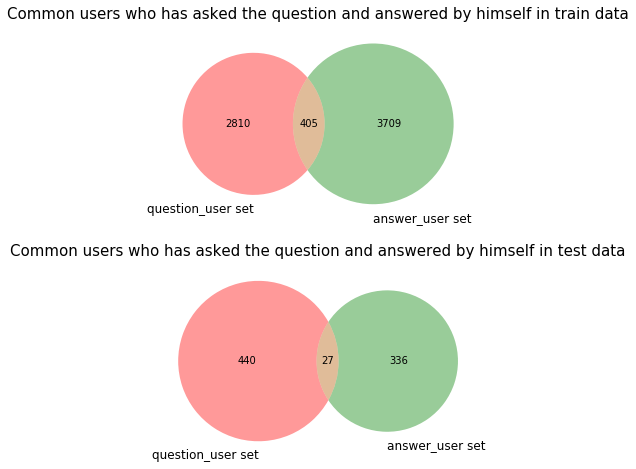

In [86]:
# Venn diagram for train_df
plt.figure(figsize=(16,8))
plt.subplot(211)
venn2([set(train_df.question_user_name.unique()), set(train_df.answer_user_name.unique())], set_labels = ('question_user set', 'answer_user set') )
plt.title("Common users who has asked the question and answered by himself in train data", fontsize=15)

# Venn diagram for test_df
plt.subplot(212)
venn2([set(test_df.question_user_name.unique()), set(test_df.answer_user_name.unique())], set_labels = ('question_user set', 'answer_user set') )
plt.title("Common users who has asked the question and answered by himself in test data", fontsize=15)
plt.show()

* There are few users who like to ask the question and answer it by self. Can be clearly seen in above plot.

## 5.9. EDA: category Feature

In [87]:
# unique categories
print(train_df['category'].unique())

['LIFE_ARTS' 'TECHNOLOGY' 'STACKOVERFLOW' 'CULTURE' 'SCIENCE']


#### Distribution For train_df

In [88]:
# For train_df
print(f"Unique number of category: {len(train_df['category'].unique())}\n")

category_dist_df_train = pd.DataFrame(train_df['category'].unique(),columns=['category'])
category_dist_df_train["values_count"] = train_df['category'].value_counts().values
category_dist_df_train["distribution"] = train_df['category'].value_counts().values/sum(train_df['category'].value_counts().values)
category_dist_df_train

Unique number of category: 5



category  values_count  distribution
0      LIFE_ARTS          2441      0.401546
1     TECHNOLOGY          1253      0.206119
2  STACKOVERFLOW           963      0.158414
3        CULTURE           713      0.117289
4        SCIENCE           709      0.116631

#### Distribution For test_df

In [89]:
# For test_df
print(f"Unique number of category: {len(test_df['category'].unique())}\n")

category_dist_df_test = pd.DataFrame(test_df['category'].unique(),columns=['category'])
category_dist_df_test["values_count"] = test_df['category'].value_counts().values
category_dist_df_test["distribution"] = test_df['category'].value_counts().values/sum(test_df['category'].value_counts().values)
category_dist_df_test

Unique number of category: 5



category  values_count  distribution
0        CULTURE           204      0.428571
1     TECHNOLOGY           103      0.216387
2      LIFE_ARTS            64      0.134454
3  STACKOVERFLOW            58      0.121849
4        SCIENCE            47      0.098739

### Plot (pie chart) for category distribution in train and test

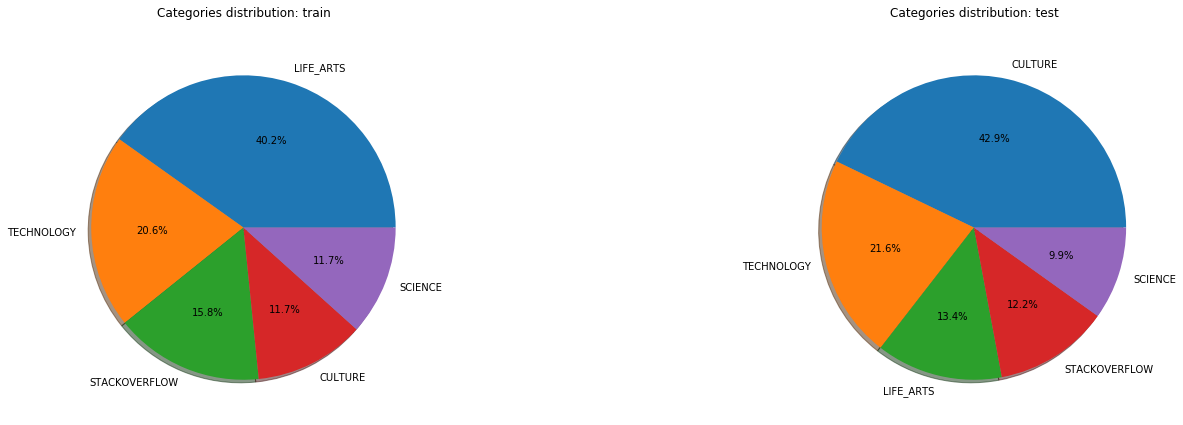

In [90]:
f, (ax1, ax2  ) = plt.subplots(1, 2, figsize=(24,7))

# Categories dist for train_df
ax1.pie(category_dist_df_train.values_count, labels=category_dist_df_train.category, shadow=True, autopct='%.1f%%')
ax1.set( title='Categories distribution: train\n')


# Categories dist for test_df
ax2.pie(category_dist_df_test.values_count, labels=category_dist_df_test.category, shadow=True, autopct='%.1f%%')
ax2.set(title='Categories distribution: test\n')
plt.show()


* The distribution of Categories is not similar in train set and test set
* LIGE_ARTS has majority of distribution in train but CULTURE category holds majority of distribution in test set.

## 4.10. EDA: Host featue

### 4.10.1. Common number of Host in train and test

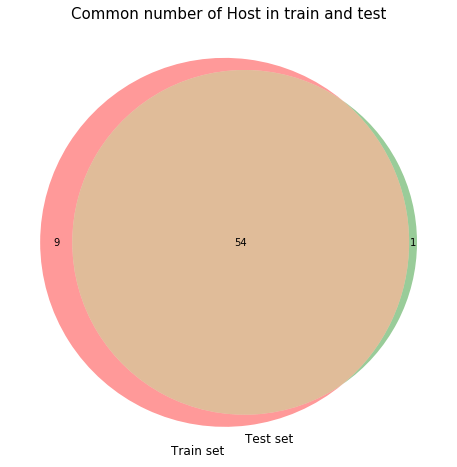

In [91]:

# Venn diagram for train_df
plt.figure(figsize=(16,8))
plt.subplot(111)
venn2([set(train_df.host.unique()), set(test_df.host.unique())], set_labels = ('Train set', 'Test set') )
plt.title("Common number of Host in train and test", fontsize=15)
plt.show()

* Most of Categories is common in both train and test set.

### 5.10.2. Distribution of host in train and test

In [92]:
# For train_df
host_dist_df_train = pd.DataFrame(train_df['host'].value_counts().index,columns=['host'])
host_dist_df_train["values_count"] = train_df['host'].value_counts().values
host_dist_df_train["distribution"] = train_df['host'].value_counts().values/sum(train_df['category'].value_counts().values)

# For test_df
host_dist_df_test = pd.DataFrame(test_df['host'].value_counts().index,columns=['host'])
host_dist_df_test["values_count"] = test_df['host'].value_counts().values
host_dist_df_test["distribution"] = test_df['host'].value_counts().values/sum(train_df['category'].value_counts().values)

#### Plot for train_df

Unique number of host in train: 63



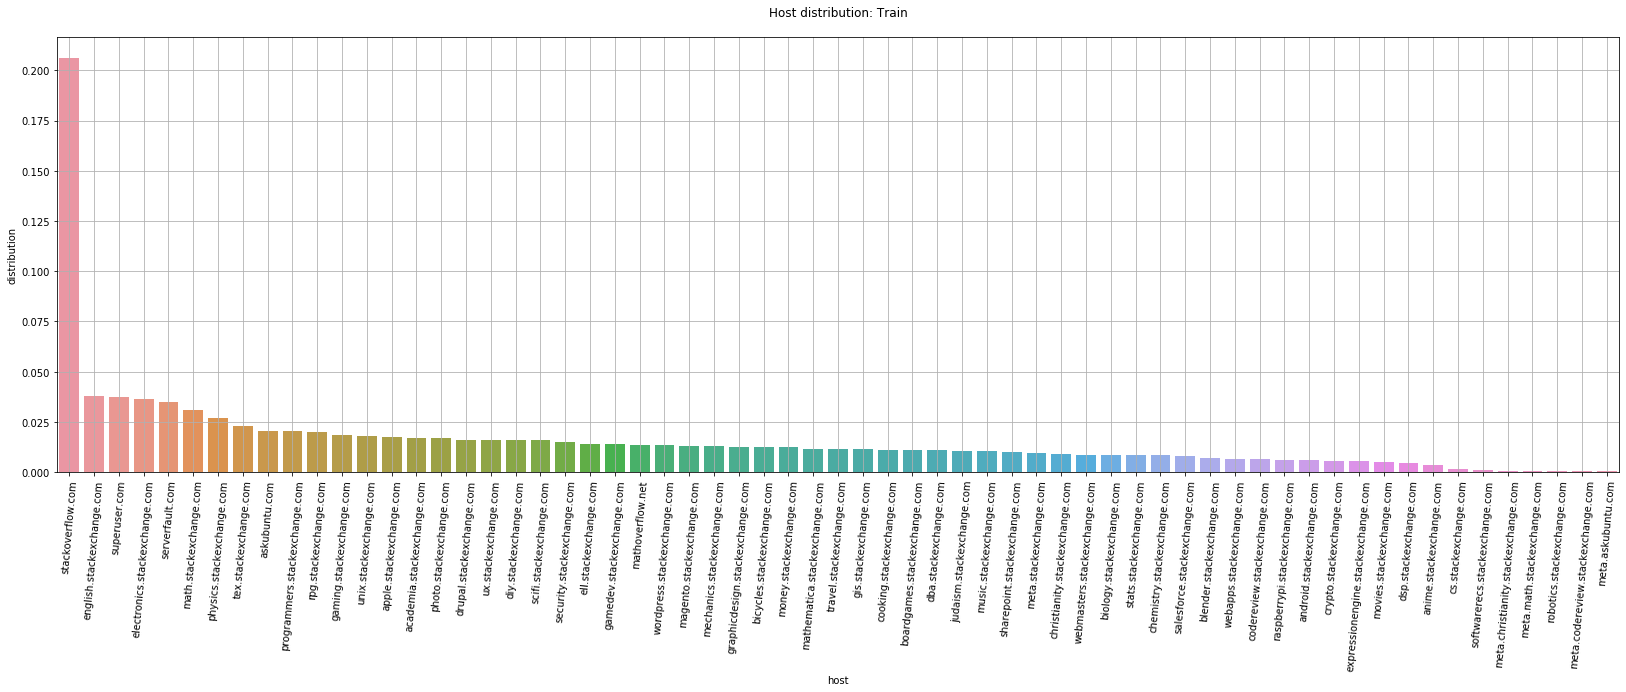

In [93]:
print(f"Unique number of host in train: {len(train_df['host'].unique())}\n")

# plot for distribution of host in train
plt.figure(figsize=(28,8))
sns.barplot(x=host_dist_df_train['host'], y=host_dist_df_train['distribution'])
plt.title("Host distribution: Train\n")
plt.xticks(rotation=85)
plt.grid()
plt.show()

#### Plot for test_df

Unique number of host in train: 55



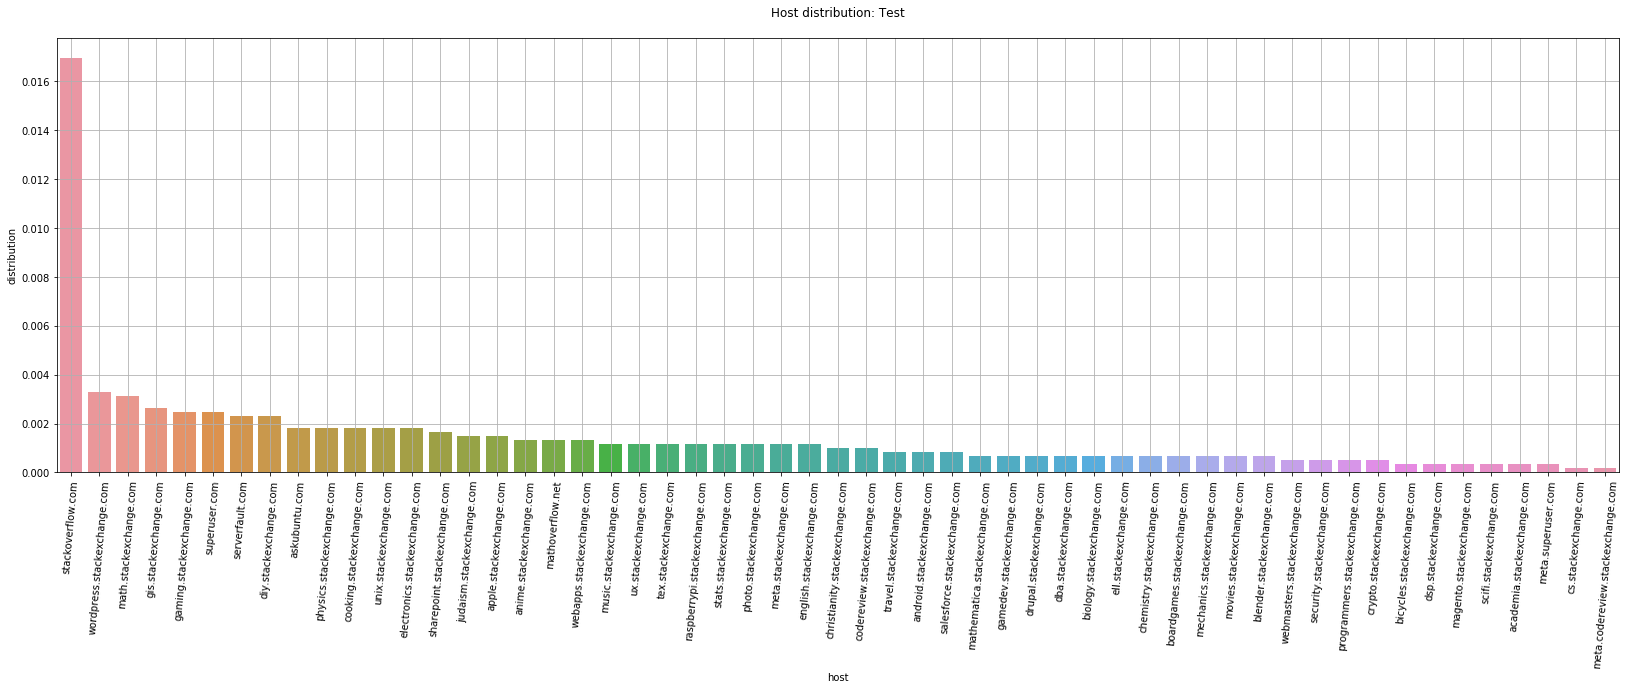

In [94]:
print(f"Unique number of host in train: {len(test_df['host'].unique())}\n")

# plot for distribution of host in train
plt.figure(figsize=(28,8))
sns.barplot(x=host_dist_df_test['host'], y=host_dist_df_test['distribution'])
plt.title("Host distribution: Test\n")
plt.xticks(rotation=85)
plt.grid()
plt.show()

* Host stackoverflow.com has majority of distribution in both train set and test set. This could be the reason why most of the keywords in WordClouds has programing syntax.

### 5.10.3. Top 10 host where number of users  has asked the question and answered by himself

#### For train_df

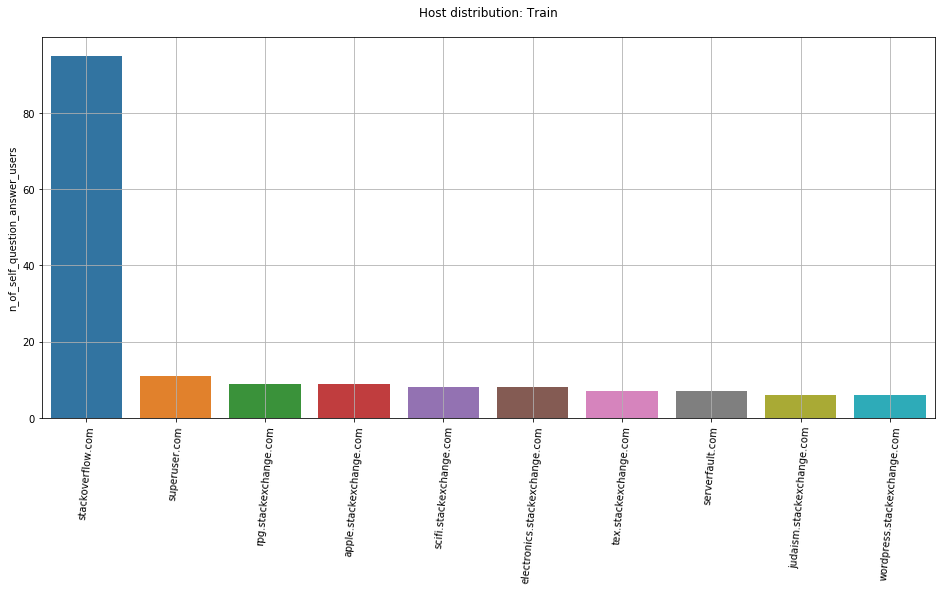

In [95]:
n_self_question_answer_users_df_train = pd.DataFrame(columns=['n_of_self_question_answer_users'])

for idx, host_name in enumerate(train_df['host'].unique()):
    ques_user =set(train_df[train_df['host']==host_name]['question_user_name'])
    ans_user =set(train_df[train_df['host']==host_name]['answer_user_name'])
    n_self_question_answer_users = len(ques_user.intersection(ans_user))
    n_self_question_answer_users_df_train.loc[host_name] = n_self_question_answer_users

n_self_question_answer_users_df_train.sort_values(by ='n_of_self_question_answer_users' ,ascending=False,inplace=True)


# plot for distribution of top 10 host where number of users  has asked the question and answered by himself
plt.figure(figsize=(16,7))
sns.barplot(x = n_self_question_answer_users_df_train.head(10).index, y = n_self_question_answer_users_df_train['n_of_self_question_answer_users'].head(10))
plt.title("Host distribution: Train\n")
plt.xticks(rotation=85)
plt.grid()
plt.show()

#### For test_df

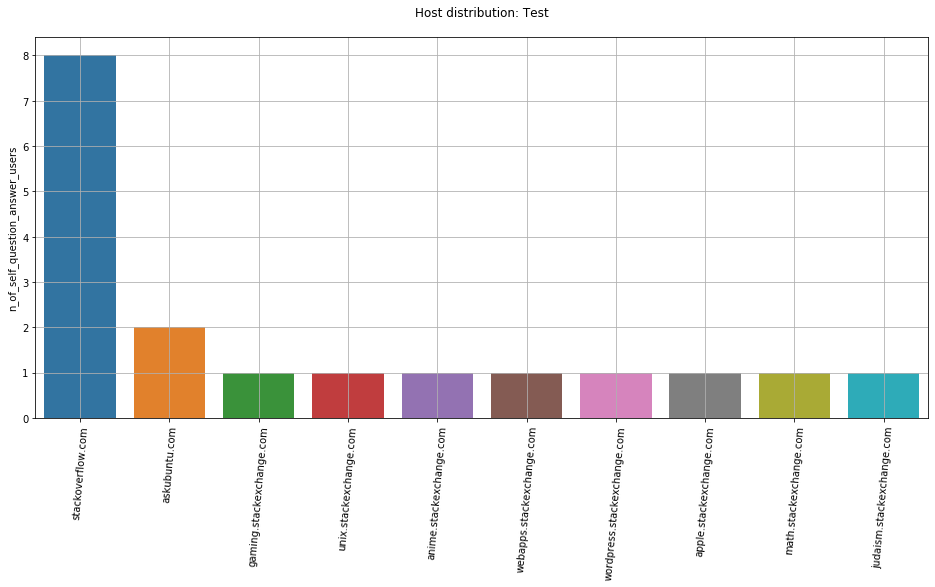

In [96]:
n_self_question_answer_users_df_test = pd.DataFrame(columns=['n_of_self_question_answer_users'])

for idx, host_name in enumerate(test_df['host'].unique()):
    ques_user =set(test_df[test_df['host']==host_name]['question_user_name'])
    ans_user =set(test_df[test_df['host']==host_name]['answer_user_name'])
    n_self_question_answer_users = len(ques_user.intersection(ans_user))
    n_self_question_answer_users_df_test.loc[host_name] = n_self_question_answer_users

n_self_question_answer_users_df_test.sort_values(by ='n_of_self_question_answer_users' ,ascending=False,inplace=True)


# plot for distribution of top 10 host where number of users  has asked the question and answered by himself
plt.figure(figsize=(16,7))
sns.barplot(x = n_self_question_answer_users_df_test.head(10).index, y = n_self_question_answer_users_df_test['n_of_self_question_answer_users'].head(10))
plt.title("Host distribution: Test\n")
plt.xticks(rotation=85)
plt.grid()
plt.show()

* From this plot it can be interprated that people tend to self question and answer on the host website 'stackoverflow.com' most.

* `Stack Overflow is a question and answer site for professional and enthusiast programmers`

### Special thanks to this kernal for below plots
https://www.kaggle.com/kabure/qa-eda-and-nlp-modelling-insights-and-data-vis

## 5.10.Some More Importand EDA plots

### 5.10.1. Number of unique questions by category

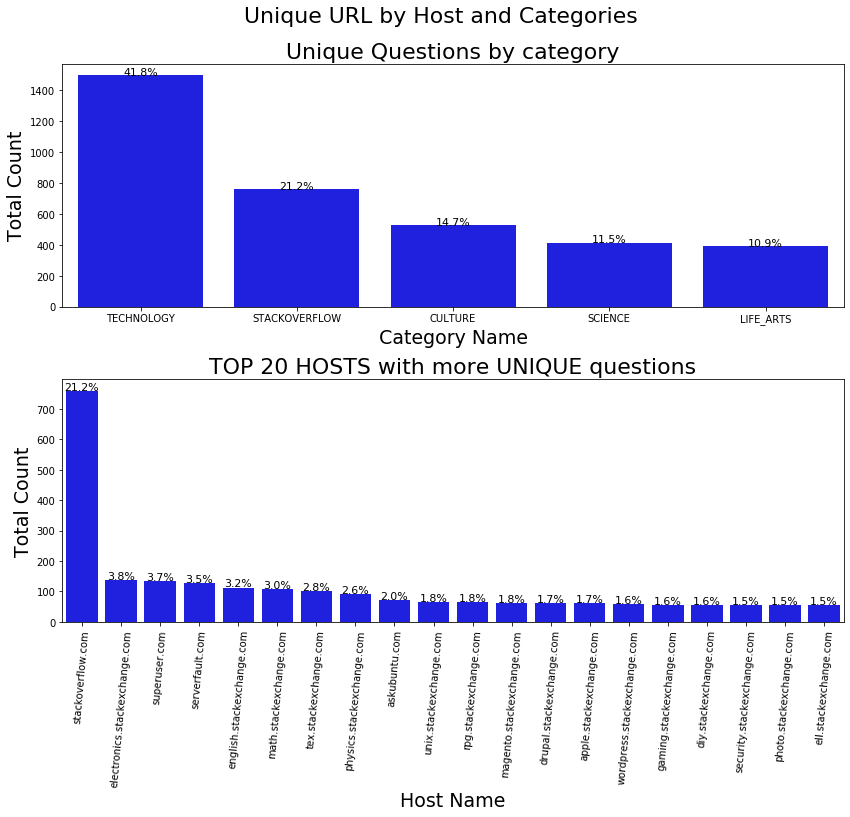

In [125]:
# refer: https://www.kaggle.com/kabure/qa-eda-and-nlp-modelling-insights-and-data-vis

host = train_df.groupby(['host'])['url'].nunique().sort_values(ascending=False)
category = train_df.groupby(['category'])['url'].nunique().sort_values(ascending=False)

plt.figure(figsize=(14,10))
plt.suptitle('Unique URL by Host and Categories', size=22)

plt.subplot(211)
g0 = sns.barplot(x=category.index, y=category.values, color='blue')
g0.set_title("Unique Questions by category", fontsize=22)
g0.set_xlabel("Category Name", fontsize=19)
g0.set_ylabel("Total Count", fontsize=19)
#g1.set_xticklabels(g1.get_xticklabels(),rotation=45)
for p in g0.patches:
    height = p.get_height()
    g0.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/category.sum()*100),
            ha="center",fontsize=11) 

plt.subplot(212)
g1 = sns.barplot(x=host[:20].index, y=host[:20].values, color='blue')
g1.set_title("TOP 20 HOSTS with more UNIQUE questions", fontsize=22)
g1.set_xlabel("Host Name", fontsize=19)
g1.set_ylabel("Total Count", fontsize=19)
g1.set_xticklabels(g1.get_xticklabels(),rotation=85)
for p in g1.patches:
    height = p.get_height()
    g1.text(p.get_x()+p.get_width()/2.,
            height + 3,
            '{:1.1f}%'.format(height/host.sum()*100),
            ha="center",fontsize=11) 
    
plt.subplots_adjust(hspace = 0.3, top = 0.90)

plt.show()

#### First chart: 
The most common category in Stackexchange fórums are:

1 - Technology(41.8%)

2 - Stackoverflow (21.2%)

3 - Culture (14.7%)

4 - Science (11.2)

5 - Life Arts(10.9)

* It's not so unbalanced, so it can be useful to train the model.


#### Second Chart: 
* The most common category is the Stackoverflow with 20.6% of the total open topics(questions);

* After the StackOverflow we can see that only 7 categories have a ratio highest than 2%, we have in total 59;

* The group of Stackoverflow, eletronics, superuser, serverfault, english, math, tex, physics and askubuntu together has almost 46% of the total questions.

### 5.10.2 Number of users who has asked question and answered by themself (by category) in train

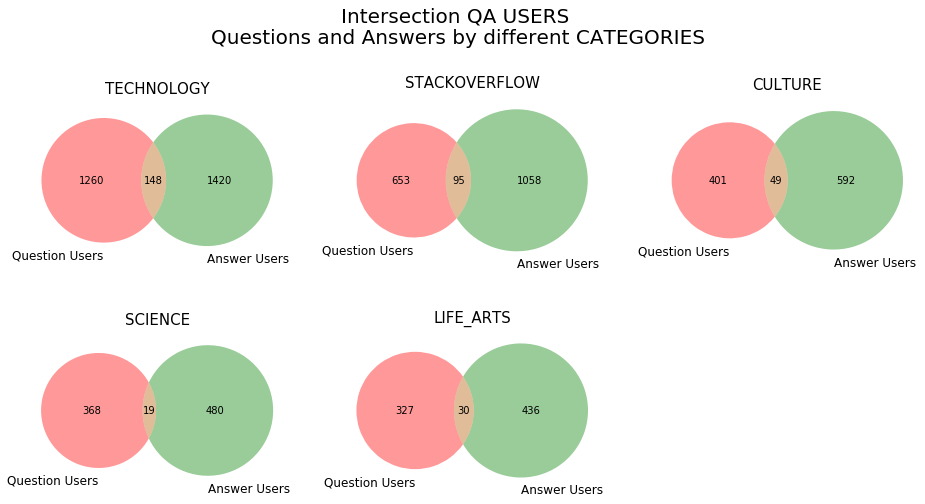

In [136]:
# refer: https://www.kaggle.com/kabure/qa-eda-and-nlp-modelling-insights-and-data-vis

import matplotlib.gridspec as gridspec # to do the grid of plots

grid = gridspec.GridSpec(3, 3)
plt.figure(figsize=(16,3*4))

plt.suptitle('Intersection QA USERS \nQuestions and Answers by different CATEGORIES', size=20)

for n, col in enumerate(train_df['category'].value_counts().index):
    ax = plt.subplot(grid[n])
    venn2([set(train_df[train_df.category == col]['question_user_name'].value_counts(dropna=False).index), 
           set(train_df[train_df.category == col]['answer_user_name'].value_counts(dropna=False).index)],
      set_labels=('Question Users', 'Answer Users'), )
    ax.set_title(str(col), fontsize=15)
    ax.set_xlabel('')
    #plt.subplots_adjust(top = 0.98, wspace=.9, hspace=.9)
    
plt.subplots_adjust(top = 0.9, hspace=.1)

plt.show()

### 5.10.3. Number of users who has asked question and answered by themself (by Host) in train

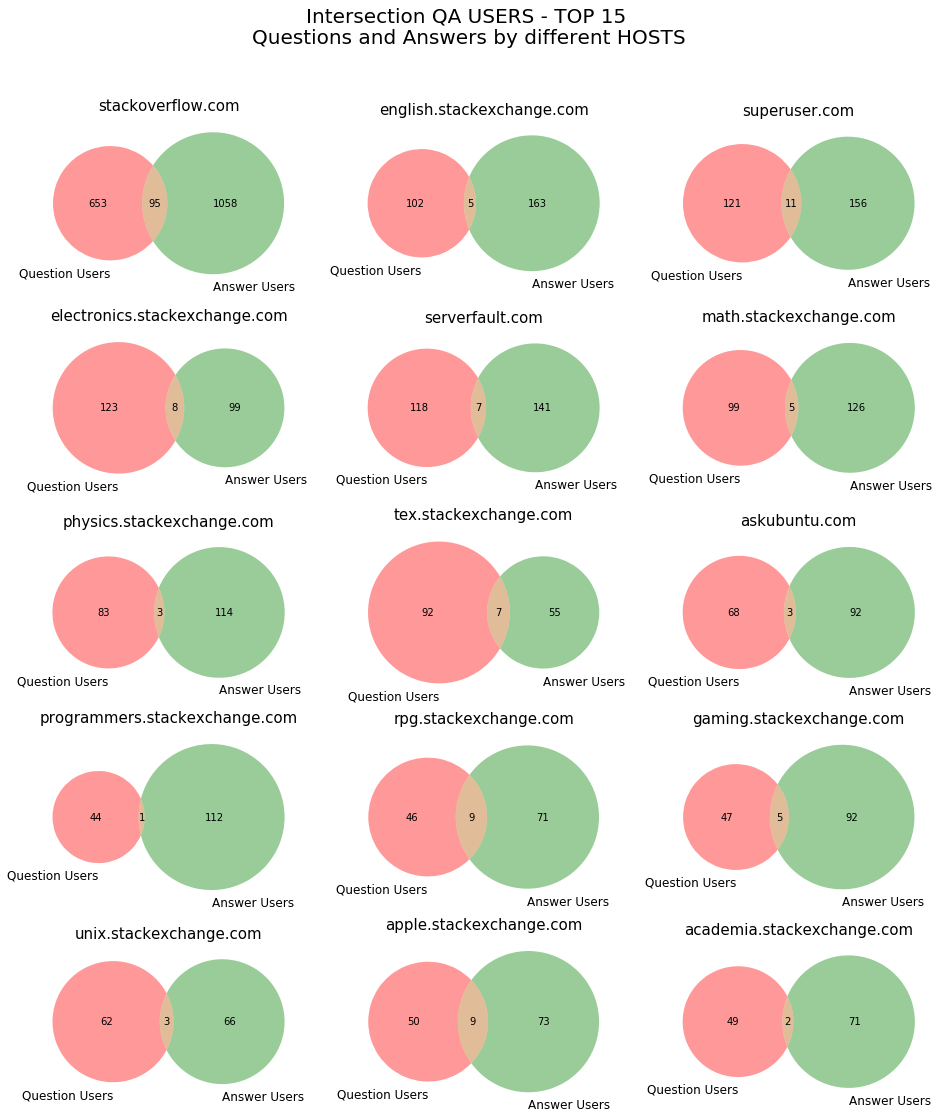

In [137]:
# refer: https://www.kaggle.com/kabure/qa-eda-and-nlp-modelling-insights-and-data-vis

grid = gridspec.GridSpec(5, 3)
plt.figure(figsize=(16,4.5*4))

plt.suptitle('Intersection QA USERS - TOP 15 \nQuestions and Answers by different HOSTS', size=20)
top_host = train_df['host'].value_counts()[:15].index
for n, col in enumerate(top_host):
    ax = plt.subplot(grid[n])
    venn2([set(train_df[train_df.host == col]['question_user_name'].value_counts(dropna=False).index), 
           set(train_df[train_df.host == col]['answer_user_name'].value_counts(dropna=False).index)],
      set_labels=('Question Users', 'Answer Users'), )
    ax.set_title(str(col), fontsize=15)
    ax.set_xlabel('')
    #plt.subplots_adjust(top = 0.98, wspace=.9, hspace=.9)
    
plt.subplots_adjust(top = 0.9, hspace=.1)

plt.show()

* It's interesting to note that programmers host has almost 1:3 ratio between QA Users, and only one in the intersection.

* Only for curiosity, we can take a look on one some of the intersection users to see what type of questions was done by them

### 5.10.4 Title and Body Lenghts of questions by each category

In [142]:
# Tokenize each item in the review column
from nltk import word_tokenize
word_tokens = [word_tokenize(question) for question in train_df.question_body]

# Create an empty list to store the length of the reviews
len_tokens = []

# Iterate over the word_tokens list and determine the length of each item
for i in range(len(word_tokens)):
     len_tokens.append(len(word_tokens[i]))

# Create a new feature for the lengh of each review
train_df['question_n_words'] = len_tokens

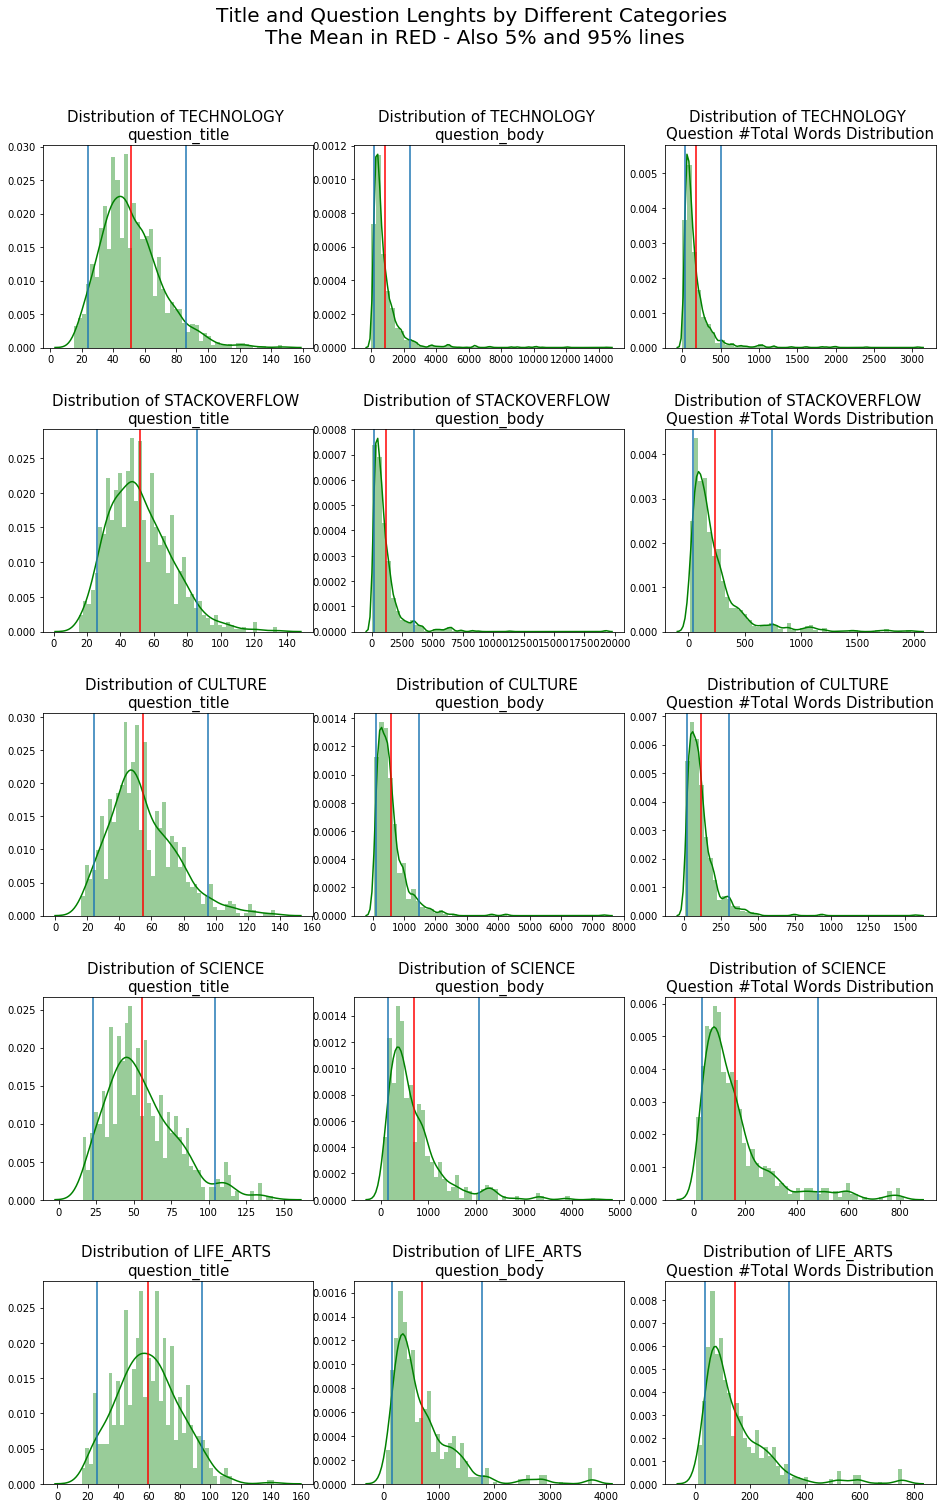

In [146]:
grid = gridspec.GridSpec(5, 3)
plt.figure(figsize=(16,6*4))

plt.suptitle('Title and Question Lenghts by Different Categories \nThe Mean in RED - Also 5% and 95% lines', size=20)
count=0
top_cats = train_df['category'].value_counts().index
for n, col in enumerate(top_cats):
    for i, q_t in enumerate(['question_title', 'question_body', 'question_n_words']):
        ax = plt.subplot(grid[count])
        if q_t == 'question_n_words':
            sns.distplot(train_df[train_df['category'] == col][q_t], bins = 50, 
                         color='g', label="RED - 50%") 
            ax.set_title(f"Distribution of {str(col)} \nQuestion #Total Words Distribution", fontsize=15)
            ax.axvline(train_df[train_df['category'] == col][q_t].quantile(.95))
            ax.axvline(train_df[train_df['category'] == col][q_t].quantile(.05))
            mean_val = train_df[train_df['category'] == col][q_t].mean()
            ax.axvline(mean_val, color='red' )
            ax.set_xlabel('')            
        else:
            sns.distplot(train_df[train_df['category'] == col][q_t].str.len(), bins = 50, 
                         color='g', label="RED - 50%") 
            ax.set_title(f"Distribution of {str(col)} \n{str(q_t)}", fontsize=15)
            ax.axvline(train_df[train_df['category'] == col][q_t].str.len().quantile(.95))
            ax.axvline(train_df[train_df['category'] == col][q_t].str.len().quantile(.05))
            mean_val = train_df[train_df['category'] == col][q_t].str.len().mean()
            ax.axvline(mean_val, color='red' )
            #ax.text(x=mean_val*1.1, y=.02, s='Holiday in US', alpha=0.7, color='#334f8d')
            ax.set_xlabel('')
        count+=1
        
plt.subplots_adjust(top = 0.90, hspace=.4, wspace=.15)
plt.show()

* The quantiles of the distributions are very similar in all categories in both title and question lenghts.

### 5.10.5. PCA visualisation of target labels hue by categories

refer : https://www.kaggle.com/kabure/qa-eda-and-nlp-modelling-insights-and-data-vis

#### This is to just visualise how important is categorical feature in distintuising taget labels?  (like pseudo feature importance)

Applying Machine learning model and then finding feature importance would definaltely be a better choice nonetheless.

In [207]:
# Scaling targets or labels with mean=0, and variance=1 (getting targets ready for PCA)
sc=StandardScaler(with_mean=True)
scalar_targets = sc.fit_transform(train_df[target_vars])

# Pca fitting and transform
pca = PCA()
pca_component = pca.fit_transform(scalar_targets)

# variance explained by top 2 eigen vector values
print(f"variance explained by top 2 eigen vector values: {round(sum(pca.explained_variance_ratio_[:2]),2)} %")

variance explained by top 2 eigen vector values: 0.22 %


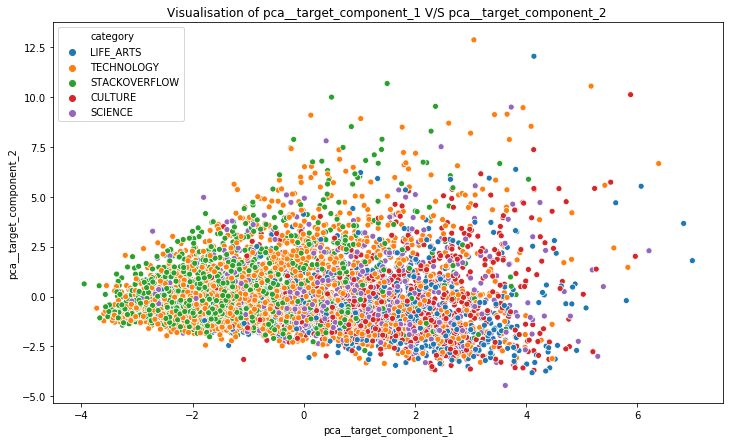

In [208]:
pca__target_component_1 = pca_component[:,0]
pca__target_component_2 = pca_component[:,1]

# Ploting
plt.figure(figsize=(12,7))
sns.scatterplot(pca__target_component_1, pca__target_component_2, hue=train_df['category'])
plt.title("Visualisation of pca__target_component_1 V/S pca__target_component_2 ")
plt.xlabel("pca__target_component_1")
plt.ylabel("pca__target_component_2")
plt.show()

* PCA plot of targets using category feature is definately showing some patterns.
* Category feature would definately be helpful in distinguish datapoints and regressing target values.

### 5.10.6. WordClouds of Questions Texts in each Categories

 1: category TECHNOLOGY
 2: category STACKOVERFLOW
 3: category CULTURE
 4: category SCIENCE
 5: category LIFE_ARTS


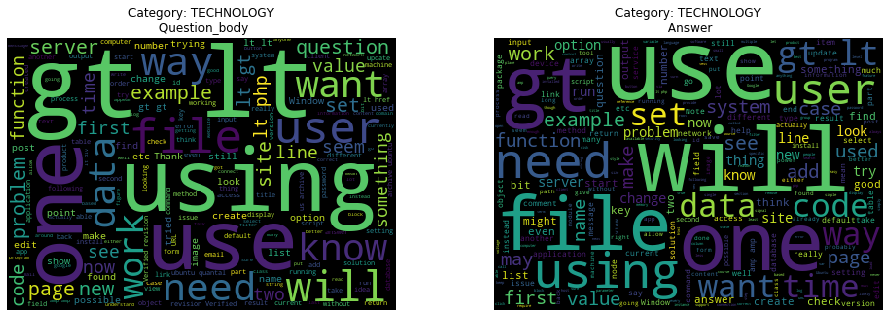

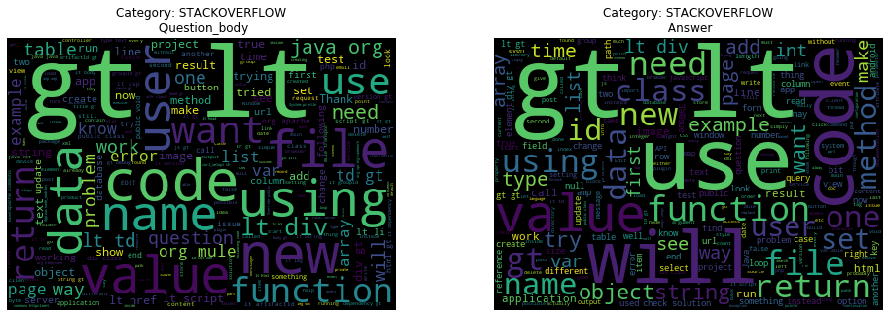

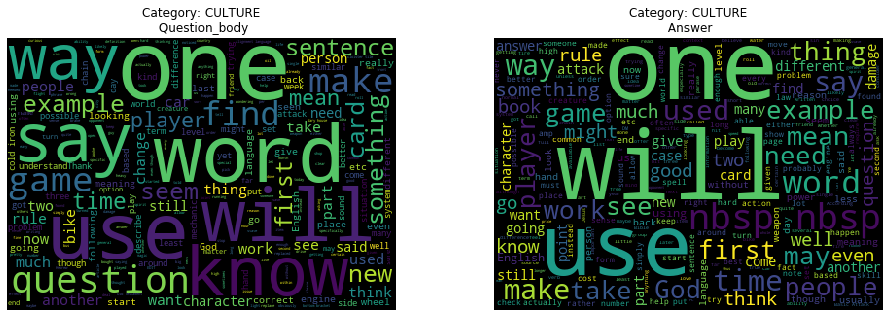

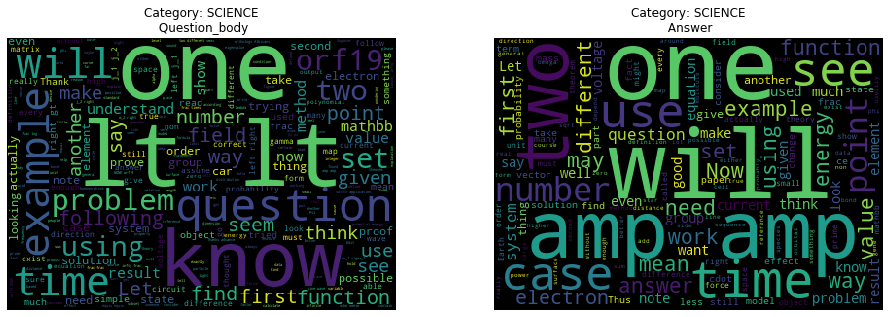

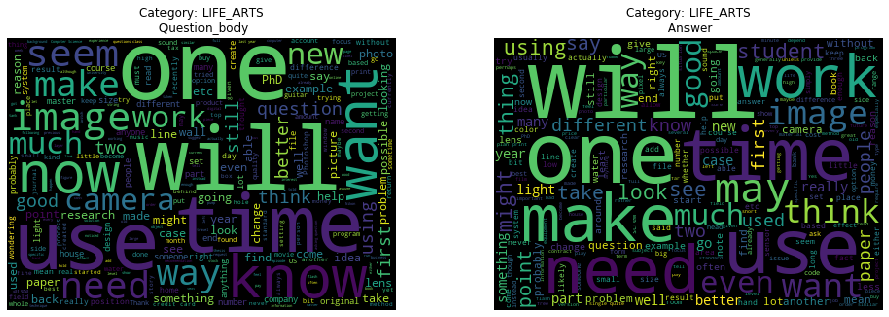

In [226]:
for idx, cat in enumerate(train_df['category'].value_counts().index):
    
    f, (ax1, ax2 ) = plt.subplots(1, 2, figsize=(16,5))
    
    wordcloud_question = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=250,
        max_font_size=100, 
        width=400, height=280,
        random_state=42,
    ).generate(" ".join(train_df[train_df['category'] == cat]['question_body'].astype(str)))
    
    print(f" {idx+1}: category {cat}")
    ax1.imshow(wordcloud_question)
    ax1.set(title=f'Category: {cat}\n Question_body')
    ax1.axis('off')
    
    wordcloud_anser = WordCloud(
        background_color='black',
        stopwords=stopwords,
        max_words=250,
        max_font_size=100, 
        width=400, height=280,
        random_state=42,
    ).generate(" ".join(train_df[train_df['category'] == cat]['answer'].astype(str)))
    
    ax2.imshow(wordcloud_anser)
    ax2.set(title=f'Category: {cat}\n Answer')
    ax2.axis('off')
    


* This plot is showing some good insights. The WordClouds of Questions and Answers is almost similar of each of the categories.
* This means that if question is in the programing contex or belong to stackoverflow category then answer is also in the same contex. ( Isn't it common sense :) )
* Similary we can plot Wordclouds of each host as well. but we will plot it after preprocessing the text and revisit all the wordcloud plots again.

### 5.10.7 Polarity and subjectivity analyses of question_title

Big thangs to this kernal: https://www.kaggle.com/kabure/qa-eda-and-nlp-modelling-insights-and-data-vis

In [231]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

train_df['q_title_polarity'] = train_df['question_title'].apply(pol)
train_df['q_title_subjectivity'] = train_df['question_title'].apply(sub)

train_df[['question_title', 'category', 'q_title_polarity', 'q_title_subjectivity']].head()

question_title    category  \
0  What am I losing when using extension tubes in...   LIFE_ARTS   
1  Is lots of red juice normal when making sous-v...   LIFE_ARTS   
2  What kind of dose can you expect from a radioa...   LIFE_ARTS   
3  How to update an SQL column using a known perm...  TECHNOLOGY   
4  Highlight Search (hls) matches of multiple sea...  TECHNOLOGY   

   q_title_polarity  q_title_subjectivity  
0             0.000                 0.000  
1             0.075                 0.325  
2             0.600                 0.900  
3             0.000                 0.125  
4             0.000                 0.300

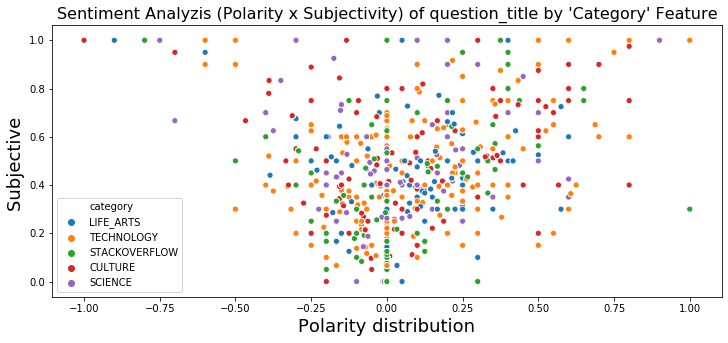

In [235]:
#Polarity and subjectivity plot
plt.figure(figsize=(12,5))
g = sns.scatterplot(x='q_title_polarity', y='q_title_subjectivity', 
                    data=train_df, hue='category')
g.set_title("Sentiment Analyzis (Polarity x Subjectivity) of question_title by 'Category' Feature", fontsize=16)
g.set_xlabel("Polarity distribution",fontsize=18)
g.set_ylabel("Subjective ",fontsize=18)
plt.show()

### 5.10.8 Polarity and subjectivity analyses of question_body

refer: https://www.kaggle.com/kabure/qa-eda-and-nlp-modelling-insights-and-data-vis

In [236]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

train_df['q_body_polarity'] = train_df['question_body'].apply(pol)
train_df['q_body_subjectivity'] = train_df['question_body'].apply(sub)

train_df[['question_body', 'category', 'q_body_polarity', 'q_body_subjectivity']].head()

question_body    category  \
0  After playing around with macro photography on...   LIFE_ARTS   
1  So I made a 1lb hanger steak via sous-vide the...   LIFE_ARTS   
2  I read that lens makers used to use radioactiv...   LIFE_ARTS   
3  \n\nLarger view of the issue is here: http://i...  TECHNOLOGY   
4  Many times when working on code, I search for ...  TECHNOLOGY   

   q_body_polarity  q_body_subjectivity  
0         0.165892             0.447527  
1         0.087500             0.356250  
2         0.400000             0.400000  
3         0.000000             0.500000  
4         0.062500             0.325000

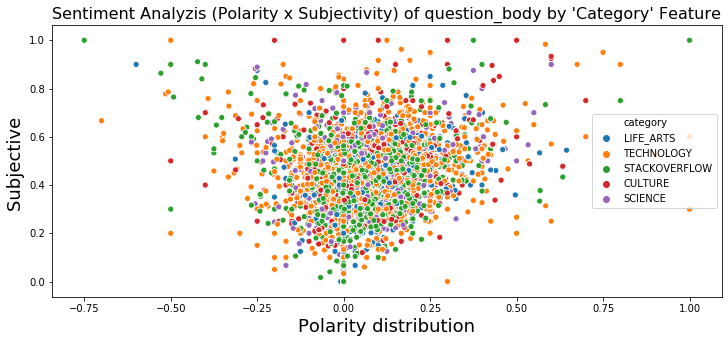

In [237]:
#Polarity and subjectivity plot
plt.figure(figsize=(12,5))
g = sns.scatterplot(x='q_body_polarity', y='q_body_subjectivity', 
                    data=train_df, hue='category')
g.set_title("Sentiment Analyzis (Polarity x Subjectivity) of question_body by 'Category' Feature", fontsize=16)
g.set_xlabel("Polarity distribution",fontsize=18)
g.set_ylabel("Subjective ",fontsize=18)
plt.show()

### 5.10.9 Polarity and subjectivity analyses of answer

refer: https://www.kaggle.com/kabure/qa-eda-and-nlp-modelling-insights-and-data-vis

In [238]:
pol = lambda x: TextBlob(x).sentiment.polarity
sub = lambda x: TextBlob(x).sentiment.subjectivity

train_df['answer_polarity'] = train_df['answer'].apply(pol)
train_df['answer_subjectivity'] = train_df['answer'].apply(sub)

train_df[['answer', 'category', 'answer_polarity', 'answer_subjectivity']].head()

answer    category  \
0  I just got extension tubes, so here's the skin...   LIFE_ARTS   
1  Pretty much...yes, but you can fix it!.\n\nWhe...   LIFE_ARTS   
2  Typical lens radiation was apparently approach...   LIFE_ARTS   
3  Seems like all you want is something like?\n\n...  TECHNOLOGY   
4  The built-in search cannot do that, but there ...  TECHNOLOGY   

   answer_polarity  answer_subjectivity  
0         0.062428             0.446359  
1         0.176566             0.486429  
2        -0.033333             0.352778  
3         0.000000             0.000000  
4         0.275000             0.525000

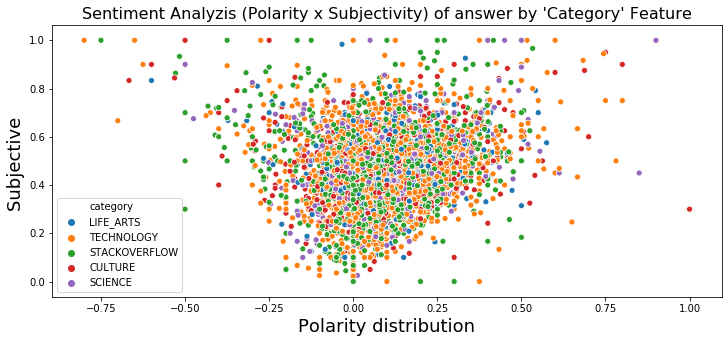

In [239]:
#Polarity and subjectivity plot
plt.figure(figsize=(12,5))
g = sns.scatterplot(x='answer_polarity', y='answer_subjectivity', 
                    data=train_df, hue='category')
g.set_title("Sentiment Analyzis (Polarity x Subjectivity) of answer by 'Category' Feature", fontsize=16)
g.set_xlabel("Polarity distribution",fontsize=18)
g.set_ylabel("Subjective ",fontsize=18)
plt.show()

## Saving all the transformed features and behaviour features into pickle file

In [240]:
# Saving all the transformed features and behaviour features into pickle file
train_df.to_pickle("train_df.pkl")
test_df.to_pickle("test_df.pkl")

#### All the features after all the box cox transformation and user behaviour analyses

In [241]:
all_feat = [col for col in train_df.columns if col not in target_vars]
print(" All the features after all the box cox transformation and user behaviour analyses:\n")
for idx,f in enumerate(all_feat):
    print(f"{idx+1}: {f}")

 All the features after all the box cox transformation and user behaviour analyses:

1: qa_id
2: question_title
3: question_body
4: question_user_name
5: question_user_page
6: answer
7: answer_user_name
8: answer_user_page
9: url
10: category
11: host
12: box_cox_len_question_body
13: box_cox_n_words_in_question_body
14: sum_title_len
15: min_title_len
16: max_title_len
17: mean_title_len
18: median_title_len
19: boxcox_transformed_sum_title_len
20: boxcox_transformed_min_title_len
21: boxcox_transformed_max_title_len
22: boxcox_transformed_mean_title_len
23: boxcox_transformed_median_title_len
24: sum_body_len
25: min_body_len
26: max_body_len
27: mean_body_len
28: median_body_len
29: boxcox_transformed_sum_body_len
30: boxcox_transformed_max_body_len
31: boxcox_transformed_mean_body_len
32: boxcox_transformed_median_body_len
33: box_cox_len_answer
34: box_cox_n_words_in_answer
35: sum_answer_len
36: min_answer_len
37: max_answer_len
38: mean_answer_len
39: median_answer_len
40: quest

## 6. Insights and Findings